# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
path_to_homework = 'C:/My Files/Python Projects/CF/'

#### Loading the data

In [3]:
df_loans_clean = pd.read_csv('C:/My Files/Python Projects/CF/dat/Loan Defaulting Prediction/user_info_modified_baseline_dummies.csv') #loading the dataset 
#df_loans_clean = pd.read_csv('C:/My Files/Python Projects/CF/UCI_Credit_Card_modified_dummies.csv') #loading the dataset 
df_loans_clean.shape

(128181, 9)

#### Checking for NaNs

In [4]:
df_loans_clean.isnull().values.any()

True

#### Dropping NaNs

In [5]:
df_loans_clean = df_loans_clean.dropna() 
df_loans_clean.shape

(30502, 9)

#### Showcasing class imbalance

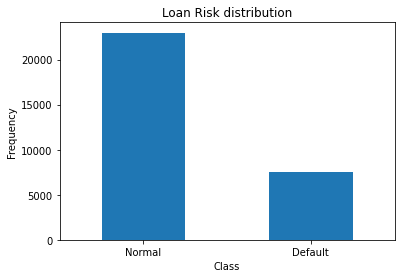

In [6]:
LABELS = ["Normal", "Default"]
count_classes = pd.value_counts(df_loans_clean['default'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Loan Risk distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [7]:
defaults = df_loans_clean[df_loans_clean.iloc[:,0] == 1]
normal = df_loans_clean[df_loans_clean.iloc[:,0] == 0]
print(defaults.shape)
print(normal.shape)

(7524, 9)
(22978, 9)


#### Limiting our training data to only non-defaulters

In [8]:
X_train, X_test = train_test_split(df_loans_clean, test_size=0.5, random_state=42)
X_train = X_train[X_train.default == 0]
y_train = X_train.iloc[:,0]
X_train = X_train.drop(['default'], axis=1)

y_test = X_test['default']
X_test = X_test.drop(['default'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [9]:
print(X_train.shape)

(11467, 8)


#### Dataloader

In [10]:
BATCH_SIZE = 5000

trainset = X_train 

testset = X_test
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

#### GPU pass

In [11]:
# set your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Autoencoder

In [12]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=8, out_features=7)
        self.enc2 = nn.Linear(in_features=7, out_features=6)
        #self.enc3 = nn.Linear(in_features=15, out_features=12)
        #self.enc4 = nn.Linear(in_features=12, out_features=10)
        #self.enc5 = nn.Linear(in_features=10, out_features=8)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=6, out_features=7)
        self.dec2 = nn.Linear(in_features=7, out_features=8)
        #self.dec3 = nn.Linear(in_features=12, out_features=15)
        #self.dec4 = nn.Linear(in_features=15, out_features=20)
        #self.dec5 = nn.Linear(in_features=20, out_features=data.shape[1])
        #self.dec5 = nn.Linear(in_features=20, out_features=73)
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        #x = nn.ReLU(self.enc3(x))
        #x = nn.ReLU(self.enc4(x))
        #x = nn.ReLU(self.enc5(x))
 
        # decoding
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        #x = nn.ReLU(self.dec3(x))
        #x = nn.ReLU(self.dec4(x))
        #x = nn.ReLU(self.dec5(x))
        return x
    
model = SparseAutoencoder().to(device)

## Applying Sparsity and KL divergence

In [13]:
model_children = list(model.children()) # layers as a list

def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(torch.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(rho_hat)).to(device)
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))


def sparse_loss(rho, data):
    values = data
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += kl_divergence(rho, values)
    return loss

### Initializing Autoencoder loss and optimizer

In [14]:
learning_rate = 0.05
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.0)

### Training

In [15]:
def train(model, dataloader, epoch):
    print('Training')
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(trainset)/dataloader.batch_size)):
        counter += 1
        dat = data.type(torch.FloatTensor)
        dat = dat.to(device)
        dat = dat.view(dat.size(0), -1)
        optimizer.zero_grad()
        outputs = model(dat)
        mse_loss = criterion(outputs, dat)
        if ADD_SPARSITY == 'yes':
            sparsity = sparse_loss(RHO, dat)
            # add the sparsity penalty
            loss = mse_loss + BETA * sparsity
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / counter
    print(f"Train Loss: {epoch_loss:.3f}")
    return epoch_loss

### Validation:

In [16]:
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
            counter += 1
            dat = data.type(torch.FloatTensor)
            dat = dat.to(device)
            dat = dat.view(dat.size(0), -1)
            outputs = model(dat)
            loss = criterion(outputs, dat)
            running_loss += loss.item()
    epoch_loss = running_loss / counter
    print(f"Val Loss: {epoch_loss:.3f}")  
    return epoch_loss

### Fitting the Autoencoder

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 of 10
Training


3it [00:00,  6.01it/s]                       
4it [00:00, 26.13it/s]                       
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 56288013.333
Validating
Val Loss: 36954513.000
Epoch 2 of 10
Training


3it [00:00, 22.88it/s]                       
4it [00:00, 42.08it/s]               
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 51989758.667
Validating
Val Loss: 34919519.500
Epoch 3 of 10
Training


3it [00:00, 23.61it/s]                       
4it [00:00, 33.03it/s]                       
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 42371257.333
Validating
Val Loss: 13610601.250
Epoch 4 of 10
Training


3it [00:00, 20.96it/s]                       
4it [00:00, 39.58it/s]               
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8179716.167
Validating
Val Loss: 74530.968
Epoch 5 of 10
Training


3it [00:00, 26.77it/s]               
4it [00:00, 36.34it/s]                       
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 686695.007
Validating
Val Loss: 134735.416
Epoch 6 of 10
Training


3it [00:00, 27.51it/s]               
4it [00:00, 41.20it/s]               
 50%|█████     | 1/2 [00:00<00:00,  9.99it/s]

Train Loss: 85834.346
Validating
Val Loss: 18042.712
Epoch 7 of 10
Training


3it [00:00, 16.38it/s]                       
4it [00:00, 33.87it/s]                       
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 10222.818
Validating
Val Loss: 3511.949
Epoch 8 of 10
Training


3it [00:00, 24.57it/s]                       
4it [00:00, 39.58it/s]               
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 2601.134
Validating
Val Loss: 192.426
Epoch 9 of 10
Training


3it [00:00, 28.02it/s]               
4it [00:00, 38.81it/s]                       
  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 563.651
Validating
Val Loss: 205.166
Epoch 10 of 10
Training


3it [00:00, 24.57it/s]               
4it [00:00, 31.72it/s]                       


Train Loss: 329.577
Validating
Val Loss: 230.887
0.0475 minutes


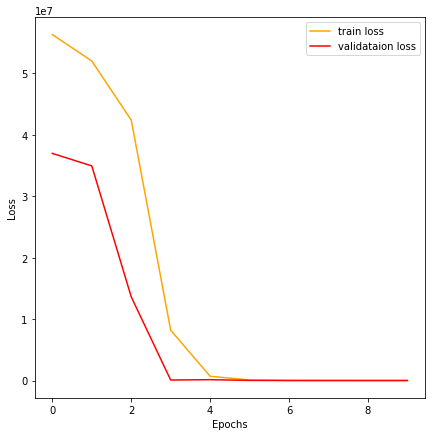

In [17]:
EPOCHS = 10
BETA = 0.005
ADD_SPARSITY = 'yes'
RHO = 0.05
BATCH_SIZE = 5000

train_loss = []
val_loss = []
start = time.time()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = train(model, trainloader, epoch)
    val_epoch_loss = validate(model, testloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
end = time.time()
print(f"{(end-start)/60:.3} minutes")
# save the trained model
torch.save(model.state_dict(), f"../outputs/sparse_ae{EPOCHS}.pth")

# loss plots
plt.figure(figsize=(7, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
trainloader = DataLoader(
    trainset, 
    batch_size=X_train.shape[0],
    shuffle=False
)

for i, data in tqdm(enumerate(trainloader), total=int(len(trainset)/trainloader.batch_size)):
        dat = data.type(torch.FloatTensor)
        dat = dat.to(device)
        dat = dat.view(dat.size(0), -1)
        
Autoencoder_output = model(dat)
print(Autoencoder_output.shape)

100%|██████████| 1/1 [00:00<00:00, 15.14it/s]

torch.Size([11467, 8])


In [19]:
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [20]:
def discriminator_loss(logits_real, logits_fake):
 
    loss = None
    y_1 = torch.ones(logits_real.shape[0]).to(device) # I create a vector of ones to denote real data
    y_0 = torch.zeros(logits_fake.shape[0]).to(device) # I create a vector of zeros to denote fake data
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean').to(device) # initializing BCE loss
    loss = criterion(logits_real.squeeze(), y_1).to(device) + criterion(logits_fake.squeeze(), y_0).to(device) # computes BCE loss, when y is 1 computes 1st term, when y is 0, second term, it then adds them up 
    return loss

def generator_loss(logits_fake):
    
    loss = None
    y_fake = torch.ones(logits_fake.shape[0]).to(device)
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean').to(device)  # BCE loss
    loss = criterion(logits_fake.squeeze(), y_fake).to(device)
    return loss

In [21]:
NOISE_DIM = 100

def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = nn.Sequential(
        nn.Flatten(start_dim=1).to(device),
        nn.Linear(8, 10).to(device),
        nn.LeakyReLU(0.2).to(device), 
        nn.Linear(10, 8).to(device),
        nn.LeakyReLU(0.2).to(device),
        nn.Linear(8, 1).to(device)  
    )
    model = model.to(device)
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    model = nn.Sequential(
        nn.Linear(NOISE_DIM, 1024).to(device),
        nn.ReLU().to(device), 
        nn.Linear(1024, 1024).to(device),
        nn.ReLU().to(device),
        nn.Linear(1024, 8).to(device),
        nn.Tanh().to(device)
    )
    model = model.to(device)
    return model

In [22]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    to_return = torch.randn((batch_size, dim))
    return to_return/torch.max(to_return)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.autograd import Variable
 
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
          ckpt_dir = path_to_homework + '/ckpts/', cont_train=False,
          batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None, k=1):
    """
    
    """
    if os.path.exists(os.path.join(ckpt_dir, 'checkpoint.pth')) and cont_train:
        ckpt = torch.load(os.path.join(ckpt_dir, 'checkpoint.pth'))
        start_epoch = ckpt['epoch'] + 1
        iter_count = ckpt['iter_count'] + 1
        G.load_state_dict(ckpt['G'])
        D.load_state_dict(ckpt['D'])
        print('Start from a checkpoint: {}, epoch:{}, iter:{}'.format(os.path.join(ckpt_dir, 'checkpoint.pth'), 
                                                 str(start_epoch), str(iter_count)))
    else:
        start_epoch = 0
        iter_count = 0
        
    for epoch in range(start_epoch, num_epochs):
        print('EPOCH: ', (epoch+1))
        for x in train_loader:
            real_data = Variable(x, requires_grad=True).to(device)
            real_data = real_data.type(torch.FloatTensor)

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_data = None

            ####################################
            #        Discriminator step        #
            #          YOUR CODE HERE          #
            ####################################
            for i in range(k):
              D.zero_grad()
              D_solver.zero_grad()
              real_data = real_data.to(device)
              discriminator_output_real = D(real_data) # discriminator forward pass on real images
              z = sample_noise(batch_size, NOISE_DIM).to(device) # sampling noise
              fake_data = G(z).to(device) # generating fake images
              fake_data = fake_data.to(device)
              discriminator_output_fake = D(fake_data).to(device) # discriminator forward pass on fake images
              d_error = discriminator_loss(discriminator_output_real, discriminator_output_fake) # computing discriminator loss
              d_error.backward(retain_graph=True) # back propagating the loss
              D_solver.step() # stepping the gradients
            #########       END      ###########
 
            ####################################
            #          Generator step          #
            #          YOUR CODE HERE          #
            ####################################
            G.zero_grad() #zero gradients for generator
            G_solver.zero_grad()
            z = sample_noise(batch_size, NOISE_DIM).to(device) # sampling noise
            fake_data = G(z).to(device) # generating fake images
            fake_data = fake_data.to(device)
            print(fake_data)
            generator_output_fake = D(fake_data).to(device)
            g_error = generator_loss(generator_output_fake) # computing generator loss
            g_error.backward(retain_graph=True) # back propagating the loss
            G_solver.step() # stepping the gradients
            ##########       END      ##########
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
            iter_count += 1
            
        # save checkpoints
        os.makedirs(ckpt_dir, exist_ok=True)
        print('Saving the model as a checkpoint...')
        torch.save({'epoch': epoch, 
                    'iter_count': iter_count,
                    'G': G.state_dict(), 
                    'D': D.state_dict()}, 
                   os.path.join(ckpt_dir, 'checkpoint.pth'))

In [24]:
# Add training code here:
D = discriminator().to(device) # initializing discriminator
G = generator().to(device) # initializing generator

D_solver = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0) # discriminator optimizer
G_solver = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0)  # generator optimizer

trainloader = DataLoader(
    Autoencoder_output, 
    batch_size=128,
    shuffle=True
)

train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=1, 
          ckpt_dir = path_to_homework + '/ckpts/', cont_train=False,
          batch_size=128, noise_size=100, num_epochs=30, train_loader=trainloader, device=device, k=3)

EPOCH:  1
tensor([[-0.0592,  0.0013,  0.0272,  ...,  0.0632, -0.0015,  0.0337],
        [-0.0563,  0.0167,  0.0094,  ...,  0.0291,  0.0220,  0.0124],
        [-0.0116,  0.0274,  0.0185,  ...,  0.0473,  0.0331,  0.0162],
        ...,
        [ 0.0013,  0.0531,  0.0493,  ...,  0.0364,  0.0227,  0.0256],
        [-0.0266,  0.0190,  0.0090,  ...,  0.0377, -0.0066,  0.0267],
        [-0.0085,  0.0387,  0.0415,  ...,  0.0061,  0.0300,  0.0017]],
       grad_fn=<TanhBackward>)
Iter: 0, D: 163.9, G:0.8221
tensor([[-0.0686,  0.0827,  0.0050,  ...,  0.1051, -0.0623, -0.0120],
        [-0.0634,  0.0762, -0.0161,  ...,  0.1002, -0.0539, -0.0363],
        [-0.0603,  0.0411,  0.0006,  ...,  0.0890, -0.0555, -0.0210],
        ...,
        [-0.0703,  0.0524, -0.0025,  ...,  0.1011, -0.0795,  0.0107],
        [-0.0652,  0.0644,  0.0191,  ...,  0.1301, -0.0838,  0.0046],
        [-0.0520,  0.0503, -0.0111,  ...,  0.1341, -0.0713,  0.0062]],
       grad_fn=<TanhBackward>)
Iter: 1, D: 147.8, G:0.817
tenso

Iter: 19, D: 0.8662, G:0.7595
tensor([[-0.7708,  0.4660,  0.3723,  ...,  0.8473, -0.7570, -0.6003],
        [-0.8569,  0.5615,  0.4719,  ...,  0.9094, -0.8534, -0.7013],
        [-0.8725,  0.5841,  0.4561,  ...,  0.9251, -0.8546, -0.7282],
        ...,
        [-0.8642,  0.5574,  0.4727,  ...,  0.9060, -0.8454, -0.7142],
        [-0.8207,  0.5144,  0.4093,  ...,  0.8743, -0.8146, -0.6258],
        [-0.8507,  0.5415,  0.4487,  ...,  0.9007, -0.8112, -0.6658]],
       grad_fn=<TanhBackward>)
Iter: 20, D: 0.8448, G:0.7582
tensor([[-0.9072,  0.6284,  0.5370,  ...,  0.9406, -0.8930, -0.7744],
        [-0.9028,  0.6645,  0.5485,  ...,  0.9399, -0.8914, -0.7571],
        [-0.9056,  0.6391,  0.5630,  ...,  0.9388, -0.8932, -0.7504],
        ...,
        [-0.9247,  0.6897,  0.5886,  ...,  0.9512, -0.9162, -0.8180],
        [-0.9084,  0.6562,  0.5559,  ...,  0.9449, -0.8949, -0.7904],
        [-0.8774,  0.6252,  0.5187,  ...,  0.9228, -0.8619, -0.7276]],
       grad_fn=<TanhBackward>)
Iter: 21, 

Iter: 37, D: 0.732, G:0.7671
tensor([[-0.9730,  0.8425,  0.8396,  ...,  0.9649, -0.9719, -0.7807],
        [-0.9819,  0.8648,  0.8776,  ...,  0.9806, -0.9831, -0.8351],
        [-0.9782,  0.8607,  0.8603,  ...,  0.9744, -0.9791, -0.8272],
        ...,
        [-0.9833,  0.8716,  0.8825,  ...,  0.9813, -0.9844, -0.8411],
        [-0.9907,  0.9129,  0.9070,  ...,  0.9876, -0.9905, -0.8739],
        [-0.9763,  0.8510,  0.8641,  ...,  0.9757, -0.9799, -0.8269]],
       grad_fn=<TanhBackward>)
Iter: 38, D: 0.7681, G:0.7682
tensor([[-0.9821,  0.8767,  0.8719,  ...,  0.9781, -0.9830, -0.8339],
        [-0.9782,  0.8676,  0.8544,  ...,  0.9738, -0.9780, -0.7973],
        [-0.9759,  0.8573,  0.8514,  ...,  0.9729, -0.9764, -0.8013],
        ...,
        [-0.9881,  0.9099,  0.8990,  ...,  0.9842, -0.9892, -0.8559],
        [-0.9898,  0.9082,  0.9078,  ...,  0.9884, -0.9910, -0.8654],
        [-0.9641,  0.8233,  0.8291,  ...,  0.9530, -0.9653, -0.7472]],
       grad_fn=<TanhBackward>)
Iter: 39, D

Iter: 54, D: 0.7514, G:0.7843
tensor([[-0.9933,  0.9109,  0.9362,  ...,  0.9896, -0.9931, -0.6437],
        [-0.9949,  0.9323,  0.9506,  ...,  0.9933, -0.9953, -0.6873],
        [-0.9858,  0.8863,  0.9016,  ...,  0.9813, -0.9860, -0.5697],
        ...,
        [-0.9974,  0.9516,  0.9607,  ...,  0.9960, -0.9975, -0.6956],
        [-0.9927,  0.9210,  0.9351,  ...,  0.9900, -0.9937, -0.6275],
        [-0.9963,  0.9429,  0.9629,  ...,  0.9950, -0.9969, -0.7015]],
       grad_fn=<TanhBackward>)
Iter: 55, D: 0.7599, G:0.786
tensor([[-0.9905,  0.9001,  0.9257,  ...,  0.9865, -0.9912, -0.6153],
        [-0.9889,  0.8880,  0.9237,  ...,  0.9848, -0.9895, -0.5774],
        [-0.9935,  0.9241,  0.9414,  ...,  0.9908, -0.9942, -0.6382],
        ...,
        [-0.9929,  0.9157,  0.9399,  ...,  0.9898, -0.9935, -0.6293],
        [-0.9905,  0.8920,  0.9250,  ...,  0.9882, -0.9916, -0.5968],
        [-0.9923,  0.9110,  0.9406,  ...,  0.9891, -0.9928, -0.5928]],
       grad_fn=<TanhBackward>)
Iter: 56, D

tensor([[-0.9966, -0.0532,  0.9721,  ...,  0.9956, -0.9965, -0.9703],
        [-0.9947, -0.0757,  0.9623,  ...,  0.9943, -0.9947, -0.9575],
        [-0.9961, -0.0504,  0.9695,  ...,  0.9956, -0.9960, -0.9675],
        ...,
        [-0.9978, -0.1170,  0.9791,  ...,  0.9973, -0.9978, -0.9776],
        [-0.9975, -0.1207,  0.9762,  ...,  0.9970, -0.9974, -0.9727],
        [-0.9963, -0.0703,  0.9709,  ...,  0.9953, -0.9964, -0.9665]],
       grad_fn=<TanhBackward>)
Iter: 72, D: 0.7769, G:0.8136
tensor([[-0.9971, -0.3194,  0.9714,  ...,  0.9965, -0.9966, -0.9727],
        [-0.9985, -0.2729,  0.9852,  ...,  0.9982, -0.9987, -0.9846],
        [-0.9971, -0.2891,  0.9738,  ...,  0.9968, -0.9975, -0.9760],
        ...,
        [-0.9971, -0.2763,  0.9736,  ...,  0.9964, -0.9972, -0.9756],
        [-0.9978, -0.2986,  0.9799,  ...,  0.9976, -0.9978, -0.9799],
        [-0.9973, -0.2869,  0.9754,  ...,  0.9964, -0.9973, -0.9755]],
       grad_fn=<TanhBackward>)
Iter: 73, D: 0.729, G:0.8147
tensor([[-0

       grad_fn=<TanhBackward>)
Iter: 91, D: 0.7398, G:0.8482
tensor([[-0.9961, -0.8634,  0.9801,  ...,  0.9950, -0.9956, -0.9858],
        [-0.9964, -0.8495,  0.9800,  ...,  0.9948, -0.9957, -0.9865],
        [-0.9960, -0.8635,  0.9796,  ...,  0.9943, -0.9956, -0.9856],
        ...,
        [-0.9959, -0.8582,  0.9787,  ...,  0.9947, -0.9953, -0.9859],
        [-0.9949, -0.8444,  0.9733,  ...,  0.9928, -0.9940, -0.9808],
        [-0.9957, -0.8630,  0.9758,  ...,  0.9941, -0.9948, -0.9844]],
       grad_fn=<TanhBackward>)
Iter: 92, D: 0.6912, G:0.8501
tensor([[-0.9983, -0.9022,  0.9867,  ...,  0.9977, -0.9978, -0.9926],
        [-0.9979, -0.8938,  0.9847,  ...,  0.9972, -0.9972, -0.9912],
        [-0.9966, -0.8706,  0.9787,  ...,  0.9953, -0.9958, -0.9864],
        ...,
        [-0.9981, -0.8920,  0.9872,  ...,  0.9973, -0.9977, -0.9916],
        [-0.9978, -0.8976,  0.9854,  ...,  0.9968, -0.9971, -0.9905],
        [-0.9980, -0.8885,  0.9863,  ...,  0.9970, -0.9976, -0.9913]],
       gra

       grad_fn=<TanhBackward>)
Iter: 109, D: 0.6455, G:0.881
tensor([[-0.9976, -0.6334,  0.9842,  ...,  0.9966, -0.9972, -0.9906],
        [-0.9977, -0.6489,  0.9832,  ...,  0.9971, -0.9972, -0.9912],
        [-0.9972, -0.5846,  0.9795,  ...,  0.9959, -0.9964, -0.9892],
        ...,
        [-0.9968, -0.6304,  0.9799,  ...,  0.9961, -0.9962, -0.9879],
        [-0.9954, -0.6173,  0.9755,  ...,  0.9943, -0.9944, -0.9857],
        [-0.9963, -0.5862,  0.9756,  ...,  0.9948, -0.9956, -0.9882]],
       grad_fn=<TanhBackward>)
Iter: 110, D: 0.6487, G:0.8823
tensor([[-0.9974, -0.5335,  0.9836,  ...,  0.9961, -0.9969, -0.9903],
        [-0.9973, -0.5148,  0.9814,  ...,  0.9965, -0.9968, -0.9896],
        [-0.9962, -0.4945,  0.9753,  ...,  0.9946, -0.9956, -0.9866],
        ...,
        [-0.9973, -0.5630,  0.9809,  ...,  0.9964, -0.9969, -0.9903],
        [-0.9953, -0.4970,  0.9730,  ...,  0.9938, -0.9944, -0.9848],
        [-0.9967, -0.5361,  0.9807,  ...,  0.9961, -0.9962, -0.9884]],
       gr

tensor([[-0.9959, -0.2167,  0.9742,  ...,  0.9978, -0.9968, -0.9862],
        [-0.9933, -0.2328,  0.9606,  ...,  0.9965, -0.9943, -0.9800],
        [-0.9958, -0.2363,  0.9726,  ...,  0.9977, -0.9966, -0.9849],
        ...,
        [-0.9944, -0.2381,  0.9675,  ...,  0.9970, -0.9953, -0.9820],
        [-0.9944, -0.2369,  0.9693,  ...,  0.9974, -0.9957, -0.9858],
        [-0.9935, -0.2135,  0.9652,  ...,  0.9966, -0.9947, -0.9803]],
       grad_fn=<TanhBackward>)
Iter: 128, D: 0.6279, G:0.9023
tensor([[-0.9929, -0.3038,  0.9629,  ...,  0.9965, -0.9951, -0.9791],
        [-0.9970, -0.4075,  0.9782,  ...,  0.9988, -0.9979, -0.9897],
        [-0.9947, -0.3600,  0.9688,  ...,  0.9977, -0.9961, -0.9817],
        ...,
        [-0.9969, -0.3834,  0.9787,  ...,  0.9987, -0.9977, -0.9887],
        [-0.9940, -0.3169,  0.9650,  ...,  0.9972, -0.9952, -0.9810],
        [-0.9918, -0.2886,  0.9599,  ...,  0.9961, -0.9936, -0.9757]],
       grad_fn=<TanhBackward>)
Iter: 129, D: 0.5873, G:0.903
tensor([[

Iter: 146, D: 0.6886, G:0.8767
tensor([[-0.8462, -0.9318,  0.9054,  ...,  0.9965, -0.9850,  0.9701],
        [-0.7550, -0.8683,  0.8353,  ...,  0.9879, -0.9631,  0.9379],
        [-0.8095, -0.9151,  0.8757,  ...,  0.9944, -0.9788,  0.9564],
        ...,
        [-0.8185, -0.9129,  0.8816,  ...,  0.9941, -0.9801,  0.9577],
        [-0.7965, -0.9120,  0.8839,  ...,  0.9941, -0.9803,  0.9551],
        [-0.8556, -0.9420,  0.9192,  ...,  0.9972, -0.9886,  0.9741]],
       grad_fn=<TanhBackward>)
Iter: 147, D: 0.6821, G:0.8698
tensor([[-0.7254, -0.9523,  0.9222,  ...,  0.9968, -0.9859,  0.9791],
        [-0.7105, -0.9412,  0.9055,  ...,  0.9957, -0.9828,  0.9755],
        [-0.6982, -0.9254,  0.8800,  ...,  0.9927, -0.9730,  0.9636],
        ...,
        [-0.6881, -0.9358,  0.8874,  ...,  0.9951, -0.9784,  0.9683],
        [-0.6938, -0.9313,  0.8998,  ...,  0.9944, -0.9769,  0.9655],
        [-0.7186, -0.9453,  0.9145,  ...,  0.9963, -0.9830,  0.9739]],
       grad_fn=<TanhBackward>)
Iter: 14

Iter: 163, D: 0.7078, G:0.8673
tensor([[ 0.8095, -0.9786,  0.9358,  ...,  0.9936, -0.8457,  0.9859],
        [ 0.8184, -0.9797,  0.9369,  ...,  0.9936, -0.8489,  0.9875],
        [ 0.8141, -0.9792,  0.9417,  ...,  0.9944, -0.8463,  0.9856],
        ...,
        [ 0.7876, -0.9749,  0.9290,  ...,  0.9925, -0.8379,  0.9827],
        [ 0.8009, -0.9811,  0.9405,  ...,  0.9942, -0.8670,  0.9861],
        [ 0.8271, -0.9798,  0.9397,  ...,  0.9940, -0.8513,  0.9876]],
       grad_fn=<TanhBackward>)
Iter: 164, D: 0.6618, G:0.8679
tensor([[ 0.8296, -0.9837,  0.9487,  ...,  0.9948, -0.8248,  0.9873],
        [ 0.8412, -0.9874,  0.9550,  ...,  0.9963, -0.8569,  0.9927],
        [ 0.8443, -0.9832,  0.9464,  ...,  0.9946, -0.8302,  0.9891],
        ...,
        [ 0.8269, -0.9819,  0.9444,  ...,  0.9941, -0.8240,  0.9873],
        [ 0.8194, -0.9794,  0.9372,  ...,  0.9935, -0.8197,  0.9864],
        [ 0.8107, -0.9807,  0.9382,  ...,  0.9936, -0.8295,  0.9868]],
       grad_fn=<TanhBackward>)
Iter: 16

Iter: 181, D: 0.6747, G:0.875
tensor([[ 0.9654, -0.9978,  0.9839,  ...,  0.9977,  0.5949,  0.9982],
        [ 0.9535, -0.9956,  0.9738,  ...,  0.9955,  0.5592,  0.9961],
        [ 0.9582, -0.9967,  0.9801,  ...,  0.9969,  0.5867,  0.9975],
        ...,
        [ 0.9726, -0.9984,  0.9887,  ...,  0.9983,  0.6063,  0.9987],
        [ 0.9713, -0.9982,  0.9869,  ...,  0.9981,  0.5862,  0.9987],
        [ 0.9455, -0.9952,  0.9744,  ...,  0.9953,  0.5301,  0.9962]],
       grad_fn=<TanhBackward>)
Iter: 182, D: 0.6805, G:0.8755
tensor([[ 0.9300, -0.9914,  0.9578,  ...,  0.9910,  0.4793,  0.9928],
        [ 0.9413, -0.9933,  0.9666,  ...,  0.9925,  0.5351,  0.9948],
        [ 0.9574, -0.9958,  0.9765,  ...,  0.9954,  0.5355,  0.9964],
        ...,
        [ 0.9304, -0.9921,  0.9613,  ...,  0.9917,  0.5131,  0.9939],
        [ 0.9277, -0.9916,  0.9604,  ...,  0.9916,  0.4817,  0.9931],
        [ 0.9348, -0.9939,  0.9653,  ...,  0.9926,  0.5017,  0.9944]],
       grad_fn=<TanhBackward>)
Iter: 183

Iter: 198, D: 0.664, G:0.8886
tensor([[ 0.9583, -0.9955,  0.9679,  ...,  0.9925,  0.4175,  0.9968],
        [ 0.9817, -0.9987,  0.9856,  ...,  0.9973,  0.4580,  0.9987],
        [ 0.9764, -0.9980,  0.9810,  ...,  0.9964,  0.4451,  0.9983],
        ...,
        [ 0.9741, -0.9976,  0.9792,  ...,  0.9960,  0.4055,  0.9982],
        [ 0.9809, -0.9984,  0.9841,  ...,  0.9969,  0.4263,  0.9986],
        [ 0.9752, -0.9977,  0.9793,  ...,  0.9959,  0.4340,  0.9981]],
       grad_fn=<TanhBackward>)
Iter: 199, D: 0.6561, G:0.8895
tensor([[ 0.9658, -0.9964,  0.9707,  ...,  0.9939,  0.4737,  0.9968],
        [ 0.9772, -0.9979,  0.9803,  ...,  0.9961,  0.5071,  0.9983],
        [ 0.9748, -0.9976,  0.9769,  ...,  0.9955,  0.4850,  0.9980],
        ...,
        [ 0.9516, -0.9935,  0.9571,  ...,  0.9887,  0.4497,  0.9945],
        [ 0.9404, -0.9923,  0.9514,  ...,  0.9877,  0.4137,  0.9937],
        [ 0.9755, -0.9981,  0.9817,  ...,  0.9962,  0.5097,  0.9983]],
       grad_fn=<TanhBackward>)
Iter: 200

tensor([[ 0.9764, -0.9977,  0.9769,  ...,  0.9934,  0.2724,  0.9981],
        [ 0.9804, -0.9983,  0.9757,  ...,  0.9940,  0.2900,  0.9986],
        [ 0.9722, -0.9969,  0.9688,  ...,  0.9924,  0.2479,  0.9975],
        ...,
        [ 0.9744, -0.9973,  0.9739,  ...,  0.9931,  0.2447,  0.9981],
        [ 0.9771, -0.9978,  0.9734,  ...,  0.9935,  0.2725,  0.9981],
        [ 0.9581, -0.9941,  0.9564,  ...,  0.9853,  0.2391,  0.9956]],
       grad_fn=<TanhBackward>)
Iter: 217, D: 0.6452, G:0.9041
tensor([[ 0.9629, -0.9955,  0.9610,  ...,  0.9884,  0.2707,  0.9962],
        [ 0.9359, -0.9905,  0.9374,  ...,  0.9745,  0.2509,  0.9919],
        [ 0.9416, -0.9910,  0.9439,  ...,  0.9783,  0.2336,  0.9920],
        ...,
        [ 0.9620, -0.9958,  0.9624,  ...,  0.9878,  0.2863,  0.9965],
        [ 0.9615, -0.9957,  0.9653,  ...,  0.9885,  0.2487,  0.9963],
        [ 0.9613, -0.9951,  0.9637,  ...,  0.9863,  0.2497,  0.9962]],
       grad_fn=<TanhBackward>)
Iter: 218, D: 0.6441, G:0.9049
tensor([

       grad_fn=<TanhBackward>)
Iter: 234, D: 0.6461, G:0.918
tensor([[ 0.9623, -0.9959,  0.9539,  ...,  0.9822,  0.2428,  0.9969],
        [ 0.9605, -0.9958,  0.9518,  ...,  0.9779,  0.2377,  0.9964],
        [ 0.9849, -0.9989,  0.9758,  ...,  0.9923,  0.3088,  0.9990],
        ...,
        [ 0.9842, -0.9988,  0.9779,  ...,  0.9924,  0.2727,  0.9990],
        [ 0.9742, -0.9972,  0.9634,  ...,  0.9861,  0.2862,  0.9979],
        [ 0.9769, -0.9977,  0.9664,  ...,  0.9880,  0.2539,  0.9983]],
       grad_fn=<TanhBackward>)
Iter: 235, D: 0.6283, G:0.9193
tensor([[ 0.9764, -0.9980,  0.9706,  ...,  0.9894,  0.1773,  0.9984],
        [ 0.9780, -0.9983,  0.9701,  ...,  0.9907,  0.1494,  0.9985],
        [ 0.9879, -0.9992,  0.9823,  ...,  0.9946,  0.1553,  0.9994],
        ...,
        [ 0.9755, -0.9975,  0.9649,  ...,  0.9870,  0.1655,  0.9981],
        [ 0.9813, -0.9987,  0.9737,  ...,  0.9919,  0.1392,  0.9988],
        [ 0.9868, -0.9991,  0.9805,  ...,  0.9945,  0.1841,  0.9994]],
       gr

tensor([[ 0.9699, -0.9972,  0.9453,  ...,  0.9736,  0.1540,  0.9978],
        [ 0.9703, -0.9970,  0.9481,  ...,  0.9747,  0.1591,  0.9976],
        [ 0.9801, -0.9986,  0.9653,  ...,  0.9818,  0.1657,  0.9988],
        ...,
        [ 0.9714, -0.9971,  0.9543,  ...,  0.9726,  0.1363,  0.9979],
        [ 0.9837, -0.9989,  0.9699,  ...,  0.9853,  0.1373,  0.9991],
        [ 0.9747, -0.9980,  0.9530,  ...,  0.9780,  0.1736,  0.9983]],
       grad_fn=<TanhBackward>)
Iter: 252, D: 0.6102, G:0.933
tensor([[ 0.9791, -0.9984,  0.9600,  ...,  0.9824,  0.0305,  0.9988],
        [ 0.9667, -0.9969,  0.9441,  ...,  0.9722,  0.0274,  0.9975],
        [ 0.9935, -0.9997,  0.9857,  ...,  0.9950,  0.0554,  0.9998],
        ...,
        [ 0.9775, -0.9982,  0.9587,  ...,  0.9818,  0.0476,  0.9986],
        [ 0.9823, -0.9988,  0.9654,  ...,  0.9871,  0.0356,  0.9990],
        [ 0.9774, -0.9983,  0.9591,  ...,  0.9836,  0.0196,  0.9988]],
       grad_fn=<TanhBackward>)
Iter: 253, D: 0.624, G:0.9331
tensor([[ 

tensor([[ 0.9734, -0.9983,  0.9397,  ...,  0.9532, -0.1329,  0.9987],
        [ 0.9898, -0.9996,  0.9695,  ...,  0.9763, -0.1504,  0.9997],
        [ 0.9853, -0.9992,  0.9579,  ...,  0.9679, -0.1290,  0.9994],
        ...,
        [ 0.9843, -0.9992,  0.9554,  ...,  0.9696, -0.1195,  0.9993],
        [ 0.9910, -0.9996,  0.9720,  ...,  0.9743, -0.1448,  0.9997],
        [ 0.9865, -0.9993,  0.9622,  ...,  0.9690, -0.0996,  0.9994]],
       grad_fn=<TanhBackward>)
Iter: 269, D: 0.5961, G:0.9463
Saving the model as a checkpoint...
EPOCH:  4
tensor([[ 0.9762, -0.9983,  0.9398,  ...,  0.9417, -0.0198,  0.9986],
        [ 0.9787, -0.9987,  0.9477,  ...,  0.9495, -0.0667,  0.9989],
        [ 0.9794, -0.9985,  0.9420,  ...,  0.9470, -0.0512,  0.9990],
        ...,
        [ 0.9844, -0.9990,  0.9558,  ...,  0.9559, -0.0264,  0.9993],
        [ 0.9877, -0.9994,  0.9619,  ...,  0.9680, -0.0505,  0.9996],
        [ 0.9818, -0.9988,  0.9491,  ...,  0.9554, -0.0631,  0.9992]],
       grad_fn=<TanhBack

       grad_fn=<TanhBackward>)
Iter: 286, D: 0.5952, G:0.9584
tensor([[ 0.9580, -0.9968,  0.7922,  ...,  0.2279, -0.3559,  0.9978],
        [ 0.9786, -0.9990,  0.8539,  ...,  0.3416, -0.4622,  0.9993],
        [ 0.9617, -0.9971,  0.7960,  ...,  0.2415, -0.3810,  0.9980],
        ...,
        [ 0.9725, -0.9984,  0.8336,  ...,  0.2623, -0.4267,  0.9990],
        [ 0.9738, -0.9986,  0.8443,  ...,  0.2719, -0.4444,  0.9990],
        [ 0.9488, -0.9956,  0.7632,  ...,  0.2136, -0.3583,  0.9968]],
       grad_fn=<TanhBackward>)
Iter: 287, D: 0.623, G:0.9599
tensor([[ 0.9628, -0.9977,  0.7546,  ...,  0.3172, -0.5100,  0.9983],
        [ 0.9205, -0.9902,  0.6789,  ...,  0.2429, -0.4285,  0.9935],
        [ 0.9323, -0.9936,  0.6956,  ...,  0.2586, -0.4657,  0.9955],
        ...,
        [ 0.9608, -0.9971,  0.7422,  ...,  0.3084, -0.5152,  0.9979],
        [ 0.9595, -0.9974,  0.7474,  ...,  0.2918, -0.5265,  0.9982],
        [ 0.9663, -0.9981,  0.7754,  ...,  0.3190, -0.5544,  0.9987]],
       gr

       grad_fn=<TanhBackward>)
Iter: 304, D: 0.5841, G:0.9722
tensor([[ 0.9688, -0.9991,  0.7158,  ..., -0.1390, -0.8842,  0.9995],
        [ 0.9611, -0.9985,  0.6853,  ..., -0.0808, -0.8708,  0.9993],
        [ 0.9698, -0.9991,  0.7194,  ..., -0.1217, -0.8743,  0.9995],
        ...,
        [ 0.9635, -0.9986,  0.7011,  ..., -0.0731, -0.8572,  0.9992],
        [ 0.9706, -0.9991,  0.7230,  ..., -0.0322, -0.8886,  0.9996],
        [ 0.9702, -0.9992,  0.7197,  ..., -0.0736, -0.8928,  0.9996]],
       grad_fn=<TanhBackward>)
Iter: 305, D: 0.5882, G:0.9725
tensor([[ 0.9617, -0.9988,  0.6796,  ..., -0.0350, -0.8817,  0.9994],
        [ 0.9511, -0.9982,  0.6788,  ..., -0.0096, -0.8615,  0.9990],
        [ 0.9443, -0.9974,  0.6318,  ..., -0.0144, -0.8345,  0.9986],
        ...,
        [ 0.9419, -0.9973,  0.6495,  ...,  0.0349, -0.8360,  0.9985],
        [ 0.9411, -0.9968,  0.6088,  ..., -0.0548, -0.8287,  0.9985],
        [ 0.9466, -0.9977,  0.6531,  ..., -0.0175, -0.8541,  0.9989]],
       g

Iter: 324, D: 0.5903, G:0.9902
tensor([[ 0.7152, -0.9912,  0.7487,  ...,  0.4033, -0.8172,  0.9958],
        [ 0.7050, -0.9901,  0.7301,  ...,  0.3956, -0.8079,  0.9955],
        [ 0.8041, -0.9968,  0.8167,  ...,  0.4329, -0.8778,  0.9986],
        ...,
        [ 0.7766, -0.9969,  0.8287,  ...,  0.4539, -0.8785,  0.9988],
        [ 0.7831, -0.9956,  0.7946,  ...,  0.3910, -0.8560,  0.9981],
        [ 0.8098, -0.9978,  0.8359,  ...,  0.4430, -0.8886,  0.9991]],
       grad_fn=<TanhBackward>)
Iter: 325, D: 0.5829, G:0.9911
tensor([[ 0.7619, -0.9967,  0.8045,  ...,  0.5099, -0.8845,  0.9986],
        [ 0.8340, -0.9989,  0.8575,  ...,  0.5622, -0.9250,  0.9996],
        [ 0.8315, -0.9983,  0.8408,  ...,  0.5101, -0.9135,  0.9994],
        ...,
        [ 0.8031, -0.9982,  0.8359,  ...,  0.5200, -0.9091,  0.9994],
        [ 0.8167, -0.9986,  0.8547,  ...,  0.5407, -0.9195,  0.9995],
        [ 0.8178, -0.9983,  0.8485,  ...,  0.5179, -0.9113,  0.9993]],
       grad_fn=<TanhBackward>)
Iter: 32

tensor([[-0.7221, -0.9969,  0.7402,  ...,  0.7062, -0.9313,  0.9994],
        [-0.7207, -0.9965,  0.7360,  ...,  0.7298, -0.9293,  0.9992],
        [-0.7746, -0.9982,  0.7862,  ...,  0.7659, -0.9516,  0.9997],
        ...,
        [-0.7034, -0.9951,  0.7236,  ...,  0.7065, -0.9187,  0.9990],
        [-0.7278, -0.9977,  0.7539,  ...,  0.7244, -0.9412,  0.9995],
        [-0.6824, -0.9953,  0.7307,  ...,  0.6959, -0.9116,  0.9989]],
       grad_fn=<TanhBackward>)
Iter: 342, D: 0.5533, G:1.003
tensor([[-0.6729, -0.9900,  0.6726,  ...,  0.5985, -0.8718,  0.9972],
        [-0.6803, -0.9933,  0.6949,  ...,  0.6446, -0.8889,  0.9984],
        [-0.6838, -0.9922,  0.6783,  ...,  0.6313, -0.8885,  0.9982],
        ...,
        [-0.7410, -0.9961,  0.7190,  ...,  0.6662, -0.9171,  0.9991],
        [-0.6696, -0.9893,  0.6641,  ...,  0.6127, -0.8701,  0.9973],
        [-0.6587, -0.9898,  0.6605,  ...,  0.6086, -0.8641,  0.9973]],
       grad_fn=<TanhBackward>)
Iter: 343, D: 0.5719, G:1.005
tensor([[-

tensor([[-0.9254, -0.9900,  0.6323,  ...,  0.6885, -0.4936,  0.9996],
        [-0.8811, -0.9800,  0.5728,  ...,  0.6135, -0.4567,  0.9986],
        [-0.9045, -0.9849,  0.5763,  ...,  0.6317, -0.4525,  0.9993],
        ...,
        [-0.9016, -0.9830,  0.5798,  ...,  0.6219, -0.4711,  0.9990],
        [-0.8805, -0.9779,  0.5523,  ...,  0.5748, -0.4494,  0.9986],
        [-0.8860, -0.9798,  0.5852,  ...,  0.5916, -0.4797,  0.9989]],
       grad_fn=<TanhBackward>)
Iter: 360, D: 0.5695, G:1.024
tensor([[-0.9261, -0.9846,  0.5328,  ...,  0.6298, -0.4832,  0.9994],
        [-0.9252, -0.9843,  0.5376,  ...,  0.6589, -0.4673,  0.9994],
        [-0.9149, -0.9837,  0.5396,  ...,  0.6377, -0.4874,  0.9993],
        ...,
        [-0.8974, -0.9782,  0.5109,  ...,  0.6278, -0.4229,  0.9989],
        [-0.9470, -0.9920,  0.6080,  ...,  0.7121, -0.5073,  0.9998],
        [-0.9127, -0.9818,  0.5208,  ...,  0.6261, -0.4572,  0.9991]],
       grad_fn=<TanhBackward>)
Iter: 361, D: 0.5644, G:1.025
tensor([[-

tensor([[-0.9880,  0.9819, -0.9671,  ...,  0.9451,  0.9332,  0.9998],
        [-0.9862,  0.9786, -0.9613,  ...,  0.9390,  0.9264,  0.9997],
        [-0.9936,  0.9886, -0.9769,  ...,  0.9631,  0.9470,  0.9999],
        ...,
        [-0.9929,  0.9886, -0.9771,  ...,  0.9547,  0.9482,  0.9999],
        [-0.9938,  0.9885, -0.9752,  ...,  0.9615,  0.9478,  0.9999],
        [-0.9965,  0.9928, -0.9853,  ...,  0.9724,  0.9631,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 378, D: 0.5768, G:0.9936
tensor([[-0.9742,  0.9684, -0.9439,  ...,  0.9170,  0.9050,  0.9990],
        [-0.9880,  0.9838, -0.9676,  ...,  0.9534,  0.9349,  0.9996],
        [-0.9873,  0.9817, -0.9656,  ...,  0.9505,  0.9391,  0.9997],
        ...,
        [-0.9858,  0.9813, -0.9619,  ...,  0.9449,  0.9295,  0.9996],
        [-0.9829,  0.9769, -0.9567,  ...,  0.9404,  0.9244,  0.9995],
        [-0.9875,  0.9834, -0.9695,  ...,  0.9530,  0.9366,  0.9997]],
       grad_fn=<TanhBackward>)
Iter: 379, D: 0.5502, G:0.9967
tensor([

tensor([[-0.9965,  0.9989, -0.9975,  ...,  0.9967,  0.9893,  1.0000],
        [-0.9928,  0.9968, -0.9933,  ...,  0.9915,  0.9766,  0.9998],
        [-0.9944,  0.9980, -0.9959,  ...,  0.9943,  0.9833,  0.9999],
        ...,
        [-0.9970,  0.9989, -0.9976,  ...,  0.9966,  0.9889,  1.0000],
        [-0.9928,  0.9968, -0.9938,  ...,  0.9925,  0.9761,  0.9998],
        [-0.9973,  0.9992, -0.9983,  ...,  0.9974,  0.9916,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 398, D: 0.5237, G:1.037
tensor([[-0.9937,  0.9976, -0.9954,  ...,  0.9939,  0.9807,  0.9998],
        [-0.9946,  0.9983, -0.9965,  ...,  0.9952,  0.9846,  0.9999],
        [-0.9972,  0.9990, -0.9980,  ...,  0.9972,  0.9900,  1.0000],
        ...,
        [-0.9970,  0.9990, -0.9979,  ...,  0.9970,  0.9896,  1.0000],
        [-0.9954,  0.9983, -0.9966,  ...,  0.9957,  0.9847,  0.9999],
        [-0.9942,  0.9979, -0.9960,  ...,  0.9946,  0.9839,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 399, D: 0.586, G:1.039
tensor([[-0

tensor([[-0.9805,  0.9965, -0.9935,  ...,  0.9912,  0.9327,  0.9997],
        [-0.9806,  0.9962, -0.9936,  ...,  0.9919,  0.9234,  0.9997],
        [-0.9805,  0.9963, -0.9941,  ...,  0.9919,  0.9338,  0.9997],
        ...,
        [-0.9872,  0.9980, -0.9964,  ...,  0.9952,  0.9475,  0.9999],
        [-0.9718,  0.9943, -0.9906,  ...,  0.9875,  0.9153,  0.9994],
        [-0.9824,  0.9974, -0.9947,  ...,  0.9933,  0.9366,  0.9998]],
       grad_fn=<TanhBackward>)
Iter: 416, D: 0.5295, G:1.066
tensor([[-0.9834,  0.9973, -0.9951,  ...,  0.9940,  0.9351,  0.9998],
        [-0.9887,  0.9984, -0.9970,  ...,  0.9962,  0.9480,  0.9999],
        [-0.9855,  0.9979, -0.9962,  ...,  0.9948,  0.9413,  0.9999],
        ...,
        [-0.9900,  0.9989, -0.9977,  ...,  0.9968,  0.9544,  0.9999],
        [-0.9885,  0.9986, -0.9973,  ...,  0.9963,  0.9525,  0.9999],
        [-0.9800,  0.9970, -0.9942,  ...,  0.9928,  0.9282,  0.9998]],
       grad_fn=<TanhBackward>)
Iter: 417, D: 0.5416, G:1.068
tensor([[-

       grad_fn=<TanhBackward>)
Iter: 433, D: 0.5165, G:1.076
tensor([[-0.1015,  0.9982, -0.9956,  ...,  0.9921, -0.1928,  0.9996],
        [-0.1027,  0.9986, -0.9969,  ...,  0.9943, -0.1900,  0.9998],
        [-0.1235,  0.9984, -0.9963,  ...,  0.9940, -0.2064,  0.9996],
        ...,
        [-0.1079,  0.9988, -0.9970,  ...,  0.9946, -0.2197,  0.9998],
        [-0.1286,  0.9983, -0.9961,  ...,  0.9936, -0.1987,  0.9996],
        [-0.1816,  0.9990, -0.9976,  ...,  0.9957, -0.1866,  0.9998]],
       grad_fn=<TanhBackward>)
Iter: 434, D: 0.5579, G:1.076
tensor([[ 0.2459,  0.9981, -0.9958,  ...,  0.9918,  0.0299,  0.9996],
        [ 0.2114,  0.9984, -0.9966,  ...,  0.9926,  0.0356,  0.9996],
        [ 0.2146,  0.9976, -0.9946,  ...,  0.9907,  0.0101,  0.9994],
        ...,
        [ 0.2409,  0.9985, -0.9967,  ...,  0.9935,  0.0297,  0.9996],
        [ 0.2148,  0.9989, -0.9972,  ...,  0.9949,  0.0371,  0.9997],
        [ 0.2458,  0.9986, -0.9966,  ...,  0.9935,  0.0310,  0.9997]],
       gra

       grad_fn=<TanhBackward>)
Iter: 452, D: 0.5016, G:1.083
tensor([[ 0.9932,  0.9996, -0.9989,  ...,  0.9890,  0.2167,  0.9997],
        [ 0.9897,  0.9993, -0.9981,  ...,  0.9866,  0.2298,  0.9995],
        [ 0.9948,  0.9997, -0.9992,  ...,  0.9921,  0.2417,  0.9998],
        ...,
        [ 0.9922,  0.9995, -0.9987,  ...,  0.9886,  0.2159,  0.9997],
        [ 0.9845,  0.9983, -0.9965,  ...,  0.9776,  0.1986,  0.9989],
        [ 0.9947,  0.9997, -0.9992,  ...,  0.9921,  0.2673,  0.9998]],
       grad_fn=<TanhBackward>)
Iter: 453, D: 0.5038, G:1.084
tensor([[ 0.9878,  0.9989, -0.9977,  ...,  0.9833,  0.1008,  0.9992],
        [ 0.9924,  0.9994, -0.9986,  ...,  0.9866,  0.1150,  0.9996],
        [ 0.9932,  0.9995, -0.9989,  ...,  0.9894,  0.0844,  0.9997],
        ...,
        [ 0.9855,  0.9985, -0.9967,  ...,  0.9760,  0.1071,  0.9988],
        [ 0.9864,  0.9987, -0.9971,  ...,  0.9807,  0.1068,  0.9991],
        [ 0.9900,  0.9992, -0.9978,  ...,  0.9861,  0.1008,  0.9994]],
       gra

Iter: 470, D: 0.5254, G:1.1
tensor([[ 0.9948,  0.9992, -0.9983,  ...,  0.4992, -0.2621,  0.9978],
        [ 0.9890,  0.9978, -0.9948,  ...,  0.3726, -0.2414,  0.9942],
        [ 0.9971,  0.9996, -0.9989,  ...,  0.4455, -0.3212,  0.9989],
        ...,
        [ 0.9901,  0.9981, -0.9957,  ...,  0.3917, -0.2508,  0.9949],
        [ 0.9964,  0.9995, -0.9987,  ...,  0.4205, -0.2871,  0.9985],
        [ 0.9968,  0.9995, -0.9988,  ...,  0.4600, -0.3192,  0.9986]],
       grad_fn=<TanhBackward>)
Iter: 471, D: 0.4742, G:1.1
tensor([[ 0.9968,  0.9995, -0.9987,  ...,  0.0431, -0.2445,  0.9984],
        [ 0.9971,  0.9996, -0.9989,  ...,  0.0559, -0.1978,  0.9984],
        [ 0.9985,  0.9998, -0.9994,  ..., -0.0279, -0.2634,  0.9991],
        ...,
        [ 0.9982,  0.9997, -0.9993,  ...,  0.0194, -0.2630,  0.9988],
        [ 0.9972,  0.9996, -0.9989,  ..., -0.0042, -0.2837,  0.9986],
        [ 0.9960,  0.9993, -0.9983,  ..., -0.0058, -0.2082,  0.9976]],
       grad_fn=<TanhBackward>)
Iter: 472, D: 

tensor([[ 0.9987,  0.9996, -0.9981,  ..., -0.9766, -0.0721, -0.1661],
        [ 0.9995,  0.9999, -0.9992,  ..., -0.9856, -0.0806, -0.1940],
        [ 0.9996,  0.9999, -0.9994,  ..., -0.9898, -0.1011, -0.2310],
        ...,
        [ 0.9993,  0.9998, -0.9990,  ..., -0.9851, -0.1013, -0.2560],
        [ 0.9990,  0.9997, -0.9985,  ..., -0.9783, -0.0974, -0.2104],
        [ 0.9995,  0.9999, -0.9992,  ..., -0.9872, -0.0964, -0.2632]],
       grad_fn=<TanhBackward>)
Iter: 488, D: 0.4924, G:1.101
tensor([[ 0.9987,  0.9996, -0.9979,  ..., -0.9768, -0.2250, -0.6861],
        [ 0.9993,  0.9998, -0.9988,  ..., -0.9844, -0.2626, -0.7221],
        [ 0.9982,  0.9994, -0.9974,  ..., -0.9708, -0.2343, -0.6418],
        ...,
        [ 0.9993,  0.9997, -0.9988,  ..., -0.9823, -0.2458, -0.7271],
        [ 0.9994,  0.9999, -0.9991,  ..., -0.9875, -0.2770, -0.7320],
        [ 0.9989,  0.9996, -0.9980,  ..., -0.9787, -0.2326, -0.6736]],
       grad_fn=<TanhBackward>)
Iter: 489, D: 0.5262, G:1.097
tensor([[ 

       grad_fn=<TanhBackward>)
Iter: 507, D: 0.4701, G:1.118
tensor([[ 0.9988,  0.9995, -0.9942,  ..., -0.9825, -0.2273, -0.9799],
        [ 0.9997,  0.9999, -0.9981,  ..., -0.9921, -0.2716, -0.9914],
        [ 0.9997,  0.9999, -0.9980,  ..., -0.9908, -0.2703, -0.9908],
        ...,
        [ 0.9998,  0.9999, -0.9985,  ..., -0.9939, -0.2775, -0.9921],
        [ 0.9996,  0.9998, -0.9978,  ..., -0.9906, -0.2525, -0.9894],
        [ 0.9997,  0.9999, -0.9981,  ..., -0.9922, -0.2654, -0.9911]],
       grad_fn=<TanhBackward>)
Iter: 508, D: 0.4622, G:1.119
tensor([[ 0.9995,  0.9998, -0.9971,  ..., -0.9904, -0.2065, -0.9888],
        [ 0.9995,  0.9998, -0.9966,  ..., -0.9883, -0.1802, -0.9856],
        [ 0.9996,  0.9998, -0.9972,  ..., -0.9890, -0.2044, -0.9893],
        ...,
        [ 0.9995,  0.9998, -0.9968,  ..., -0.9895, -0.1937, -0.9876],
        [ 0.9991,  0.9996, -0.9948,  ..., -0.9838, -0.1632, -0.9808],
        [ 0.9996,  0.9998, -0.9974,  ..., -0.9913, -0.2133, -0.9899]],
       gra

tensor([[ 0.9993,  0.9997, -0.9582,  ..., -0.9881, -0.1100, -0.9890],
        [ 0.9992,  0.9997, -0.9593,  ..., -0.9876, -0.1364, -0.9886],
        [ 0.9994,  0.9998, -0.9632,  ..., -0.9894, -0.1376, -0.9906],
        ...,
        [ 0.9995,  0.9998, -0.9655,  ..., -0.9900, -0.1173, -0.9906],
        [ 0.9990,  0.9995, -0.9538,  ..., -0.9850, -0.1257, -0.9852],
        [ 0.9993,  0.9996, -0.9570,  ..., -0.9869, -0.1009, -0.9858]],
       grad_fn=<TanhBackward>)
Iter: 526, D: 0.5146, G:1.141
tensor([[ 0.9989,  0.9994, -0.9375,  ..., -0.9818, -0.0453, -0.9835],
        [ 0.9994,  0.9997, -0.9486,  ..., -0.9887, -0.0607, -0.9892],
        [ 0.9991,  0.9996, -0.9404,  ..., -0.9856, -0.0420, -0.9866],
        ...,
        [ 0.9988,  0.9994, -0.9293,  ..., -0.9818, -0.0487, -0.9827],
        [ 0.9990,  0.9994, -0.9384,  ..., -0.9821, -0.0628, -0.9849],
        [ 0.9990,  0.9995, -0.9386,  ..., -0.9825, -0.0683, -0.9857]],
       grad_fn=<TanhBackward>)
Iter: 527, D: 0.4676, G:1.142
tensor([[ 

tensor([[ 1.0000,  1.0000,  0.9917,  ..., -0.9987, -0.9245, -0.9991],
        [ 0.9998,  0.9998,  0.9820,  ..., -0.9957, -0.8742, -0.9967],
        [ 0.9994,  0.9995,  0.9683,  ..., -0.9909, -0.8431, -0.9934],
        ...,
        [ 0.9998,  0.9998,  0.9834,  ..., -0.9961, -0.8882, -0.9967],
        [ 0.9998,  0.9998,  0.9777,  ..., -0.9949, -0.8742, -0.9964],
        [ 0.9999,  0.9999,  0.9864,  ..., -0.9974, -0.8990, -0.9981]],
       grad_fn=<TanhBackward>)
Iter: 544, D: 0.4463, G:1.15
tensor([[ 0.9997,  0.9998,  0.9801,  ..., -0.9948, -0.8952, -0.9963],
        [ 0.9995,  0.9997,  0.9755,  ..., -0.9931, -0.8773, -0.9949],
        [ 0.9993,  0.9995,  0.9680,  ..., -0.9912, -0.8562, -0.9932],
        ...,
        [ 0.9995,  0.9996,  0.9727,  ..., -0.9926, -0.8665, -0.9943],
        [ 0.9995,  0.9996,  0.9731,  ..., -0.9921, -0.8625, -0.9944],
        [ 0.9992,  0.9993,  0.9644,  ..., -0.9894, -0.8489, -0.9915]],
       grad_fn=<TanhBackward>)
Iter: 545, D: 0.4807, G:1.151
tensor([[ 0

Iter: 563, D: 0.4697, G:1.172
tensor([[ 0.9998,  0.9998,  0.9869,  ..., -0.9956, -0.9758, -0.9974],
        [ 0.9995,  0.9995,  0.9799,  ..., -0.9928, -0.9627, -0.9950],
        [ 0.9999,  0.9999,  0.9902,  ..., -0.9973, -0.9807, -0.9982],
        ...,
        [ 0.9999,  0.9999,  0.9915,  ..., -0.9972, -0.9819, -0.9983],
        [ 0.9999,  0.9999,  0.9915,  ..., -0.9975, -0.9833, -0.9983],
        [ 0.9998,  0.9998,  0.9891,  ..., -0.9968, -0.9793, -0.9978]],
       grad_fn=<TanhBackward>)
Iter: 564, D: 0.4589, G:1.173
tensor([[ 1.0000,  1.0000,  0.9968,  ..., -0.9994, -0.9935, -0.9996],
        [ 1.0000,  0.9999,  0.9946,  ..., -0.9986, -0.9894, -0.9991],
        [ 1.0000,  1.0000,  0.9951,  ..., -0.9988, -0.9900, -0.9992],
        ...,
        [ 0.9999,  0.9999,  0.9918,  ..., -0.9975, -0.9833, -0.9983],
        [ 0.9999,  0.9999,  0.9938,  ..., -0.9981, -0.9866, -0.9989],
        [ 0.9999,  0.9999,  0.9932,  ..., -0.9981, -0.9871, -0.9988]],
       grad_fn=<TanhBackward>)
Iter: 565,

Iter: 580, D: 0.4524, G:1.193
tensor([[ 0.9999,  0.9998,  0.9924,  ..., -0.9975, -0.9893, -0.9983],
        [ 0.9997,  0.9995,  0.9870,  ..., -0.9945, -0.9816, -0.9965],
        [ 0.9998,  0.9997,  0.9911,  ..., -0.9968, -0.9875, -0.9981],
        ...,
        [ 0.9999,  0.9997,  0.9913,  ..., -0.9971, -0.9881, -0.9980],
        [ 0.9998,  0.9996,  0.9882,  ..., -0.9953, -0.9850, -0.9969],
        [ 0.9999,  0.9998,  0.9928,  ..., -0.9973, -0.9901, -0.9986]],
       grad_fn=<TanhBackward>)
Iter: 581, D: 0.4635, G:1.194
tensor([[ 0.9998,  0.9997,  0.9913,  ..., -0.9965, -0.9878, -0.9980],
        [ 0.9998,  0.9997,  0.9898,  ..., -0.9959, -0.9858, -0.9974],
        [ 0.9998,  0.9996,  0.9880,  ..., -0.9955, -0.9841, -0.9969],
        ...,
        [ 0.9995,  0.9992,  0.9828,  ..., -0.9925, -0.9779, -0.9956],
        [ 0.9997,  0.9994,  0.9852,  ..., -0.9942, -0.9796, -0.9964],
        [ 0.9995,  0.9992,  0.9821,  ..., -0.9924, -0.9765, -0.9951]],
       grad_fn=<TanhBackward>)
Iter: 582,

tensor([[ 0.9997,  0.9987,  0.9870,  ..., -0.9944, -0.9866, -0.9965],
        [ 0.9994,  0.9977,  0.9820,  ..., -0.9914, -0.9794, -0.9938],
        [ 0.9996,  0.9980,  0.9850,  ..., -0.9930, -0.9835, -0.9953],
        ...,
        [ 0.9992,  0.9970,  0.9785,  ..., -0.9888, -0.9747, -0.9928],
        [ 0.9998,  0.9991,  0.9913,  ..., -0.9960, -0.9895, -0.9976],
        [ 0.9993,  0.9973,  0.9793,  ..., -0.9897, -0.9777, -0.9935]],
       grad_fn=<TanhBackward>)
Iter: 598, D: 0.4501, G:1.215
tensor([[ 1.0000,  0.9997,  0.9964,  ..., -0.9987, -0.9959, -0.9993],
        [ 1.0000,  0.9998,  0.9966,  ..., -0.9987, -0.9966, -0.9993],
        [ 0.9999,  0.9995,  0.9948,  ..., -0.9978, -0.9938, -0.9989],
        ...,
        [ 1.0000,  0.9996,  0.9959,  ..., -0.9984, -0.9953, -0.9989],
        [ 1.0000,  0.9997,  0.9964,  ..., -0.9986, -0.9959, -0.9992],
        [ 1.0000,  0.9999,  0.9983,  ..., -0.9995, -0.9981, -0.9997]],
       grad_fn=<TanhBackward>)
Iter: 599, D: 0.4422, G:1.217
tensor([[ 

Iter: 616, D: 0.4038, G:1.237
tensor([[ 0.9999,  0.9378,  0.9942,  ..., -0.9973, -0.9947, -0.9985],
        [ 0.9997,  0.9133,  0.9887,  ..., -0.9938, -0.9890, -0.9967],
        [ 0.9996,  0.9044,  0.9855,  ..., -0.9919, -0.9867, -0.9954],
        ...,
        [ 0.9995,  0.8918,  0.9819,  ..., -0.9895, -0.9823, -0.9939],
        [ 0.9998,  0.9196,  0.9908,  ..., -0.9949, -0.9912, -0.9971],
        [ 1.0000,  0.9501,  0.9953,  ..., -0.9980, -0.9956, -0.9989]],
       grad_fn=<TanhBackward>)
Iter: 617, D: 0.4351, G:1.237
tensor([[ 0.9999,  0.9071,  0.9951,  ..., -0.9980, -0.9956, -0.9988],
        [ 1.0000,  0.9287,  0.9968,  ..., -0.9987, -0.9971, -0.9993],
        [ 0.9999,  0.8739,  0.9933,  ..., -0.9964, -0.9932, -0.9979],
        ...,
        [ 0.9999,  0.8848,  0.9942,  ..., -0.9974, -0.9945, -0.9985],
        [ 0.9999,  0.8983,  0.9950,  ..., -0.9975, -0.9949, -0.9987],
        [ 1.0000,  0.9275,  0.9969,  ..., -0.9987, -0.9972, -0.9993]],
       grad_fn=<TanhBackward>)
Iter: 618,

       grad_fn=<TanhBackward>)
Iter: 635, D: 0.4193, G:1.23
tensor([[ 0.9996, -0.9803,  0.9910,  ..., -0.9926, -0.9804, -0.9953],
        [ 1.0000, -0.9942,  0.9978,  ..., -0.9982, -0.9945, -0.9992],
        [ 0.9995, -0.9767,  0.9884,  ..., -0.9897, -0.9752, -0.9939],
        ...,
        [ 0.9998, -0.9873,  0.9944,  ..., -0.9953, -0.9867, -0.9976],
        [ 0.9998, -0.9858,  0.9934,  ..., -0.9946, -0.9851, -0.9971],
        [ 0.9999, -0.9886,  0.9954,  ..., -0.9962, -0.9891, -0.9980]],
       grad_fn=<TanhBackward>)
Iter: 636, D: 0.4047, G:1.231
tensor([[ 0.9999, -0.9912,  0.9962,  ..., -0.9971, -0.9908, -0.9985],
        [ 0.9999, -0.9889,  0.9954,  ..., -0.9963, -0.9890, -0.9980],
        [ 0.9999, -0.9936,  0.9969,  ..., -0.9975, -0.9918, -0.9988],
        ...,
        [ 0.9997, -0.9836,  0.9925,  ..., -0.9933, -0.9822, -0.9964],
        [ 0.9998, -0.9859,  0.9935,  ..., -0.9945, -0.9845, -0.9970],
        [ 0.9999, -0.9909,  0.9959,  ..., -0.9968, -0.9905, -0.9984]],
       grad

tensor([[ 0.9999, -0.9950,  0.9968,  ..., -0.9951, -0.9901, -0.9984],
        [ 0.9998, -0.9923,  0.9940,  ..., -0.9917, -0.9831, -0.9970],
        [ 0.9999, -0.9943,  0.9957,  ..., -0.9941, -0.9873, -0.9979],
        ...,
        [ 0.9999, -0.9941,  0.9961,  ..., -0.9935, -0.9877, -0.9979],
        [ 0.9997, -0.9878,  0.9920,  ..., -0.9879, -0.9782, -0.9955],
        [ 0.9998, -0.9898,  0.9927,  ..., -0.9892, -0.9794, -0.9960]],
       grad_fn=<TanhBackward>)
Iter: 653, D: 0.4227, G:1.251
tensor([[ 1.0000, -0.9975,  0.9981,  ..., -0.9969, -0.9938, -0.9991],
        [ 1.0000, -0.9972,  0.9980,  ..., -0.9967, -0.9927, -0.9991],
        [ 1.0000, -0.9968,  0.9976,  ..., -0.9964, -0.9920, -0.9987],
        ...,
        [ 0.9999, -0.9931,  0.9949,  ..., -0.9915, -0.9849, -0.9974],
        [ 1.0000, -0.9963,  0.9976,  ..., -0.9956, -0.9922, -0.9988],
        [ 0.9999, -0.9947,  0.9968,  ..., -0.9946, -0.9902, -0.9983]],
       grad_fn=<TanhBackward>)
Iter: 654, D: 0.4062, G:1.252
tensor([[ 

Iter: 669, D: 0.3911, G:1.271
tensor([[ 0.9997, -0.9924,  0.9945,  ..., -0.9152, -0.8526, -0.9935],
        [ 0.9999, -0.9955,  0.9966,  ..., -0.9355, -0.8786, -0.9961],
        [ 0.9998, -0.9922,  0.9949,  ..., -0.9314, -0.8542, -0.9949],
        ...,
        [ 0.9997, -0.9925,  0.9942,  ..., -0.9205, -0.8538, -0.9936],
        [ 0.9999, -0.9963,  0.9976,  ..., -0.9486, -0.8954, -0.9971],
        [ 0.9996, -0.9897,  0.9926,  ..., -0.9089, -0.8339, -0.9916]],
       grad_fn=<TanhBackward>)
Iter: 670, D: 0.4057, G:1.271
tensor([[ 0.9994, -0.9885,  0.9910,  ..., -0.8522, -0.7453, -0.9890],
        [ 0.9996, -0.9911,  0.9933,  ..., -0.8862, -0.7634, -0.9925],
        [ 0.9999, -0.9955,  0.9966,  ..., -0.9108, -0.8230, -0.9961],
        ...,
        [ 0.9996, -0.9897,  0.9927,  ..., -0.8762, -0.7558, -0.9910],
        [ 0.9996, -0.9905,  0.9922,  ..., -0.8682, -0.7616, -0.9912],
        [ 0.9999, -0.9956,  0.9965,  ..., -0.9240, -0.8109, -0.9957]],
       grad_fn=<TanhBackward>)
Iter: 671,

tensor([[ 0.9995, -0.9966,  0.9924,  ...,  0.8920,  0.9884, -0.9652],
        [ 0.9997, -0.9977,  0.9949,  ...,  0.9249,  0.9915, -0.9759],
        [ 0.9997, -0.9977,  0.9943,  ...,  0.9043,  0.9909, -0.9749],
        ...,
        [ 0.9999, -0.9991,  0.9976,  ...,  0.9462,  0.9959, -0.9838],
        [ 0.9999, -0.9987,  0.9968,  ...,  0.9346,  0.9944, -0.9846],
        [ 0.9993, -0.9962,  0.9915,  ...,  0.8941,  0.9878, -0.9623]],
       grad_fn=<TanhBackward>)
Iter: 689, D: 0.4194, G:1.252
tensor([[ 0.9995, -0.9972,  0.9931,  ...,  0.9033,  0.9896, -0.9659],
        [ 0.9997, -0.9980,  0.9951,  ...,  0.9231,  0.9926, -0.9739],
        [ 0.9996, -0.9971,  0.9936,  ...,  0.8999,  0.9901, -0.9691],
        ...,
        [ 0.9998, -0.9986,  0.9964,  ...,  0.9248,  0.9946, -0.9787],
        [ 0.9998, -0.9985,  0.9957,  ...,  0.9271,  0.9937, -0.9754],
        [ 0.9998, -0.9984,  0.9961,  ...,  0.9232,  0.9943, -0.9779]],
       grad_fn=<TanhBackward>)
Iter: 690, D: 0.4125, G:1.254
tensor([[ 

       grad_fn=<TanhBackward>)
Iter: 708, D: 0.4118, G:1.263
tensor([[ 0.9963, -0.9988,  0.9782,  ...,  0.9844,  0.9969,  0.9868],
        [ 0.9947, -0.9979,  0.9689,  ...,  0.9768,  0.9956,  0.9822],
        [ 0.9961, -0.9987,  0.9780,  ...,  0.9834,  0.9971,  0.9870],
        ...,
        [ 0.9946, -0.9983,  0.9719,  ...,  0.9807,  0.9964,  0.9870],
        [ 0.9948, -0.9980,  0.9694,  ...,  0.9798,  0.9961,  0.9842],
        [ 0.9973, -0.9991,  0.9792,  ...,  0.9873,  0.9979,  0.9909]],
       grad_fn=<TanhBackward>)
Iter: 709, D: 0.4026, G:1.265
tensor([[ 0.9921, -0.9977,  0.9619,  ...,  0.9791,  0.9945,  0.9794],
        [ 0.9945, -0.9985,  0.9702,  ...,  0.9841,  0.9966,  0.9887],
        [ 0.9958, -0.9989,  0.9742,  ...,  0.9857,  0.9975,  0.9893],
        ...,
        [ 0.9955, -0.9987,  0.9720,  ...,  0.9847,  0.9973,  0.9900],
        [ 0.9961, -0.9992,  0.9767,  ...,  0.9879,  0.9977,  0.9904],
        [ 0.9901, -0.9971,  0.9560,  ...,  0.9737,  0.9937,  0.9789]],
       gra

       grad_fn=<TanhBackward>)
Iter: 727, D: 0.4076, G:1.248
tensor([[-0.9845, -0.9995, -0.9773,  ...,  0.9974,  0.9992,  0.9990],
        [-0.9818, -0.9993, -0.9700,  ...,  0.9969,  0.9990,  0.9985],
        [-0.9933, -0.9999, -0.9874,  ...,  0.9991,  0.9998,  0.9997],
        ...,
        [-0.9811, -0.9993, -0.9708,  ...,  0.9968,  0.9990,  0.9985],
        [-0.9795, -0.9990, -0.9682,  ...,  0.9958,  0.9985,  0.9980],
        [-0.9869, -0.9996, -0.9793,  ...,  0.9980,  0.9994,  0.9991]],
       grad_fn=<TanhBackward>)
Iter: 728, D: 0.3842, G:1.249
tensor([[-0.9882, -0.9995, -0.9783,  ...,  0.9979,  0.9992,  0.9990],
        [-0.9895, -0.9995, -0.9787,  ...,  0.9977,  0.9992,  0.9990],
        [-0.9922, -0.9997, -0.9846,  ...,  0.9987,  0.9995,  0.9994],
        ...,
        [-0.9912, -0.9997, -0.9825,  ...,  0.9984,  0.9995,  0.9993],
        [-0.9763, -0.9986, -0.9582,  ...,  0.9941,  0.9978,  0.9971],
        [-0.9834, -0.9990, -0.9692,  ...,  0.9962,  0.9987,  0.9983]],
       gra

Iter: 745, D: 0.3773, G:1.273
tensor([[-0.9958, -0.9996, -0.9889,  ...,  0.9985,  0.9994,  0.9994],
        [-0.9953, -0.9995, -0.9872,  ...,  0.9981,  0.9993,  0.9992],
        [-0.9970, -0.9997, -0.9918,  ...,  0.9989,  0.9996,  0.9996],
        ...,
        [-0.9975, -0.9998, -0.9928,  ...,  0.9992,  0.9997,  0.9996],
        [-0.9983, -0.9999, -0.9947,  ...,  0.9995,  0.9998,  0.9998],
        [-0.9945, -0.9995, -0.9863,  ...,  0.9982,  0.9993,  0.9992]],
       grad_fn=<TanhBackward>)
Iter: 746, D: 0.3916, G:1.275
tensor([[-0.9987, -0.9999, -0.9963,  ...,  0.9997,  0.9999,  0.9999],
        [-0.9992, -1.0000, -0.9972,  ...,  0.9998,  0.9999,  0.9999],
        [-0.9966, -0.9997, -0.9913,  ...,  0.9989,  0.9995,  0.9995],
        ...,
        [-0.9971, -0.9998, -0.9912,  ...,  0.9989,  0.9996,  0.9996],
        [-0.9971, -0.9998, -0.9925,  ...,  0.9990,  0.9996,  0.9996],
        [-0.9989, -0.9999, -0.9966,  ...,  0.9997,  0.9999,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 747,

       grad_fn=<TanhBackward>)
Iter: 764, D: 0.3876, G:1.299
tensor([[-0.9978, -0.9997, -0.9926,  ...,  0.9990,  0.9996,  0.9996],
        [-0.9980, -0.9998, -0.9939,  ...,  0.9992,  0.9997,  0.9997],
        [-0.9978, -0.9998, -0.9931,  ...,  0.9990,  0.9996,  0.9996],
        ...,
        [-0.9974, -0.9997, -0.9922,  ...,  0.9988,  0.9995,  0.9995],
        [-0.9979, -0.9997, -0.9927,  ...,  0.9990,  0.9996,  0.9996],
        [-0.9959, -0.9994, -0.9897,  ...,  0.9982,  0.9992,  0.9992]],
       grad_fn=<TanhBackward>)
Iter: 765, D: 0.376, G:1.301
tensor([[-0.9954, -0.9993, -0.9875,  ...,  0.9979,  0.9991,  0.9990],
        [-0.9989, -0.9999, -0.9962,  ...,  0.9995,  0.9998,  0.9998],
        [-0.9958, -0.9994, -0.9897,  ...,  0.9984,  0.9992,  0.9992],
        ...,
        [-0.9979, -0.9997, -0.9933,  ...,  0.9991,  0.9996,  0.9996],
        [-0.9972, -0.9997, -0.9918,  ...,  0.9988,  0.9995,  0.9995],
        [-0.9956, -0.9993, -0.9881,  ...,  0.9980,  0.9991,  0.9992]],
       grad

Iter: 781, D: 0.3558, G:1.323
tensor([[-0.9992, -0.9999, -0.9960,  ...,  0.9996,  0.9998,  0.9998],
        [-0.9976, -0.9997, -0.9903,  ...,  0.9987,  0.9994,  0.9995],
        [-0.9988, -0.9999, -0.9948,  ...,  0.9995,  0.9998,  0.9998],
        ...,
        [-0.9991, -0.9999, -0.9959,  ...,  0.9996,  0.9998,  0.9998],
        [-0.9969, -0.9995, -0.9881,  ...,  0.9984,  0.9992,  0.9993],
        [-0.9984, -0.9997, -0.9936,  ...,  0.9992,  0.9996,  0.9997]],
       grad_fn=<TanhBackward>)
Iter: 782, D: 0.3684, G:1.324
tensor([[-0.9989, -0.9998, -0.9950,  ...,  0.9995,  0.9998,  0.9998],
        [-0.9989, -0.9998, -0.9945,  ...,  0.9994,  0.9997,  0.9998],
        [-0.9978, -0.9996, -0.9915,  ...,  0.9989,  0.9994,  0.9995],
        ...,
        [-0.9982, -0.9997, -0.9928,  ...,  0.9990,  0.9996,  0.9996],
        [-0.9990, -0.9999, -0.9951,  ...,  0.9995,  0.9998,  0.9998],
        [-0.9987, -0.9998, -0.9947,  ...,  0.9994,  0.9998,  0.9998]],
       grad_fn=<TanhBackward>)
Iter: 783,

tensor([[-0.9993, -0.9999, -0.9938,  ...,  0.9997,  0.9999,  0.9999],
        [-0.9977, -0.9995, -0.9850,  ...,  0.9987,  0.9993,  0.9994],
        [-0.9991, -0.9998, -0.9921,  ...,  0.9995,  0.9998,  0.9998],
        ...,
        [-0.9953, -0.9988, -0.9730,  ...,  0.9970,  0.9984,  0.9988],
        [-0.9982, -0.9995, -0.9861,  ...,  0.9988,  0.9994,  0.9996],
        [-0.9990, -0.9998, -0.9914,  ...,  0.9993,  0.9997,  0.9998]],
       grad_fn=<TanhBackward>)
Iter: 800, D: 0.3454, G:1.348
tensor([[-0.9973, -0.9994, -0.9818,  ...,  0.9983,  0.9992,  0.9994],
        [-0.9972, -0.9993, -0.9820,  ...,  0.9981,  0.9991,  0.9993],
        [-0.9992, -0.9998, -0.9922,  ...,  0.9995,  0.9998,  0.9999],
        ...,
        [-0.9989, -0.9998, -0.9905,  ...,  0.9994,  0.9997,  0.9998],
        [-0.9974, -0.9994, -0.9820,  ...,  0.9984,  0.9992,  0.9993],
        [-0.9975, -0.9995, -0.9837,  ...,  0.9986,  0.9993,  0.9995]],
       grad_fn=<TanhBackward>)
Iter: 801, D: 0.3741, G:1.349
tensor([[-

       grad_fn=<TanhBackward>)
Iter: 819, D: 0.3496, G:1.372
tensor([[-0.9962, -0.9989, -0.8784,  ...,  0.9974,  0.9986,  0.9990],
        [-0.9981, -0.9995, -0.9119,  ...,  0.9987,  0.9994,  0.9996],
        [-0.9948, -0.9982, -0.8564,  ...,  0.9959,  0.9978,  0.9985],
        ...,
        [-0.9961, -0.9988, -0.8781,  ...,  0.9972,  0.9983,  0.9989],
        [-0.9963, -0.9988, -0.8759,  ...,  0.9973,  0.9985,  0.9990],
        [-0.9976, -0.9994, -0.8999,  ...,  0.9984,  0.9992,  0.9995]],
       grad_fn=<TanhBackward>)
Iter: 820, D: 0.3391, G:1.373
tensor([[-0.9975, -0.9994, -0.8365,  ...,  0.9982,  0.9991,  0.9994],
        [-0.9977, -0.9993, -0.8481,  ...,  0.9983,  0.9992,  0.9995],
        [-0.9969, -0.9992, -0.8356,  ...,  0.9979,  0.9989,  0.9993],
        ...,
        [-0.9970, -0.9991, -0.8362,  ...,  0.9978,  0.9988,  0.9993],
        [-0.9907, -0.9965, -0.7506,  ...,  0.9927,  0.9956,  0.9968],
        [-0.9971, -0.9993, -0.8323,  ...,  0.9980,  0.9989,  0.9993]],
       gra

       grad_fn=<TanhBackward>)
Iter: 836, D: 0.3254, G:1.378
tensor([[-0.9982, -0.9995,  0.9752,  ...,  0.9977,  0.9986,  0.9996],
        [-0.9984, -0.9996,  0.9751,  ...,  0.9982,  0.9988,  0.9996],
        [-0.9989, -0.9998,  0.9829,  ...,  0.9988,  0.9992,  0.9997],
        ...,
        [-0.9967, -0.9990,  0.9636,  ...,  0.9962,  0.9973,  0.9991],
        [-0.9980, -0.9996,  0.9739,  ...,  0.9975,  0.9985,  0.9995],
        [-0.9978, -0.9992,  0.9666,  ...,  0.9971,  0.9981,  0.9994]],
       grad_fn=<TanhBackward>)
Iter: 837, D: 0.3683, G:1.379
tensor([[-0.9979, -0.9993,  0.9707,  ...,  0.9971,  0.9979,  0.9994],
        [-0.9989, -0.9997,  0.9794,  ...,  0.9981,  0.9988,  0.9997],
        [-0.9978, -0.9993,  0.9709,  ...,  0.9972,  0.9979,  0.9993],
        ...,
        [-0.9976, -0.9992,  0.9709,  ...,  0.9971,  0.9978,  0.9993],
        [-0.9984, -0.9996,  0.9769,  ...,  0.9980,  0.9986,  0.9996],
        [-0.9980, -0.9993,  0.9716,  ...,  0.9971,  0.9981,  0.9994]],
       gra

tensor([[-0.9991, -0.9995,  0.9908,  ...,  0.9962,  0.9967,  0.9997],
        [-0.9972, -0.9981,  0.9796,  ...,  0.9902,  0.9920,  0.9990],
        [-0.9989, -0.9994,  0.9880,  ...,  0.9953,  0.9962,  0.9996],
        ...,
        [-0.9985, -0.9992,  0.9868,  ...,  0.9935,  0.9954,  0.9995],
        [-0.9989, -0.9994,  0.9883,  ...,  0.9953,  0.9964,  0.9997],
        [-0.9970, -0.9978,  0.9782,  ...,  0.9891,  0.9909,  0.9989]],
       grad_fn=<TanhBackward>)
Iter: 857, D: 0.3446, G:1.405
tensor([[-0.9991, -0.9994,  0.9906,  ...,  0.9958,  0.9964,  0.9997],
        [-0.9978, -0.9985,  0.9818,  ...,  0.9907,  0.9920,  0.9992],
        [-0.9992, -0.9995,  0.9899,  ...,  0.9962,  0.9968,  0.9998],
        ...,
        [-0.9986, -0.9991,  0.9875,  ...,  0.9949,  0.9949,  0.9996],
        [-0.9988, -0.9992,  0.9871,  ...,  0.9943,  0.9951,  0.9996],
        [-0.9980, -0.9987,  0.9834,  ...,  0.9917,  0.9933,  0.9994]],
       grad_fn=<TanhBackward>)
Iter: 858, D: 0.3271, G:1.406
tensor([[-

Iter: 873, D: 0.3405, G:1.423
tensor([[-0.9978, -0.9967,  0.9843,  ...,  0.9314,  0.9517,  0.9992],
        [-0.9992, -0.9983,  0.9911,  ...,  0.9531,  0.9685,  0.9997],
        [-0.9988, -0.9980,  0.9909,  ...,  0.9523,  0.9621,  0.9996],
        ...,
        [-0.9987, -0.9977,  0.9894,  ...,  0.9433,  0.9629,  0.9995],
        [-0.9994, -0.9989,  0.9940,  ...,  0.9577,  0.9730,  0.9998],
        [-0.9992, -0.9982,  0.9914,  ...,  0.9558,  0.9664,  0.9997]],
       grad_fn=<TanhBackward>)
Iter: 874, D: 0.346, G:1.425
tensor([[-0.9989, -0.9978,  0.9906,  ...,  0.9242,  0.9540,  0.9997],
        [-0.9985, -0.9968,  0.9870,  ...,  0.9118,  0.9341,  0.9994],
        [-0.9989, -0.9979,  0.9904,  ...,  0.9226,  0.9525,  0.9996],
        ...,
        [-0.9988, -0.9973,  0.9889,  ...,  0.9242,  0.9496,  0.9996],
        [-0.9989, -0.9975,  0.9900,  ...,  0.9195,  0.9500,  0.9996],
        [-0.9984, -0.9964,  0.9869,  ...,  0.9063,  0.9396,  0.9994]],
       grad_fn=<TanhBackward>)
Iter: 875, 

tensor([[-0.9995, -0.5494,  0.9953,  ..., -0.9976, -0.9830,  0.9999],
        [-0.9992, -0.5390,  0.9940,  ..., -0.9965, -0.9765,  0.9998],
        [-0.9989, -0.5051,  0.9913,  ..., -0.9949, -0.9703,  0.9996],
        ...,
        [-0.9995, -0.5872,  0.9958,  ..., -0.9975, -0.9824,  0.9999],
        [-0.9994, -0.5152,  0.9946,  ..., -0.9968, -0.9798,  0.9998],
        [-0.9996, -0.5638,  0.9958,  ..., -0.9977, -0.9842,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 892, D: 0.3213, G:1.383
tensor([[-0.9988, -0.0705,  0.9906,  ..., -0.9945, -0.9737,  0.9996],
        [-0.9990, -0.0448,  0.9917,  ..., -0.9956, -0.9775,  0.9997],
        [-0.9981, -0.0621,  0.9882,  ..., -0.9929, -0.9681,  0.9994],
        ...,
        [-0.9995, -0.0567,  0.9950,  ..., -0.9974, -0.9849,  0.9999],
        [-0.9985, -0.0156,  0.9866,  ..., -0.9930, -0.9686,  0.9995],
        [-0.9989, -0.0213,  0.9920,  ..., -0.9956, -0.9756,  0.9997]],
       grad_fn=<TanhBackward>)
Iter: 893, D: 0.319, G:1.381
tensor([[-0

       grad_fn=<TanhBackward>)
Iter: 910, D: 0.3342, G:1.4
tensor([[-0.9997,  0.9910,  0.9932,  ..., -0.9989, -0.9971,  0.9999],
        [-0.9985,  0.9744,  0.9824,  ..., -0.9957, -0.9894,  0.9995],
        [-0.9987,  0.9756,  0.9828,  ..., -0.9959, -0.9911,  0.9996],
        ...,
        [-0.9991,  0.9813,  0.9875,  ..., -0.9971, -0.9931,  0.9997],
        [-0.9992,  0.9825,  0.9882,  ..., -0.9975, -0.9937,  0.9998],
        [-0.9998,  0.9909,  0.9937,  ..., -0.9992, -0.9974,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 911, D: 0.3505, G:1.401
tensor([[-0.9985,  0.9739,  0.9803,  ..., -0.9956, -0.9898,  0.9995],
        [-0.9990,  0.9811,  0.9865,  ..., -0.9969, -0.9924,  0.9997],
        [-0.9987,  0.9778,  0.9835,  ..., -0.9962, -0.9904,  0.9996],
        ...,
        [-0.9995,  0.9888,  0.9918,  ..., -0.9986, -0.9960,  0.9999],
        [-0.9988,  0.9779,  0.9837,  ..., -0.9965, -0.9919,  0.9996],
        [-0.9988,  0.9800,  0.9838,  ..., -0.9966, -0.9918,  0.9996]],
       grad_

tensor([[-0.9997,  0.9966,  0.9856,  ..., -0.9993, -0.9983,  0.9999],
        [-0.9999,  0.9976,  0.9910,  ..., -0.9996, -0.9990,  1.0000],
        [-0.9992,  0.9922,  0.9758,  ..., -0.9980, -0.9959,  0.9998],
        ...,
        [-0.9996,  0.9945,  0.9829,  ..., -0.9990, -0.9976,  0.9999],
        [-0.9997,  0.9967,  0.9859,  ..., -0.9993, -0.9984,  0.9999],
        [-0.9998,  0.9974,  0.9902,  ..., -0.9996, -0.9989,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 928, D: 0.3254, G:1.43
tensor([[-0.9993,  0.9940,  0.9763,  ..., -0.9984, -0.9963,  0.9998],
        [-0.9987,  0.9905,  0.9691,  ..., -0.9974, -0.9945,  0.9997],
        [-0.9997,  0.9965,  0.9834,  ..., -0.9992, -0.9981,  0.9999],
        ...,
        [-0.9998,  0.9978,  0.9900,  ..., -0.9997, -0.9990,  1.0000],
        [-0.9988,  0.9906,  0.9706,  ..., -0.9975, -0.9945,  0.9997],
        [-0.9989,  0.9916,  0.9727,  ..., -0.9974, -0.9950,  0.9997]],
       grad_fn=<TanhBackward>)
Iter: 929, D: 0.3125, G:1.432
tensor([[-0

       grad_fn=<TanhBackward>)
Iter: 944, D: 0.2942, G:1.467
tensor([[-0.9962,  0.9933,  0.9503,  ..., -0.9976, -0.9915,  0.9995],
        [-0.9958,  0.9940,  0.9464,  ..., -0.9977, -0.9913,  0.9995],
        [-0.9982,  0.9967,  0.9677,  ..., -0.9989, -0.9958,  0.9998],
        ...,
        [-0.9970,  0.9955,  0.9609,  ..., -0.9986, -0.9940,  0.9997],
        [-0.9967,  0.9945,  0.9579,  ..., -0.9981, -0.9927,  0.9996],
        [-0.9985,  0.9973,  0.9736,  ..., -0.9994, -0.9965,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 945, D: 0.2947, G:1.47
tensor([[-0.9966,  0.9952,  0.9642,  ..., -0.9982, -0.9926,  0.9996],
        [-0.9995,  0.9992,  0.9884,  ..., -0.9998, -0.9986,  1.0000],
        [-0.9986,  0.9975,  0.9804,  ..., -0.9994, -0.9966,  0.9999],
        ...,
        [-0.9980,  0.9970,  0.9721,  ..., -0.9989, -0.9956,  0.9998],
        [-0.9981,  0.9969,  0.9720,  ..., -0.9991, -0.9956,  0.9998],
        [-0.9988,  0.9978,  0.9811,  ..., -0.9994, -0.9969,  0.9999]],
       grad

Iter: 961, D: 0.2919, G:1.504
tensor([[-0.9187,  0.9933,  0.9690,  ..., -0.9975, -0.9645,  0.9978],
        [-0.9020,  0.9897,  0.9592,  ..., -0.9957, -0.9474,  0.9964],
        [-0.9204,  0.9937,  0.9672,  ..., -0.9978, -0.9646,  0.9981],
        ...,
        [-0.9505,  0.9975,  0.9833,  ..., -0.9990, -0.9783,  0.9993],
        [-0.9102,  0.9919,  0.9610,  ..., -0.9967, -0.9564,  0.9973],
        [-0.9238,  0.9949,  0.9673,  ..., -0.9980, -0.9658,  0.9981]],
       grad_fn=<TanhBackward>)
Iter: 962, D: 0.2842, G:1.505
tensor([[-0.8836,  0.9960,  0.9733,  ..., -0.9986, -0.9658,  0.9984],
        [-0.9154,  0.9981,  0.9843,  ..., -0.9994, -0.9788,  0.9993],
        [-0.9010,  0.9971,  0.9791,  ..., -0.9991, -0.9708,  0.9989],
        ...,
        [-0.9057,  0.9981,  0.9834,  ..., -0.9994, -0.9775,  0.9993],
        [-0.8826,  0.9967,  0.9784,  ..., -0.9989, -0.9703,  0.9987],
        [-0.8489,  0.9932,  0.9642,  ..., -0.9971, -0.9502,  0.9973]],
       grad_fn=<TanhBackward>)
Iter: 963,

tensor([[ 0.9945,  0.9983,  0.9549,  ..., -0.9997, -0.9253, -0.9116],
        [ 0.9915,  0.9969,  0.9462,  ..., -0.9995, -0.9002, -0.8939],
        [ 0.9954,  0.9983,  0.9570,  ..., -0.9997, -0.9230, -0.9168],
        ...,
        [ 0.9933,  0.9977,  0.9558,  ..., -0.9996, -0.9176, -0.9048],
        [ 0.9950,  0.9987,  0.9589,  ..., -0.9998, -0.9331, -0.9162],
        [ 0.9926,  0.9976,  0.9512,  ..., -0.9996, -0.9065, -0.8974]],
       grad_fn=<TanhBackward>)
Iter: 979, D: 0.3106, G:1.469
tensor([[ 0.9971,  0.9992,  0.9612,  ..., -0.9999, -0.9497, -0.9727],
        [ 0.9980,  0.9994,  0.9662,  ..., -0.9999, -0.9566, -0.9763],
        [ 0.9953,  0.9985,  0.9492,  ..., -0.9997, -0.9333, -0.9625],
        ...,
        [ 0.9970,  0.9990,  0.9590,  ..., -0.9998, -0.9442, -0.9727],
        [ 0.9918,  0.9971,  0.9244,  ..., -0.9993, -0.9067, -0.9412],
        [ 0.9981,  0.9995,  0.9707,  ..., -0.9999, -0.9619, -0.9811]],
       grad_fn=<TanhBackward>)
Iter: 980, D: 0.2968, G:1.469
tensor([[ 

tensor([[ 0.9963,  0.9993, -0.9105,  ..., -0.9996, -0.9342, -0.9937],
        [ 0.9976,  0.9996, -0.9266,  ..., -0.9998, -0.9517, -0.9964],
        [ 0.9958,  0.9992, -0.9020,  ..., -0.9996, -0.9359, -0.9933],
        ...,
        [ 0.9942,  0.9988, -0.8915,  ..., -0.9994, -0.9259, -0.9918],
        [ 0.9913,  0.9979, -0.8593,  ..., -0.9988, -0.8991, -0.9866],
        [ 0.9983,  0.9997, -0.9375,  ..., -0.9999, -0.9585, -0.9970]],
       grad_fn=<TanhBackward>)
Iter: 997, D: 0.2945, G:1.483
tensor([[ 0.9978,  0.9996, -0.9364,  ..., -0.9998, -0.9526, -0.9965],
        [ 0.9970,  0.9994, -0.9165,  ..., -0.9997, -0.9378, -0.9952],
        [ 0.9980,  0.9997, -0.9397,  ..., -0.9998, -0.9516, -0.9966],
        ...,
        [ 0.9966,  0.9994, -0.9258,  ..., -0.9997, -0.9416, -0.9949],
        [ 0.9985,  0.9998, -0.9482,  ..., -0.9999, -0.9568, -0.9974],
        [ 0.9962,  0.9992, -0.9061,  ..., -0.9996, -0.9331, -0.9940]],
       grad_fn=<TanhBackward>)
Iter: 998, D: 0.2945, G:1.484
tensor([[ 

tensor([[ 0.9993,  0.9999, -0.9826,  ..., -0.9999, -0.8052, -0.9991],
        [ 0.9976,  0.9996, -0.9668,  ..., -0.9996, -0.7442, -0.9974],
        [ 0.9996,  1.0000, -0.9885,  ..., -1.0000, -0.8498, -0.9995],
        ...,
        [ 0.9950,  0.9991, -0.9506,  ..., -0.9991, -0.6936, -0.9945],
        [ 0.9981,  0.9997, -0.9744,  ..., -0.9998, -0.7826, -0.9978],
        [ 0.9968,  0.9995, -0.9607,  ..., -0.9994, -0.7244, -0.9964]],
       grad_fn=<TanhBackward>)
Iter: 1014, D: 0.2913, G:1.505
tensor([[ 0.9976,  0.9996, -0.9668,  ..., -0.9996, -0.7068, -0.9974],
        [ 0.9982,  0.9997, -0.9761,  ..., -0.9997, -0.7242, -0.9977],
        [ 0.9979,  0.9996, -0.9697,  ..., -0.9996, -0.6914, -0.9976],
        ...,
        [ 0.9976,  0.9996, -0.9686,  ..., -0.9996, -0.7183, -0.9972],
        [ 0.9964,  0.9993, -0.9584,  ..., -0.9993, -0.6442, -0.9959],
        [ 0.9979,  0.9996, -0.9703,  ..., -0.9996, -0.6913, -0.9974]],
       grad_fn=<TanhBackward>)
Iter: 1015, D: 0.2787, G:1.507
tensor([

Iter: 1030, D: 0.2862, G:1.518
tensor([[ 0.9983,  0.9996, -0.9784,  ..., -0.9994,  0.7927, -0.9983],
        [ 0.9971,  0.9993, -0.9686,  ..., -0.9988,  0.7741, -0.9973],
        [ 0.9995,  0.9999, -0.9880,  ..., -0.9998,  0.8542, -0.9995],
        ...,
        [ 0.9976,  0.9994, -0.9719,  ..., -0.9990,  0.7884, -0.9978],
        [ 0.9994,  0.9999, -0.9876,  ..., -0.9998,  0.8648, -0.9995],
        [ 0.9980,  0.9995, -0.9717,  ..., -0.9992,  0.8013, -0.9982]],
       grad_fn=<TanhBackward>)
Iter: 1031, D: 0.2827, G:1.519
tensor([[ 0.9986,  0.9997, -0.9804,  ..., -0.9995,  0.8078, -0.9987],
        [ 0.9997,  0.9999, -0.9921,  ..., -0.9999,  0.8608, -0.9997],
        [ 0.9997,  0.9999, -0.9925,  ..., -0.9999,  0.8756, -0.9997],
        ...,
        [ 0.9992,  0.9998, -0.9855,  ..., -0.9997,  0.8346, -0.9993],
        [ 0.9994,  0.9999, -0.9890,  ..., -0.9998,  0.8646, -0.9994],
        [ 0.9993,  0.9999, -0.9867,  ..., -0.9998,  0.8452, -0.9994]],
       grad_fn=<TanhBackward>)
Iter: 10

Iter: 1048, D: 0.295, G:1.542
tensor([[ 0.9987,  0.9995, -0.9649,  ..., -0.9992,  0.8206, -0.9990],
        [ 0.9988,  0.9996, -0.9699,  ..., -0.9993,  0.8243, -0.9992],
        [ 0.9970,  0.9989, -0.9481,  ..., -0.9982,  0.7708, -0.9976],
        ...,
        [ 0.9987,  0.9995, -0.9630,  ..., -0.9992,  0.8076, -0.9991],
        [ 0.9994,  0.9998, -0.9794,  ..., -0.9996,  0.8440, -0.9995],
        [ 0.9980,  0.9994, -0.9569,  ..., -0.9988,  0.7941, -0.9986]],
       grad_fn=<TanhBackward>)
Iter: 1049, D: 0.2745, G:1.543
tensor([[ 0.9992,  0.9997, -0.9712,  ..., -0.9995,  0.8333, -0.9994],
        [ 0.9992,  0.9998, -0.9731,  ..., -0.9996,  0.8467, -0.9994],
        [ 0.9989,  0.9997, -0.9679,  ..., -0.9994,  0.8169, -0.9992],
        ...,
        [ 0.9984,  0.9995, -0.9604,  ..., -0.9991,  0.8024, -0.9989],
        [ 0.9981,  0.9994, -0.9572,  ..., -0.9990,  0.7989, -0.9987],
        [ 0.9993,  0.9998, -0.9767,  ..., -0.9996,  0.8558, -0.9996]],
       grad_fn=<TanhBackward>)
Iter: 105

tensor([[ 0.9985,  0.9990,  0.7207,  ..., -0.9959,  0.9681, -0.9993],
        [ 0.9970,  0.9979,  0.7094,  ..., -0.9933,  0.9522, -0.9985],
        [ 0.9986,  0.9990,  0.7340,  ..., -0.9964,  0.9689, -0.9992],
        ...,
        [ 0.9984,  0.9989,  0.7297,  ..., -0.9961,  0.9664, -0.9992],
        [ 0.9966,  0.9977,  0.6580,  ..., -0.9928,  0.9519, -0.9981],
        [ 0.9992,  0.9995,  0.7808,  ..., -0.9978,  0.9788, -0.9996]],
       grad_fn=<TanhBackward>)
Iter: 1066, D: 0.2799, G:1.532
tensor([[ 0.9989,  0.9991,  0.9405,  ..., -0.9965,  0.9771, -0.9994],
        [ 0.9989,  0.9992,  0.9403,  ..., -0.9969,  0.9803, -0.9995],
        [ 0.9986,  0.9988,  0.9307,  ..., -0.9958,  0.9734, -0.9993],
        ...,
        [ 0.9994,  0.9996,  0.9532,  ..., -0.9983,  0.9849, -0.9997],
        [ 0.9992,  0.9994,  0.9420,  ..., -0.9978,  0.9823, -0.9996],
        [ 0.9995,  0.9997,  0.9624,  ..., -0.9984,  0.9870, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1067, D: 0.264, G:1.53
tensor([[ 

tensor([[ 0.9958,  0.9991,  0.9946,  ..., -0.9127,  0.9959, -0.9994],
        [ 0.9960,  0.9991,  0.9950,  ..., -0.9117,  0.9961, -0.9995],
        [ 0.9955,  0.9990,  0.9944,  ..., -0.9005,  0.9954, -0.9995],
        ...,
        [ 0.9959,  0.9990,  0.9947,  ..., -0.9006,  0.9958, -0.9994],
        [ 0.9982,  0.9997,  0.9978,  ..., -0.9413,  0.9981, -0.9998],
        [ 0.9964,  0.9991,  0.9955,  ..., -0.9157,  0.9964, -0.9996]],
       grad_fn=<TanhBackward>)
Iter: 1085, D: 0.2712, G:1.578
tensor([[ 0.9970,  0.9994,  0.9967,  ..., -0.8870,  0.9971, -0.9997],
        [ 0.9947,  0.9989,  0.9939,  ..., -0.8388,  0.9954, -0.9995],
        [ 0.9963,  0.9994,  0.9967,  ..., -0.8652,  0.9971, -0.9997],
        ...,
        [ 0.9973,  0.9995,  0.9969,  ..., -0.8923,  0.9977, -0.9997],
        [ 0.9901,  0.9977,  0.9903,  ..., -0.8208,  0.9919, -0.9986],
        [ 0.9969,  0.9995,  0.9963,  ..., -0.8815,  0.9973, -0.9997]],
       grad_fn=<TanhBackward>)
Iter: 1086, D: 0.2694, G:1.58
tensor([[

tensor([[ 0.4113,  0.9998,  0.9977,  ...,  0.9959,  0.9992, -0.9998],
        [ 0.4422,  0.9998,  0.9980,  ...,  0.9955,  0.9994, -0.9998],
        [ 0.4348,  0.9999,  0.9983,  ...,  0.9970,  0.9996, -0.9999],
        ...,
        [ 0.4129,  0.9998,  0.9979,  ...,  0.9965,  0.9994, -0.9998],
        [ 0.5067,  1.0000,  0.9994,  ...,  0.9988,  0.9999, -1.0000],
        [ 0.4285,  0.9999,  0.9984,  ...,  0.9972,  0.9996, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1104, D: 0.2639, G:1.576
tensor([[-0.1140,  0.9997,  0.9978,  ...,  0.9962,  0.9993, -0.9997],
        [-0.0999,  0.9998,  0.9983,  ...,  0.9969,  0.9995, -0.9998],
        [-0.0894,  0.9999,  0.9990,  ...,  0.9983,  0.9997, -0.9999],
        ...,
        [-0.1477,  0.9999,  0.9993,  ...,  0.9985,  0.9998, -0.9999],
        [-0.1638,  0.9999,  0.9990,  ...,  0.9983,  0.9998, -0.9999],
        [-0.1278,  0.9996,  0.9969,  ...,  0.9944,  0.9989, -0.9996]],
       grad_fn=<TanhBackward>)
Iter: 1105, D: 0.2603, G:1.569
tensor([

       grad_fn=<TanhBackward>)
Iter: 1120, D: 0.2494, G:1.587
tensor([[-0.9960,  0.9999,  0.9991,  ...,  0.9990,  0.9996, -0.9997],
        [-0.9989,  1.0000,  0.9998,  ...,  0.9998,  0.9999, -1.0000],
        [-0.9946,  0.9999,  0.9987,  ...,  0.9985,  0.9994, -0.9995],
        ...,
        [-0.9978,  1.0000,  0.9996,  ...,  0.9995,  0.9998, -0.9999],
        [-0.9962,  0.9999,  0.9992,  ...,  0.9992,  0.9997, -0.9997],
        [-0.9978,  1.0000,  0.9997,  ...,  0.9996,  0.9999, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1121, D: 0.2646, G:1.589
tensor([[-0.9949,  0.9999,  0.9989,  ...,  0.9987,  0.9995, -0.9996],
        [-0.9936,  0.9998,  0.9983,  ...,  0.9983,  0.9992, -0.9993],
        [-0.9961,  0.9999,  0.9991,  ...,  0.9990,  0.9996, -0.9997],
        ...,
        [-0.9974,  1.0000,  0.9995,  ...,  0.9995,  0.9998, -0.9998],
        [-0.9969,  0.9999,  0.9992,  ...,  0.9991,  0.9996, -0.9997],
        [-0.9945,  0.9999,  0.9987,  ...,  0.9984,  0.9994, -0.9994]],
       g

tensor([[-0.9990,  1.0000,  0.9998,  ...,  0.9998,  0.9999, -0.9999],
        [-0.9972,  0.9999,  0.9993,  ...,  0.9993,  0.9996, -0.9996],
        [-0.9984,  1.0000,  0.9996,  ...,  0.9996,  0.9997, -0.9997],
        ...,
        [-0.9984,  1.0000,  0.9997,  ...,  0.9997,  0.9998, -0.9998],
        [-0.9974,  1.0000,  0.9995,  ...,  0.9994,  0.9997, -0.9997],
        [-0.9973,  1.0000,  0.9994,  ...,  0.9993,  0.9996, -0.9996]],
       grad_fn=<TanhBackward>)
Iter: 1141, D: 0.2447, G:1.632
tensor([[-0.9968,  0.9999,  0.9991,  ...,  0.9991,  0.9995, -0.9995],
        [-0.9990,  1.0000,  0.9998,  ...,  0.9998,  0.9999, -0.9998],
        [-0.9992,  1.0000,  0.9998,  ...,  0.9998,  0.9999, -0.9999],
        ...,
        [-0.9978,  1.0000,  0.9994,  ...,  0.9994,  0.9997, -0.9997],
        [-0.9985,  1.0000,  0.9997,  ...,  0.9996,  0.9998, -0.9998],
        [-0.9980,  1.0000,  0.9995,  ...,  0.9995,  0.9998, -0.9997]],
       grad_fn=<TanhBackward>)
Iter: 1142, D: 0.2616, G:1.634
tensor([

       grad_fn=<TanhBackward>)
Iter: 1159, D: 0.249, G:1.659
tensor([[-0.9988,  1.0000,  0.9997,  ...,  0.9997,  0.9998, -0.9997],
        [-0.9977,  0.9999,  0.9993,  ...,  0.9994,  0.9996, -0.9994],
        [-0.9993,  1.0000,  0.9998,  ...,  0.9998,  0.9999, -0.9998],
        ...,
        [-0.9988,  1.0000,  0.9997,  ...,  0.9997,  0.9998, -0.9997],
        [-0.9983,  1.0000,  0.9994,  ...,  0.9995,  0.9997, -0.9995],
        [-0.9993,  1.0000,  0.9998,  ...,  0.9998,  0.9999, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1160, D: 0.2401, G:1.66
tensor([[-0.9990,  1.0000,  0.9997,  ...,  0.9998,  0.9998, -0.9997],
        [-0.9988,  1.0000,  0.9996,  ...,  0.9997,  0.9998, -0.9997],
        [-0.9988,  1.0000,  0.9996,  ...,  0.9997,  0.9998, -0.9996],
        ...,
        [-0.9982,  1.0000,  0.9994,  ...,  0.9995,  0.9997, -0.9995],
        [-0.9979,  1.0000,  0.9993,  ...,  0.9994,  0.9996, -0.9993],
        [-0.9987,  1.0000,  0.9995,  ...,  0.9997,  0.9998, -0.9996]],
       gra

       grad_fn=<TanhBackward>)
Iter: 1177, D: 0.2322, G:1.682
tensor([[-0.9965,  0.9998,  0.9985,  ...,  0.9989,  0.9989, -0.9962],
        [-0.9982,  1.0000,  0.9993,  ...,  0.9996,  0.9996, -0.9984],
        [-0.9976,  0.9999,  0.9990,  ...,  0.9994,  0.9994, -0.9980],
        ...,
        [-0.9978,  0.9999,  0.9991,  ...,  0.9995,  0.9995, -0.9981],
        [-0.9967,  0.9999,  0.9985,  ...,  0.9991,  0.9991, -0.9971],
        [-0.9966,  0.9999,  0.9986,  ...,  0.9991,  0.9991, -0.9968]],
       grad_fn=<TanhBackward>)
Iter: 1178, D: 0.232, G:1.683
tensor([[-0.9996,  1.0000,  0.9998,  ...,  0.9999,  0.9999, -0.9996],
        [-0.9977,  0.9999,  0.9990,  ...,  0.9994,  0.9994, -0.9980],
        [-0.9982,  0.9999,  0.9992,  ...,  0.9995,  0.9995, -0.9981],
        ...,
        [-0.9991,  1.0000,  0.9996,  ...,  0.9998,  0.9998, -0.9991],
        [-0.9974,  0.9999,  0.9989,  ...,  0.9993,  0.9993, -0.9976],
        [-0.9974,  0.9999,  0.9989,  ...,  0.9993,  0.9993, -0.9973]],
       gr

Iter: 1194, D: 0.2281, G:1.704
tensor([[-0.9990,  1.0000,  0.9995,  ...,  0.9998,  0.9996, -0.9563],
        [-0.9984,  0.9999,  0.9991,  ...,  0.9995,  0.9994, -0.9512],
        [-0.9992,  1.0000,  0.9996,  ...,  0.9998,  0.9997, -0.9595],
        ...,
        [-0.9987,  1.0000,  0.9993,  ...,  0.9997,  0.9995, -0.9583],
        [-0.9990,  1.0000,  0.9995,  ...,  0.9998,  0.9997, -0.9613],
        [-0.9979,  0.9999,  0.9987,  ...,  0.9994,  0.9991, -0.9398]],
       grad_fn=<TanhBackward>)
Iter: 1195, D: 0.2329, G:1.705
tensor([[-0.9989,  1.0000,  0.9994,  ...,  0.9997,  0.9995, -0.9321],
        [-0.9986,  0.9999,  0.9991,  ...,  0.9996,  0.9993, -0.9261],
        [-0.9988,  1.0000,  0.9993,  ...,  0.9997,  0.9995, -0.9249],
        ...,
        [-0.9973,  0.9999,  0.9984,  ...,  0.9993,  0.9989, -0.9004],
        [-0.9982,  0.9999,  0.9988,  ...,  0.9994,  0.9992, -0.8966],
        [-0.9976,  0.9999,  0.9985,  ...,  0.9992,  0.9989, -0.9025]],
       grad_fn=<TanhBackward>)
Iter: 11

tensor([[-0.9980,  0.9995,  0.9977,  ...,  0.9986,  0.9933,  0.9896],
        [-0.9987,  0.9998,  0.9987,  ...,  0.9991,  0.9956,  0.9937],
        [-0.9989,  0.9998,  0.9988,  ...,  0.9993,  0.9956,  0.9934],
        ...,
        [-0.9982,  0.9996,  0.9980,  ...,  0.9987,  0.9935,  0.9910],
        [-0.9987,  0.9997,  0.9984,  ...,  0.9991,  0.9950,  0.9922],
        [-0.9995,  0.9999,  0.9994,  ...,  0.9997,  0.9980,  0.9966]],
       grad_fn=<TanhBackward>)
Iter: 1213, D: 0.2287, G:1.712
tensor([[-0.9997,  0.9999,  0.9996,  ...,  0.9998,  0.9984,  0.9978],
        [-0.9995,  0.9999,  0.9994,  ...,  0.9997,  0.9974,  0.9969],
        [-0.9991,  0.9998,  0.9991,  ...,  0.9995,  0.9965,  0.9957],
        ...,
        [-0.9996,  0.9999,  0.9995,  ...,  0.9997,  0.9977,  0.9967],
        [-0.9997,  1.0000,  0.9997,  ...,  0.9998,  0.9985,  0.9982],
        [-0.9994,  0.9999,  0.9993,  ...,  0.9996,  0.9970,  0.9959]],
       grad_fn=<TanhBackward>)
Iter: 1214, D: 0.2216, G:1.714
tensor([

       grad_fn=<TanhBackward>)
Iter: 1232, D: 0.2309, G:1.736
tensor([[-0.9995,  0.9992,  0.9991,  ...,  0.9996,  0.7601,  0.9976],
        [-0.9998,  0.9997,  0.9996,  ...,  0.9998,  0.7976,  0.9988],
        [-0.9995,  0.9993,  0.9992,  ...,  0.9996,  0.7823,  0.9976],
        ...,
        [-0.9997,  0.9995,  0.9994,  ...,  0.9997,  0.7844,  0.9984],
        [-0.9994,  0.9991,  0.9990,  ...,  0.9995,  0.7561,  0.9974],
        [-0.9998,  0.9997,  0.9997,  ...,  0.9998,  0.7820,  0.9988]],
       grad_fn=<TanhBackward>)
Iter: 1233, D: 0.2278, G:1.735
tensor([[-0.9976,  0.9963,  0.9962,  ...,  0.9978,  0.2548,  0.9913],
        [-0.9959,  0.9943,  0.9948,  ...,  0.9965,  0.2554,  0.9865],
        [-0.9962,  0.9942,  0.9946,  ...,  0.9965,  0.2492,  0.9887],
        ...,
        [-0.9975,  0.9960,  0.9963,  ...,  0.9978,  0.2744,  0.9924],
        [-0.9945,  0.9923,  0.9924,  ...,  0.9951,  0.2493,  0.9855],
        [-0.9952,  0.9928,  0.9937,  ...,  0.9957,  0.2390,  0.9870]],
       g

tensor([[-0.9995,  0.3424,  0.9995,  ...,  0.9993, -0.9886,  0.9984],
        [-0.9998,  0.3789,  0.9998,  ...,  0.9997, -0.9943,  0.9994],
        [-0.9999,  0.3957,  0.9999,  ...,  0.9998, -0.9958,  0.9996],
        ...,
        [-0.9998,  0.4019,  0.9997,  ...,  0.9997, -0.9926,  0.9991],
        [-0.9997,  0.3033,  0.9996,  ...,  0.9996, -0.9915,  0.9988],
        [-0.9994,  0.3101,  0.9993,  ...,  0.9993, -0.9869,  0.9980]],
       grad_fn=<TanhBackward>)
Iter: 1251, D: 0.2229, G:1.726
tensor([[-0.9989, -0.5873,  0.9986,  ...,  0.9985, -0.9773,  0.9961],
        [-0.9994, -0.6609,  0.9992,  ...,  0.9991, -0.9859,  0.9979],
        [-0.9997, -0.6801,  0.9997,  ...,  0.9997, -0.9913,  0.9990],
        ...,
        [-0.9989, -0.6004,  0.9987,  ...,  0.9985, -0.9796,  0.9968],
        [-0.9992, -0.6002,  0.9991,  ...,  0.9990, -0.9824,  0.9976],
        [-0.9997, -0.7032,  0.9996,  ...,  0.9996, -0.9898,  0.9989]],
       grad_fn=<TanhBackward>)
Iter: 1252, D: 0.2404, G:1.697
tensor([

tensor([[-0.9991, -0.9939,  0.9986,  ...,  0.9989, -0.9615,  0.9970],
        [-0.9990, -0.9935,  0.9986,  ...,  0.9987, -0.9611,  0.9964],
        [-0.9995, -0.9965,  0.9992,  ...,  0.9993, -0.9718,  0.9983],
        ...,
        [-0.9985, -0.9917,  0.9978,  ...,  0.9978, -0.9516,  0.9958],
        [-0.9993, -0.9953,  0.9990,  ...,  0.9991, -0.9700,  0.9977],
        [-0.9996, -0.9972,  0.9994,  ...,  0.9994, -0.9769,  0.9987]],
       grad_fn=<TanhBackward>)
Iter: 1270, D: 0.2222, G:1.726
tensor([[-0.9979, -0.9899,  0.9970,  ...,  0.9975, -0.9424,  0.9943],
        [-0.9987, -0.9931,  0.9981,  ...,  0.9984, -0.9524,  0.9962],
        [-0.9991, -0.9946,  0.9987,  ...,  0.9990, -0.9607,  0.9971],
        ...,
        [-0.9990, -0.9940,  0.9984,  ...,  0.9986, -0.9575,  0.9970],
        [-0.9993, -0.9952,  0.9989,  ...,  0.9990, -0.9663,  0.9978],
        [-0.9990, -0.9944,  0.9985,  ...,  0.9987, -0.9590,  0.9968]],
       grad_fn=<TanhBackward>)
Iter: 1271, D: 0.2198, G:1.728
tensor([

Iter: 1286, D: 0.2196, G:1.758
tensor([[-0.9983, -0.9940,  0.9946,  ...,  0.9982, -0.6370,  0.9945],
        [-0.9975, -0.9917,  0.9928,  ...,  0.9971, -0.6125,  0.9929],
        [-0.9980, -0.9929,  0.9938,  ...,  0.9979, -0.6304,  0.9937],
        ...,
        [-0.9978, -0.9923,  0.9935,  ...,  0.9976, -0.6378,  0.9935],
        [-0.9979, -0.9923,  0.9938,  ...,  0.9976, -0.6208,  0.9935],
        [-0.9984, -0.9946,  0.9953,  ...,  0.9982, -0.6530,  0.9947]],
       grad_fn=<TanhBackward>)
Iter: 1287, D: 0.2101, G:1.758
tensor([[-0.9985, -0.9949,  0.9950,  ...,  0.9985, -0.4783,  0.9954],
        [-0.9996, -0.9979,  0.9980,  ...,  0.9995, -0.6066,  0.9983],
        [-0.9992, -0.9968,  0.9966,  ...,  0.9992, -0.4906,  0.9973],
        ...,
        [-0.9984, -0.9946,  0.9945,  ...,  0.9982, -0.5008,  0.9947],
        [-0.9978, -0.9925,  0.9919,  ...,  0.9977, -0.4477,  0.9935],
        [-0.9974, -0.9922,  0.9917,  ...,  0.9974, -0.4358,  0.9922]],
       grad_fn=<TanhBackward>)
Iter: 12

Iter: 1304, D: 0.2049, G:1.783
tensor([[-0.9992, -0.9977,  0.9587,  ...,  0.9992, -0.2760,  0.9966],
        [-0.9992, -0.9977,  0.9601,  ...,  0.9991, -0.1850,  0.9968],
        [-0.9989, -0.9973,  0.9558,  ...,  0.9989, -0.2084,  0.9959],
        ...,
        [-0.9983, -0.9958,  0.9462,  ...,  0.9984, -0.2096,  0.9943],
        [-0.9984, -0.9962,  0.9462,  ...,  0.9983, -0.2012,  0.9944],
        [-0.9993, -0.9980,  0.9672,  ...,  0.9993, -0.2334,  0.9973]],
       grad_fn=<TanhBackward>)
Iter: 1305, D: 0.2002, G:1.783
tensor([[-0.9998, -0.9992,  0.9671,  ...,  0.9997, -0.4313,  0.9989],
        [-0.9985, -0.9962,  0.9312,  ...,  0.9984, -0.2995,  0.9948],
        [-0.9995, -0.9986,  0.9579,  ...,  0.9995, -0.3578,  0.9976],
        ...,
        [-0.9997, -0.9989,  0.9641,  ...,  0.9997, -0.3925,  0.9983],
        [-0.9992, -0.9981,  0.9457,  ...,  0.9992, -0.3903,  0.9969],
        [-0.9997, -0.9990,  0.9638,  ...,  0.9996, -0.3875,  0.9985]],
       grad_fn=<TanhBackward>)
Iter: 13

Iter: 1321, D: 0.2002, G:1.771
tensor([[-0.9992, -0.9972, -0.9881,  ...,  0.9989, -0.8543,  0.9959],
        [-0.9987, -0.9950, -0.9828,  ...,  0.9981, -0.8227,  0.9934],
        [-0.9992, -0.9970, -0.9871,  ...,  0.9989, -0.8459,  0.9955],
        ...,
        [-0.9995, -0.9977, -0.9910,  ...,  0.9992, -0.8698,  0.9969],
        [-0.9996, -0.9983, -0.9932,  ...,  0.9995, -0.8770,  0.9977],
        [-0.9991, -0.9963, -0.9860,  ...,  0.9986, -0.8386,  0.9952]],
       grad_fn=<TanhBackward>)
Iter: 1322, D: 0.2024, G:1.772
tensor([[-0.9985, -0.9954, -0.9825,  ...,  0.9978, -0.8204,  0.9931],
        [-0.9968, -0.9900, -0.9715,  ...,  0.9956, -0.7790,  0.9862],
        [-0.9987, -0.9951, -0.9838,  ...,  0.9981, -0.8285,  0.9936],
        ...,
        [-0.9977, -0.9937, -0.9776,  ...,  0.9969, -0.8064,  0.9900],
        [-0.9991, -0.9969, -0.9882,  ...,  0.9988, -0.8570,  0.9956],
        [-0.9993, -0.9971, -0.9886,  ...,  0.9988, -0.8633,  0.9962]],
       grad_fn=<TanhBackward>)
Iter: 13

Iter: 1339, D: 0.2004, G:1.804
tensor([[-0.9988, -0.9976, -0.9940,  ...,  0.9971, -0.9162,  0.9913],
        [-0.9994, -0.9989, -0.9962,  ...,  0.9985, -0.9350,  0.9948],
        [-0.9979, -0.9966, -0.9908,  ...,  0.9960, -0.8969,  0.9866],
        ...,
        [-0.9977, -0.9960, -0.9910,  ...,  0.9956, -0.8969,  0.9850],
        [-0.9991, -0.9981, -0.9958,  ...,  0.9979, -0.9312,  0.9928],
        [-0.9982, -0.9963, -0.9915,  ...,  0.9964, -0.9017,  0.9886]],
       grad_fn=<TanhBackward>)
Iter: 1340, D: 0.196, G:1.806
tensor([[-0.9981, -0.9966, -0.9909,  ...,  0.9958, -0.8963,  0.9871],
        [-0.9997, -0.9994, -0.9981,  ...,  0.9993, -0.9607,  0.9968],
        [-0.9995, -0.9991, -0.9971,  ...,  0.9989, -0.9456,  0.9951],
        ...,
        [-0.9999, -0.9998, -0.9992,  ...,  0.9997, -0.9719,  0.9985],
        [-0.9991, -0.9983, -0.9956,  ...,  0.9981, -0.9306,  0.9928],
        [-0.9993, -0.9986, -0.9961,  ...,  0.9981, -0.9385,  0.9938]],
       grad_fn=<TanhBackward>)
Iter: 134

       grad_fn=<TanhBackward>)
Iter: 1358, D: 0.2013, G:1.811
tensor([[-0.9970, -0.9986, -0.9977,  ...,  0.9921,  0.8734,  0.7844],
        [-0.9961, -0.9986, -0.9973,  ...,  0.9907,  0.8663,  0.7555],
        [-0.9967, -0.9987, -0.9974,  ...,  0.9917,  0.8790,  0.7692],
        ...,
        [-0.9981, -0.9994, -0.9984,  ...,  0.9950,  0.9042,  0.7931],
        [-0.9979, -0.9993, -0.9983,  ...,  0.9945,  0.8976,  0.7988],
        [-0.9956, -0.9982, -0.9962,  ...,  0.9891,  0.8659,  0.7240]],
       grad_fn=<TanhBackward>)
Iter: 1359, D: 0.1967, G:1.809
tensor([[-0.9954, -0.9988, -0.9974,  ...,  0.9887,  0.9195,  0.4902],
        [-0.9950, -0.9988, -0.9975,  ...,  0.9895,  0.9188,  0.4505],
        [-0.9972, -0.9994, -0.9987,  ...,  0.9942,  0.9425,  0.4997],
        ...,
        [-0.9974, -0.9994, -0.9986,  ...,  0.9939,  0.9456,  0.5020],
        [-0.9908, -0.9972, -0.9948,  ...,  0.9834,  0.8920,  0.4299],
        [-0.9927, -0.9979, -0.9954,  ...,  0.9850,  0.9001,  0.4615]],
       g

tensor([[ 0.9965, -0.9998, -0.9997,  ..., -0.9973,  0.9917, -0.9998],
        [ 0.9957, -0.9998, -0.9995,  ..., -0.9966,  0.9894, -0.9997],
        [ 0.9945, -0.9998, -0.9994,  ..., -0.9957,  0.9883, -0.9997],
        ...,
        [ 0.9974, -0.9999, -0.9997,  ..., -0.9979,  0.9927, -0.9999],
        [ 0.9952, -0.9998, -0.9995,  ..., -0.9960,  0.9898, -0.9997],
        [ 0.9965, -0.9998, -0.9996,  ..., -0.9971,  0.9899, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1378, D: 0.2121, G:1.749
tensor([[ 0.9920, -0.9995, -0.9988,  ..., -0.9938,  0.9826, -0.9994],
        [ 0.9930, -0.9996, -0.9989,  ..., -0.9944,  0.9853, -0.9995],
        [ 0.9832, -0.9983, -0.9963,  ..., -0.9857,  0.9674, -0.9982],
        ...,
        [ 0.9903, -0.9993, -0.9982,  ..., -0.9916,  0.9783, -0.9992],
        [ 0.9910, -0.9994, -0.9986,  ..., -0.9931,  0.9831, -0.9993],
        [ 0.9928, -0.9996, -0.9987,  ..., -0.9943,  0.9848, -0.9994]],
       grad_fn=<TanhBackward>)
Iter: 1379, D: 0.1998, G:1.752
tensor([

       grad_fn=<TanhBackward>)
Iter: 1394, D: 0.1962, G:1.776
tensor([[ 0.9991, -1.0000, -0.9998,  ..., -0.9992,  0.9954, -0.9999],
        [ 0.9996, -1.0000, -0.9999,  ..., -0.9997,  0.9975, -1.0000],
        [ 0.9985, -0.9999, -0.9997,  ..., -0.9986,  0.9931, -0.9999],
        ...,
        [ 0.9987, -0.9999, -0.9997,  ..., -0.9989,  0.9934, -0.9999],
        [ 0.9985, -0.9999, -0.9996,  ..., -0.9986,  0.9927, -0.9999],
        [ 0.9983, -0.9999, -0.9996,  ..., -0.9983,  0.9928, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1395, D: 0.2051, G:1.778
tensor([[ 0.9965, -0.9998, -0.9990,  ..., -0.9967,  0.9866, -0.9996],
        [ 0.9967, -0.9998, -0.9993,  ..., -0.9971,  0.9875, -0.9997],
        [ 0.9983, -0.9999, -0.9996,  ..., -0.9984,  0.9921, -0.9998],
        ...,
        [ 0.9990, -0.9999, -0.9998,  ..., -0.9990,  0.9946, -0.9999],
        [ 0.9990, -0.9999, -0.9998,  ..., -0.9991,  0.9944, -0.9999],
        [ 0.9981, -0.9999, -0.9996,  ..., -0.9983,  0.9918, -0.9999]],
       g

Iter: 1411, D: 0.1884, G:1.802
tensor([[ 0.9985, -0.9999, -0.9995,  ..., -0.9984,  0.9820, -0.9998],
        [ 0.9984, -0.9999, -0.9996,  ..., -0.9984,  0.9821, -0.9998],
        [ 0.9990, -0.9999, -0.9997,  ..., -0.9990,  0.9863, -0.9999],
        ...,
        [ 0.9991, -0.9999, -0.9998,  ..., -0.9990,  0.9874, -0.9999],
        [ 0.9978, -0.9998, -0.9993,  ..., -0.9979,  0.9748, -0.9997],
        [ 0.9992, -0.9999, -0.9998,  ..., -0.9991,  0.9861, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1412, D: 0.199, G:1.804
tensor([[ 0.9990, -0.9999, -0.9998,  ..., -0.9991,  0.9847, -0.9999],
        [ 0.9985, -0.9999, -0.9995,  ..., -0.9984,  0.9788, -0.9998],
        [ 0.9994, -1.0000, -0.9998,  ..., -0.9994,  0.9878, -0.9999],
        ...,
        [ 0.9996, -1.0000, -0.9999,  ..., -0.9996,  0.9910, -1.0000],
        [ 0.9961, -0.9996, -0.9987,  ..., -0.9959,  0.9658, -0.9994],
        [ 0.9980, -0.9998, -0.9994,  ..., -0.9979,  0.9777, -0.9997]],
       grad_fn=<TanhBackward>)
Iter: 141

       grad_fn=<TanhBackward>)
Iter: 1428, D: 0.1848, G:1.827
tensor([[ 0.9986, -0.9998, -0.9995,  ..., -0.9987,  0.7217, -0.9998],
        [ 0.9992, -0.9999, -0.9997,  ..., -0.9992,  0.7464, -0.9999],
        [ 0.9992, -0.9999, -0.9997,  ..., -0.9991,  0.7424, -0.9999],
        ...,
        [ 0.9997, -1.0000, -0.9999,  ..., -0.9998,  0.7834, -1.0000],
        [ 0.9993, -0.9999, -0.9997,  ..., -0.9992,  0.7633, -0.9999],
        [ 0.9997, -1.0000, -0.9999,  ..., -0.9997,  0.7827, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1429, D: 0.1838, G:1.827
tensor([[ 0.9989, -0.9998, -0.9995,  ..., -0.9989,  0.6103, -0.9998],
        [ 0.9994, -0.9999, -0.9998,  ..., -0.9995,  0.6643, -0.9999],
        [ 0.9997, -1.0000, -0.9999,  ..., -0.9996,  0.6752, -0.9999],
        ...,
        [ 0.9995, -0.9999, -0.9998,  ..., -0.9995,  0.6355, -0.9999],
        [ 0.9993, -0.9999, -0.9997,  ..., -0.9992,  0.6271, -0.9999],
        [ 0.9996, -1.0000, -0.9999,  ..., -0.9996,  0.6453, -0.9999]],
       g

tensor([[ 0.9999, -1.0000, -1.0000,  ..., -0.9999, -0.9851, -1.0000],
        [ 0.9999, -1.0000, -0.9999,  ..., -0.9999, -0.9785, -1.0000],
        [ 0.9999, -1.0000, -0.9999,  ..., -0.9999, -0.9819, -1.0000],
        ...,
        [ 0.9999, -1.0000, -0.9999,  ..., -0.9999, -0.9793, -1.0000],
        [ 0.9999, -1.0000, -0.9999,  ..., -0.9999, -0.9810, -1.0000],
        [ 0.9994, -0.9998, -0.9994,  ..., -0.9994, -0.9553, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1447, D: 0.1931, G:1.841
tensor([[ 0.9998, -1.0000, -0.9998,  ..., -0.9999, -0.9781, -1.0000],
        [ 0.9998, -1.0000, -0.9999,  ..., -0.9999, -0.9783, -1.0000],
        [ 0.9995, -0.9999, -0.9996,  ..., -0.9996, -0.9669, -0.9998],
        ...,
        [ 0.9999, -1.0000, -0.9999,  ..., -0.9999, -0.9856, -1.0000],
        [ 1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9891, -1.0000],
        [ 0.9997, -0.9999, -0.9997,  ..., -0.9997, -0.9679, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1448, D: 0.1839, G:1.842
tensor([

Iter: 1465, D: 0.1823, G:1.868
tensor([[ 0.9999, -1.0000, -0.9999,  ..., -0.9999, -0.9922, -1.0000],
        [ 0.9999, -1.0000, -0.9998,  ..., -0.9999, -0.9865, -1.0000],
        [ 0.9998, -0.9999, -0.9996,  ..., -0.9998, -0.9821, -0.9999],
        ...,
        [ 0.9998, -0.9999, -0.9997,  ..., -0.9998, -0.9819, -0.9999],
        [ 0.9997, -0.9999, -0.9996,  ..., -0.9997, -0.9797, -0.9999],
        [ 0.9999, -1.0000, -0.9999,  ..., -0.9999, -0.9906, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1466, D: 0.1823, G:1.87
tensor([[ 0.9988, -0.9996, -0.9983,  ..., -0.9988, -0.9590, -0.9994],
        [ 0.9989, -0.9996, -0.9985,  ..., -0.9990, -0.9624, -0.9996],
        [ 0.9985, -0.9994, -0.9979,  ..., -0.9985, -0.9548, -0.9993],
        ...,
        [ 0.9997, -0.9999, -0.9996,  ..., -0.9997, -0.9800, -0.9999],
        [ 0.9987, -0.9995, -0.9982,  ..., -0.9988, -0.9638, -0.9994],
        [ 0.9995, -0.9999, -0.9993,  ..., -0.9995, -0.9757, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 146

Iter: 1484, D: 0.1791, G:1.897
tensor([[ 0.9999, -1.0000, -0.9996,  ..., -0.9999, -0.9890, -1.0000],
        [ 0.9999, -1.0000, -0.9998,  ..., -0.9999, -0.9932, -1.0000],
        [ 0.9997, -0.9999, -0.9989,  ..., -0.9996, -0.9797, -0.9999],
        ...,
        [ 1.0000, -1.0000, -0.9999,  ..., -1.0000, -0.9945, -1.0000],
        [ 0.9999, -1.0000, -0.9996,  ..., -0.9999, -0.9914, -1.0000],
        [ 0.9999, -1.0000, -0.9998,  ..., -0.9999, -0.9930, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1485, D: 0.1695, G:1.899
tensor([[ 0.9990, -0.9996, -0.9974,  ..., -0.9989, -0.9680, -0.9996],
        [ 0.9993, -0.9997, -0.9979,  ..., -0.9992, -0.9715, -0.9996],
        [ 0.9994, -0.9998, -0.9985,  ..., -0.9994, -0.9773, -0.9997],
        ...,
        [ 0.9994, -0.9998, -0.9982,  ..., -0.9994, -0.9754, -0.9997],
        [ 0.9996, -0.9999, -0.9987,  ..., -0.9996, -0.9800, -0.9998],
        [ 0.9999, -1.0000, -0.9996,  ..., -0.9999, -0.9903, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 14

tensor([[ 1.0000, -1.0000, -0.9987,  ..., -0.9999, -0.9933, -1.0000],
        [ 0.9998, -0.9999, -0.9971,  ..., -0.9998, -0.9885, -0.9999],
        [ 1.0000, -1.0000, -0.9994,  ..., -1.0000, -0.9964, -1.0000],
        ...,
        [ 0.9998, -0.9999, -0.9972,  ..., -0.9998, -0.9884, -0.9999],
        [ 0.9999, -0.9999, -0.9975,  ..., -0.9998, -0.9881, -0.9999],
        [ 0.9996, -0.9998, -0.9953,  ..., -0.9996, -0.9820, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1504, D: 0.1765, G:1.928
tensor([[ 0.9998, -0.9999, -0.9960,  ..., -0.9997, -0.9851, -0.9999],
        [ 0.9998, -0.9999, -0.9958,  ..., -0.9997, -0.9862, -0.9999],
        [ 0.9999, -0.9999, -0.9972,  ..., -0.9999, -0.9901, -0.9999],
        ...,
        [ 0.9998, -0.9999, -0.9962,  ..., -0.9998, -0.9872, -0.9999],
        [ 0.9999, -1.0000, -0.9983,  ..., -0.9999, -0.9929, -1.0000],
        [ 0.9997, -0.9998, -0.9950,  ..., -0.9997, -0.9842, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1505, D: 0.1702, G:1.93
tensor([[

Iter: 1520, D: 0.1625, G:1.942
tensor([[ 0.9998, -0.9999,  0.4633,  ..., -0.9998, -0.9883, -0.9999],
        [ 0.9997, -0.9997,  0.4439,  ..., -0.9996, -0.9834, -0.9998],
        [ 0.9999, -0.9999,  0.5200,  ..., -0.9999, -0.9924, -1.0000],
        ...,
        [ 0.9999, -0.9999,  0.4913,  ..., -0.9999, -0.9912, -0.9999],
        [ 0.9999, -0.9999,  0.5241,  ..., -0.9999, -0.9913, -0.9999],
        [ 0.9997, -0.9997,  0.4464,  ..., -0.9995, -0.9829, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1521, D: 0.1681, G:1.936
tensor([[ 0.9998, -0.9998,  0.7872,  ..., -0.9997, -0.9860, -0.9998],
        [ 1.0000, -1.0000,  0.8467,  ..., -0.9999, -0.9949, -1.0000],
        [ 1.0000, -1.0000,  0.8793,  ..., -1.0000, -0.9969, -1.0000],
        ...,
        [ 0.9999, -0.9999,  0.8199,  ..., -0.9999, -0.9927, -1.0000],
        [ 0.9998, -0.9997,  0.7846,  ..., -0.9996, -0.9849, -0.9998],
        [ 0.9999, -0.9998,  0.7908,  ..., -0.9998, -0.9891, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 15

Iter: 1537, D: 0.1636, G:1.955
tensor([[ 1.0000, -1.0000,  0.9968,  ..., -1.0000, -0.9978, -1.0000],
        [ 1.0000, -1.0000,  0.9965,  ..., -1.0000, -0.9973, -1.0000],
        [ 1.0000, -1.0000,  0.9985,  ..., -1.0000, -0.9989, -1.0000],
        ...,
        [ 1.0000, -1.0000,  0.9978,  ..., -1.0000, -0.9983, -1.0000],
        [ 1.0000, -1.0000,  0.9962,  ..., -1.0000, -0.9976, -1.0000],
        [ 1.0000, -1.0000,  0.9988,  ..., -1.0000, -0.9988, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1538, D: 0.1646, G:1.956
tensor([[ 0.9997, -0.9994,  0.9808,  ..., -0.9995, -0.9837, -0.9996],
        [ 1.0000, -0.9999,  0.9947,  ..., -0.9999, -0.9958, -1.0000],
        [ 0.9999, -0.9998,  0.9906,  ..., -0.9998, -0.9929, -0.9999],
        ...,
        [ 1.0000, -1.0000,  0.9961,  ..., -1.0000, -0.9968, -1.0000],
        [ 1.0000, -1.0000,  0.9955,  ..., -1.0000, -0.9965, -1.0000],
        [ 0.9999, -0.9997,  0.9883,  ..., -0.9998, -0.9895, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 15

tensor([[ 0.9999, -0.9997,  0.9929,  ..., -0.9999, -0.9929, -0.9999],
        [ 0.9999, -0.9997,  0.9933,  ..., -0.9999, -0.9938, -0.9999],
        [ 1.0000, -0.9999,  0.9956,  ..., -0.9999, -0.9958, -0.9999],
        ...,
        [ 1.0000, -1.0000,  0.9985,  ..., -1.0000, -0.9987, -1.0000],
        [ 1.0000, -0.9999,  0.9959,  ..., -0.9999, -0.9962, -0.9999],
        [ 1.0000, -0.9999,  0.9968,  ..., -1.0000, -0.9964, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1557, D: 0.1595, G:1.983
tensor([[ 1.0000, -0.9998,  0.9953,  ..., -0.9999, -0.9956, -0.9999],
        [ 0.9999, -0.9996,  0.9924,  ..., -0.9998, -0.9917, -0.9998],
        [ 1.0000, -1.0000,  0.9990,  ..., -1.0000, -0.9990, -1.0000],
        ...,
        [ 0.9999, -0.9997,  0.9932,  ..., -0.9999, -0.9938, -0.9999],
        [ 1.0000, -0.9999,  0.9976,  ..., -1.0000, -0.9975, -1.0000],
        [ 1.0000, -0.9998,  0.9948,  ..., -0.9999, -0.9940, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1558, D: 0.1576, G:1.984
tensor([

tensor([[ 0.9999, -0.9982,  0.9929,  ..., -0.9998, -0.9916, -0.9997],
        [ 1.0000, -0.9994,  0.9967,  ..., -0.9999, -0.9958, -0.9999],
        [ 1.0000, -0.9997,  0.9982,  ..., -1.0000, -0.9975, -1.0000],
        ...,
        [ 1.0000, -0.9995,  0.9976,  ..., -1.0000, -0.9968, -1.0000],
        [ 0.9999, -0.9977,  0.9912,  ..., -0.9997, -0.9898, -0.9996],
        [ 0.9999, -0.9988,  0.9947,  ..., -0.9999, -0.9932, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1576, D: 0.1518, G:2.01
tensor([[ 1.0000, -0.9999,  0.9993,  ..., -1.0000, -0.9991, -1.0000],
        [ 1.0000, -0.9997,  0.9984,  ..., -1.0000, -0.9978, -1.0000],
        [ 1.0000, -0.9997,  0.9983,  ..., -1.0000, -0.9978, -1.0000],
        ...,
        [ 1.0000, -0.9998,  0.9990,  ..., -1.0000, -0.9985, -1.0000],
        [ 1.0000, -0.9999,  0.9994,  ..., -1.0000, -0.9992, -1.0000],
        [ 1.0000, -0.9999,  0.9992,  ..., -1.0000, -0.9990, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1577, D: 0.152, G:2.012
tensor([[ 

Iter: 1595, D: 0.1489, G:2.012
tensor([[ 1.0000,  0.9561,  0.9996,  ..., -1.0000, -0.9994, -1.0000],
        [ 1.0000,  0.9685,  0.9998,  ..., -1.0000, -0.9996, -1.0000],
        [ 1.0000,  0.9687,  0.9998,  ..., -1.0000, -0.9996, -1.0000],
        ...,
        [ 1.0000,  0.9127,  0.9983,  ..., -1.0000, -0.9975, -0.9999],
        [ 1.0000,  0.9560,  0.9996,  ..., -1.0000, -0.9993, -1.0000],
        [ 1.0000,  0.9188,  0.9984,  ..., -1.0000, -0.9973, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1596, D: 0.1634, G:2.009
tensor([[ 1.0000,  0.9597,  0.9977,  ..., -0.9999, -0.9966, -0.9998],
        [ 1.0000,  0.9672,  0.9987,  ..., -1.0000, -0.9981, -0.9999],
        [ 1.0000,  0.9559,  0.9975,  ..., -0.9999, -0.9964, -0.9998],
        ...,
        [ 1.0000,  0.9813,  0.9994,  ..., -1.0000, -0.9991, -1.0000],
        [ 1.0000,  0.9587,  0.9980,  ..., -1.0000, -0.9967, -0.9998],
        [ 1.0000,  0.9553,  0.9976,  ..., -0.9999, -0.9962, -0.9997]],
       grad_fn=<TanhBackward>)
Iter: 15

tensor([[ 1.0000,  0.9961,  0.9992,  ..., -1.0000, -0.9987, -0.9990],
        [ 1.0000,  0.9913,  0.9980,  ..., -0.9999, -0.9966, -0.9973],
        [ 1.0000,  0.9952,  0.9990,  ..., -1.0000, -0.9983, -0.9988],
        ...,
        [ 1.0000,  0.9972,  0.9995,  ..., -1.0000, -0.9992, -0.9994],
        [ 1.0000,  0.9910,  0.9978,  ..., -0.9999, -0.9962, -0.9968],
        [ 1.0000,  0.9964,  0.9994,  ..., -1.0000, -0.9988, -0.9991]],
       grad_fn=<TanhBackward>)
Iter: 1615, D: 0.1473, G:2.037
tensor([[ 1.0000,  0.9976,  0.9995,  ..., -1.0000, -0.9991, -0.9991],
        [ 1.0000,  0.9981,  0.9997,  ..., -1.0000, -0.9994, -0.9994],
        [ 1.0000,  0.9952,  0.9990,  ..., -1.0000, -0.9983, -0.9983],
        ...,
        [ 1.0000,  0.9962,  0.9993,  ..., -1.0000, -0.9988, -0.9986],
        [ 1.0000,  0.9957,  0.9992,  ..., -1.0000, -0.9985, -0.9985],
        [ 1.0000,  0.9973,  0.9995,  ..., -1.0000, -0.9991, -0.9992]],
       grad_fn=<TanhBackward>)
Iter: 1616, D: 0.1503, G:2.038
tensor([

Iter: 1633, D: 0.1521, G:2.03
tensor([[ 1.0000,  0.9992,  0.9999,  ..., -1.0000, -0.9996,  0.9971],
        [ 1.0000,  0.9980,  0.9995,  ..., -1.0000, -0.9986,  0.9916],
        [ 1.0000,  0.9985,  0.9997,  ..., -1.0000, -0.9992,  0.9947],
        ...,
        [ 1.0000,  0.9976,  0.9994,  ..., -1.0000, -0.9985,  0.9918],
        [ 1.0000,  0.9974,  0.9993,  ..., -1.0000, -0.9984,  0.9911],
        [ 1.0000,  0.9965,  0.9989,  ..., -1.0000, -0.9975,  0.9888]],
       grad_fn=<TanhBackward>)
Iter: 1634, D: 0.1509, G:2.033
tensor([[ 1.0000,  0.9971,  0.9993,  ..., -1.0000, -0.9982,  0.9922],
        [ 1.0000,  0.9984,  0.9996,  ..., -1.0000, -0.9991,  0.9957],
        [ 1.0000,  0.9984,  0.9996,  ..., -1.0000, -0.9991,  0.9952],
        ...,
        [ 1.0000,  0.9981,  0.9996,  ..., -1.0000, -0.9990,  0.9946],
        [ 1.0000,  0.9971,  0.9992,  ..., -1.0000, -0.9981,  0.9924],
        [ 1.0000,  0.9986,  0.9997,  ..., -1.0000, -0.9992,  0.9962]],
       grad_fn=<TanhBackward>)
Iter: 163

tensor([[ 1.0000,  0.9989,  0.9998,  ..., -1.0000, -0.9987,  0.9977],
        [ 1.0000,  0.9973,  0.9992,  ..., -1.0000, -0.9965,  0.9952],
        [ 1.0000,  0.9989,  0.9998,  ..., -1.0000, -0.9984,  0.9980],
        ...,
        [ 1.0000,  0.9989,  0.9997,  ..., -1.0000, -0.9986,  0.9977],
        [ 1.0000,  0.9984,  0.9996,  ..., -1.0000, -0.9977,  0.9964],
        [ 1.0000,  0.9995,  0.9999,  ..., -1.0000, -0.9993,  0.9989]],
       grad_fn=<TanhBackward>)
Iter: 1653, D: 0.1452, G:2.066
tensor([[ 1.0000,  0.9992,  0.9998,  ..., -1.0000, -0.9989,  0.9984],
        [ 1.0000,  0.9997,  1.0000,  ..., -1.0000, -0.9996,  0.9994],
        [ 1.0000,  0.9993,  0.9999,  ..., -1.0000, -0.9992,  0.9988],
        ...,
        [ 1.0000,  0.9984,  0.9996,  ..., -1.0000, -0.9980,  0.9973],
        [ 1.0000,  0.9979,  0.9993,  ..., -1.0000, -0.9972,  0.9962],
        [ 1.0000,  0.9985,  0.9996,  ..., -1.0000, -0.9980,  0.9969]],
       grad_fn=<TanhBackward>)
Iter: 1654, D: 0.1524, G:2.068
tensor([

Iter: 1671, D: 0.1424, G:2.096
tensor([[ 1.0000,  0.9995,  0.9999,  ..., -1.0000, -0.9940,  0.9990],
        [ 1.0000,  0.9996,  0.9999,  ..., -1.0000, -0.9944,  0.9992],
        [ 0.9999,  0.9935,  0.9975,  ..., -0.9998, -0.9632,  0.9912],
        ...,
        [ 1.0000,  0.9983,  0.9994,  ..., -1.0000, -0.9844,  0.9971],
        [ 1.0000,  0.9981,  0.9995,  ..., -1.0000, -0.9862,  0.9971],
        [ 1.0000,  0.9990,  0.9998,  ..., -1.0000, -0.9901,  0.9983]],
       grad_fn=<TanhBackward>)
Iter: 1672, D: 0.1424, G:2.098
tensor([[ 1.0000,  0.9992,  0.9998,  ..., -1.0000, -0.9900,  0.9988],
        [ 1.0000,  0.9972,  0.9990,  ..., -0.9999, -0.9767,  0.9958],
        [ 1.0000,  0.9993,  0.9998,  ..., -1.0000, -0.9893,  0.9986],
        ...,
        [ 0.9999,  0.9931,  0.9971,  ..., -0.9998, -0.9561,  0.9902],
        [ 1.0000,  0.9964,  0.9988,  ..., -0.9999, -0.9745,  0.9946],
        [ 1.0000,  0.9949,  0.9983,  ..., -0.9999, -0.9689,  0.9931]],
       grad_fn=<TanhBackward>)
Iter: 16

tensor([[ 1.0000,  0.9985,  0.9997,  ..., -0.9999,  0.9973,  0.9984],
        [ 1.0000,  0.9992,  0.9998,  ..., -1.0000,  0.9982,  0.9991],
        [ 1.0000,  0.9983,  0.9995,  ..., -0.9999,  0.9963,  0.9978],
        ...,
        [ 1.0000,  0.9990,  0.9998,  ..., -1.0000,  0.9979,  0.9990],
        [ 1.0000,  0.9993,  0.9998,  ..., -1.0000,  0.9979,  0.9990],
        [ 1.0000,  0.9995,  0.9999,  ..., -1.0000,  0.9984,  0.9994]],
       grad_fn=<TanhBackward>)
Iter: 1691, D: 0.1397, G:2.086
tensor([[ 1.0000,  0.9984,  0.9996,  ..., -0.9999,  0.9972,  0.9984],
        [ 1.0000,  0.9978,  0.9995,  ..., -0.9999,  0.9960,  0.9980],
        [ 1.0000,  0.9993,  0.9999,  ..., -1.0000,  0.9984,  0.9991],
        ...,
        [ 1.0000,  0.9985,  0.9996,  ..., -0.9999,  0.9971,  0.9984],
        [ 1.0000,  0.9977,  0.9994,  ..., -0.9998,  0.9954,  0.9971],
        [ 1.0000,  0.9992,  0.9998,  ..., -1.0000,  0.9983,  0.9990]],
       grad_fn=<TanhBackward>)
Iter: 1692, D: 0.1391, G:2.09
tensor([[

Iter: 1709, D: 0.1327, G:2.129
Saving the model as a checkpoint...
EPOCH:  20
tensor([[ 1.0000,  0.9992,  0.9999,  ..., -1.0000,  0.9992,  0.9996],
        [ 1.0000,  0.9995,  0.9999,  ..., -1.0000,  0.9994,  0.9997],
        [ 1.0000,  0.9996,  0.9999,  ..., -1.0000,  0.9995,  0.9997],
        ...,
        [ 1.0000,  0.9980,  0.9996,  ..., -0.9998,  0.9978,  0.9985],
        [ 1.0000,  0.9994,  0.9999,  ..., -1.0000,  0.9992,  0.9995],
        [ 1.0000,  0.9991,  0.9998,  ..., -0.9999,  0.9986,  0.9994]],
       grad_fn=<TanhBackward>)
Iter: 1710, D: 0.1335, G:2.131
tensor([[ 1.0000,  0.9997,  1.0000,  ..., -1.0000,  0.9995,  0.9998],
        [ 1.0000,  0.9991,  0.9999,  ..., -0.9999,  0.9988,  0.9993],
        [ 1.0000,  0.9992,  0.9999,  ..., -0.9999,  0.9990,  0.9995],
        ...,
        [ 1.0000,  0.9996,  0.9999,  ..., -1.0000,  0.9995,  0.9997],
        [ 1.0000,  0.9973,  0.9994,  ..., -0.9997,  0.9966,  0.9982],
        [ 1.0000,  0.9991,  0.9998,  ..., -0.9999,  0.9987,  0.

       grad_fn=<TanhBackward>)
Iter: 1728, D: 0.1416, G:2.157
tensor([[ 1.0000,  0.9983,  0.9996,  ..., -0.9995,  0.9977,  0.9988],
        [ 1.0000,  0.9985,  0.9997,  ..., -0.9996,  0.9983,  0.9991],
        [ 0.9999,  0.9961,  0.9989,  ..., -0.9986,  0.9953,  0.9976],
        ...,
        [ 1.0000,  0.9991,  0.9998,  ..., -0.9998,  0.9987,  0.9995],
        [ 1.0000,  0.9974,  0.9993,  ..., -0.9992,  0.9969,  0.9983],
        [ 1.0000,  0.9991,  0.9998,  ..., -0.9998,  0.9989,  0.9995]],
       grad_fn=<TanhBackward>)
Iter: 1729, D: 0.1297, G:2.158
tensor([[ 1.0000,  0.9996,  0.9999,  ..., -0.9999,  0.9995,  0.9998],
        [ 1.0000,  0.9991,  0.9998,  ..., -0.9997,  0.9988,  0.9994],
        [ 1.0000,  0.9994,  0.9999,  ..., -0.9998,  0.9992,  0.9996],
        ...,
        [ 1.0000,  0.9993,  0.9999,  ..., -0.9998,  0.9989,  0.9996],
        [ 1.0000,  0.9987,  0.9997,  ..., -0.9996,  0.9985,  0.9993],
        [ 1.0000,  0.9997,  1.0000,  ..., -0.9999,  0.9997,  0.9999]],
       g

       grad_fn=<TanhBackward>)
Iter: 1748, D: 0.1277, G:2.184
tensor([[ 1.0000,  0.9981,  0.9995,  ..., -0.9663,  0.9981,  0.9992],
        [ 0.9999,  0.9954,  0.9987,  ..., -0.9444,  0.9960,  0.9985],
        [ 1.0000,  0.9982,  0.9996,  ..., -0.9691,  0.9983,  0.9993],
        ...,
        [ 1.0000,  0.9978,  0.9994,  ..., -0.9634,  0.9978,  0.9992],
        [ 1.0000,  0.9982,  0.9996,  ..., -0.9659,  0.9981,  0.9994],
        [ 1.0000,  0.9970,  0.9993,  ..., -0.9572,  0.9975,  0.9990]],
       grad_fn=<TanhBackward>)
Iter: 1749, D: 0.1269, G:2.185
tensor([[ 1.0000,  0.9986,  0.9996,  ..., -0.9473,  0.9987,  0.9995],
        [ 1.0000,  0.9989,  0.9998,  ..., -0.9594,  0.9990,  0.9997],
        [ 1.0000,  0.9979,  0.9995,  ..., -0.9397,  0.9981,  0.9993],
        ...,
        [ 1.0000,  0.9996,  0.9999,  ..., -0.9750,  0.9996,  0.9999],
        [ 1.0000,  0.9998,  1.0000,  ..., -0.9790,  0.9997,  0.9999],
        [ 1.0000,  0.9989,  0.9998,  ..., -0.9563,  0.9990,  0.9996]],
       g

tensor([[0.9999, 0.9992, 0.9994,  ..., 0.9983, 0.9996, 0.9999],
        [0.9999, 0.9989, 0.9993,  ..., 0.9975, 0.9994, 0.9999],
        [1.0000, 0.9997, 0.9998,  ..., 0.9991, 0.9998, 1.0000],
        ...,
        [0.9999, 0.9993, 0.9994,  ..., 0.9982, 0.9996, 0.9999],
        [1.0000, 0.9999, 0.9999,  ..., 0.9997, 1.0000, 1.0000],
        [1.0000, 0.9995, 0.9997,  ..., 0.9989, 0.9998, 1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1767, D: 0.127, G:2.163
tensor([[0.9999, 0.9991, 0.9993,  ..., 0.9983, 0.9995, 0.9999],
        [0.9999, 0.9987, 0.9991,  ..., 0.9973, 0.9993, 0.9998],
        [1.0000, 0.9997, 0.9997,  ..., 0.9991, 0.9998, 1.0000],
        ...,
        [1.0000, 0.9996, 0.9997,  ..., 0.9989, 0.9998, 1.0000],
        [0.9999, 0.9989, 0.9991,  ..., 0.9977, 0.9994, 0.9999],
        [1.0000, 0.9994, 0.9996,  ..., 0.9986, 0.9997, 1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1768, D: 0.1277, G:2.164
tensor([[0.9997, 0.9974, 0.9980,  ..., 0.9950, 0.9987, 0.9996],
        [0.9999, 

       grad_fn=<TanhBackward>)
Iter: 1785, D: 0.1252, G:2.189
tensor([[0.9997, 0.9987, 0.9974,  ..., 0.9987, 0.9996, 0.9999],
        [0.9997, 0.9985, 0.9971,  ..., 0.9984, 0.9994, 0.9999],
        [0.9997, 0.9984, 0.9973,  ..., 0.9984, 0.9996, 0.9999],
        ...,
        [1.0000, 0.9997, 0.9992,  ..., 0.9996, 0.9999, 1.0000],
        [0.9987, 0.9955, 0.9922,  ..., 0.9952, 0.9981, 0.9995],
        [0.9999, 0.9995, 0.9991,  ..., 0.9995, 0.9999, 1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1786, D: 0.125, G:2.191
tensor([[0.9996, 0.9983, 0.9968,  ..., 0.9985, 0.9995, 0.9999],
        [0.9992, 0.9970, 0.9942,  ..., 0.9972, 0.9990, 0.9998],
        [0.9994, 0.9973, 0.9952,  ..., 0.9975, 0.9992, 0.9998],
        ...,
        [0.9999, 0.9995, 0.9989,  ..., 0.9995, 0.9999, 1.0000],
        [0.9993, 0.9974, 0.9955,  ..., 0.9979, 0.9992, 0.9998],
        [0.9998, 0.9988, 0.9975,  ..., 0.9987, 0.9996, 0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1787, D: 0.1286, G:2.192
tensor([[0.9991, 0.

tensor([[0.7815, 0.9893, 0.3674,  ..., 0.9975, 0.9988, 0.9997],
        [0.7476, 0.9773, 0.3351,  ..., 0.9945, 0.9966, 0.9989],
        [0.8192, 0.9916, 0.4066,  ..., 0.9985, 0.9993, 0.9998],
        ...,
        [0.7991, 0.9896, 0.3956,  ..., 0.9977, 0.9988, 0.9997],
        [0.7878, 0.9867, 0.3259,  ..., 0.9964, 0.9980, 0.9995],
        [0.8719, 0.9966, 0.4295,  ..., 0.9994, 0.9997, 1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1804, D: 0.1229, G:2.196
tensor([[ 0.3684,  0.9622, -0.3912,  ...,  0.9936,  0.9955,  0.9987],
        [ 0.5743,  0.9950, -0.5399,  ...,  0.9996,  0.9998,  1.0000],
        [ 0.5455,  0.9946, -0.5574,  ...,  0.9995,  0.9998,  1.0000],
        ...,
        [ 0.4826,  0.9843, -0.4668,  ...,  0.9976,  0.9987,  0.9997],
        [ 0.3766,  0.9465, -0.3410,  ...,  0.9869,  0.9907,  0.9967],
        [ 0.4860,  0.9903, -0.4691,  ...,  0.9988,  0.9993,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1805, D: 0.1269, G:2.173
tensor([[-0.3185,  0.9895, -0.8912,  ...,  0

tensor([[-0.9993, -0.9878, -0.9992,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9988, -0.9802, -0.9987,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9975, -0.9725, -0.9974,  ...,  0.9997,  0.9998,  1.0000],
        ...,
        [-0.9969, -0.9706, -0.9970,  ...,  0.9997,  0.9998,  1.0000],
        [-0.9989, -0.9843, -0.9989,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9976, -0.9772, -0.9976,  ...,  0.9997,  0.9998,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1822, D: 0.1343, G:2.143
tensor([[-0.9935, -0.9550, -0.9928,  ...,  0.9989,  0.9992,  0.9998],
        [-0.9920, -0.9512, -0.9916,  ...,  0.9987,  0.9990,  0.9997],
        [-0.9896, -0.9372, -0.9889,  ...,  0.9982,  0.9985,  0.9996],
        ...,
        [-0.9961, -0.9657, -0.9961,  ...,  0.9995,  0.9997,  0.9999],
        [-0.9916, -0.9480, -0.9914,  ...,  0.9986,  0.9988,  0.9997],
        [-0.9928, -0.9538, -0.9923,  ...,  0.9987,  0.9991,  0.9998]],
       grad_fn=<TanhBackward>)
Iter: 1823, D: 0.1305, G:2.145
tensor([

tensor([[-0.9994, -0.9950, -0.9993,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9973, -0.9867, -0.9966,  ...,  0.9995,  0.9996,  0.9999],
        [-0.9954, -0.9799, -0.9952,  ...,  0.9991,  0.9993,  0.9998],
        ...,
        [-0.9994, -0.9954, -0.9993,  ...,  0.9999,  1.0000,  1.0000],
        [-0.9986, -0.9912, -0.9984,  ...,  0.9998,  0.9998,  1.0000],
        [-0.9974, -0.9866, -0.9971,  ...,  0.9995,  0.9996,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1842, D: 0.1314, G:2.176
tensor([[-0.9997, -0.9970, -0.9996,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9976, -0.9866, -0.9971,  ...,  0.9995,  0.9997,  0.9999],
        [-0.9992, -0.9948, -0.9990,  ...,  0.9999,  0.9999,  1.0000],
        ...,
        [-0.9998, -0.9982, -0.9998,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9989, -0.9941, -0.9988,  ...,  0.9998,  0.9999,  1.0000],
        [-0.9993, -0.9949, -0.9992,  ...,  0.9999,  0.9999,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1843, D: 0.1239, G:2.178
tensor([

tensor([[-0.9997, -0.9979, -0.9997,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9997, -0.9978, -0.9996,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9984, -0.9913, -0.9981,  ...,  0.9996,  0.9997,  0.9999],
        ...,
        [-0.9996, -0.9973, -0.9995,  ...,  0.9999,  1.0000,  1.0000],
        [-0.9952, -0.9813, -0.9945,  ...,  0.9988,  0.9990,  0.9996],
        [-0.9987, -0.9937, -0.9985,  ...,  0.9997,  0.9998,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1861, D: 0.1233, G:2.208
tensor([[-0.9991, -0.9952, -0.9989,  ...,  0.9998,  0.9999,  1.0000],
        [-0.9971, -0.9883, -0.9965,  ...,  0.9993,  0.9994,  0.9998],
        [-0.9996, -0.9974, -0.9995,  ...,  0.9999,  1.0000,  1.0000],
        ...,
        [-0.9993, -0.9961, -0.9992,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9994, -0.9959, -0.9993,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9985, -0.9924, -0.9982,  ...,  0.9997,  0.9997,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1862, D: 0.1372, G:2.21
tensor([[

tensor([[-0.9993, -0.9958, -0.9991,  ...,  0.9999,  0.9999,  0.9999],
        [-0.9998, -0.9987, -0.9998,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9996, -0.9975, -0.9994,  ...,  0.9999,  0.9999,  1.0000],
        ...,
        [-0.9997, -0.9980, -0.9996,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9993, -0.9963, -0.9991,  ...,  0.9999,  0.9999,  0.9999],
        [-0.9999, -0.9994, -0.9999,  ...,  1.0000,  1.0000,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1880, D: 0.1194, G:2.24
tensor([[-0.9993, -0.9963, -0.9992,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9998, -0.9987, -0.9997,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9998, -0.9987, -0.9998,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9998, -0.9986, -0.9997,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9994, -0.9965, -0.9993,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9999, -0.9995, -0.9999,  ...,  1.0000,  1.0000,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1881, D: 0.116, G:2.242
tensor([[-

tensor([[-0.9996, -0.9972, -0.9994,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9995, -0.9967, -0.9993,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9998, -0.9985, -0.9997,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9994, -0.9956, -0.9991,  ...,  0.9999,  0.9999,  0.9999],
        [-0.9997, -0.9978, -0.9995,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9995, -0.9967, -0.9993,  ...,  0.9999,  0.9999,  1.0000]],
       grad_fn=<TanhBackward>)
Iter: 1899, D: 0.1112, G:2.272
tensor([[-0.9996, -0.9974, -0.9995,  ...,  0.9999,  0.9999,  1.0000],
        [-0.9999, -0.9994, -0.9999,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9998, -0.9985, -0.9997,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9999, -0.9992, -0.9998,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9998, -0.9985, -0.9997,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9991, -0.9953, -0.9988,  ...,  0.9998,  0.9998,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1900, D: 0.116, G:2.274
tensor([[

       grad_fn=<TanhBackward>)
Iter: 1918, D: 0.1074, G:2.31
tensor([[-0.9997, -0.9978, -0.9995,  ...,  0.9999,  0.9999,  0.9999],
        [-0.9996, -0.9977, -0.9994,  ...,  0.9999,  0.9999,  0.9999],
        [-0.9998, -0.9984, -0.9996,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9999, -0.9990, -0.9998,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9995, -0.9970, -0.9993,  ...,  0.9999,  0.9999,  0.9999],
        [-0.9997, -0.9982, -0.9996,  ...,  0.9999,  0.9999,  0.9999]],
       grad_fn=<TanhBackward>)
Iter: 1919, D: 0.11, G:2.312
tensor([[-0.9997, -0.9981, -0.9996,  ...,  0.9999,  1.0000,  0.9999],
        [-0.9999, -0.9992, -0.9999,  ...,  1.0000,  1.0000,  1.0000],
        [-1.0000, -0.9996, -0.9999,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9997, -0.9983, -0.9996,  ...,  0.9999,  1.0000,  0.9999],
        [-0.9995, -0.9973, -0.9994,  ...,  0.9999,  0.9999,  0.9999],
        [-1.0000, -0.9997, -1.0000,  ...,  1.0000,  1.0000,  1.0000]],
       grad

       grad_fn=<TanhBackward>)
Iter: 1939, D: 0.1045, G:2.35
tensor([[-0.9995, -0.9972, -0.9993,  ...,  0.9999,  0.9999,  0.9993],
        [-0.9983, -0.9928, -0.9979,  ...,  0.9996,  0.9997,  0.9978],
        [-0.9989, -0.9950, -0.9986,  ...,  0.9998,  0.9998,  0.9982],
        ...,
        [-0.9960, -0.9871, -0.9955,  ...,  0.9988,  0.9992,  0.9953],
        [-0.9984, -0.9926, -0.9979,  ...,  0.9996,  0.9997,  0.9980],
        [-0.9979, -0.9909, -0.9973,  ...,  0.9994,  0.9996,  0.9971]],
       grad_fn=<TanhBackward>)
Iter: 1940, D: 0.1038, G:2.352
tensor([[-0.9995, -0.9972, -0.9994,  ...,  0.9999,  0.9999,  0.9992],
        [-0.9991, -0.9951, -0.9988,  ...,  0.9998,  0.9999,  0.9984],
        [-0.9996, -0.9978, -0.9996,  ...,  0.9999,  1.0000,  0.9994],
        ...,
        [-0.9997, -0.9982, -0.9997,  ...,  1.0000,  1.0000,  0.9996],
        [-0.9997, -0.9981, -0.9997,  ...,  1.0000,  1.0000,  0.9995],
        [-0.9993, -0.9963, -0.9991,  ...,  0.9999,  0.9999,  0.9988]],
       gr

tensor([[-0.9993, -0.9970, -0.9994,  ...,  0.9998,  0.9999,  0.5956],
        [-0.9990, -0.9961, -0.9992,  ...,  0.9998,  0.9999,  0.5819],
        [-0.9992, -0.9965, -0.9994,  ...,  0.9998,  0.9999,  0.6023],
        ...,
        [-0.9993, -0.9974, -0.9994,  ...,  0.9998,  0.9999,  0.5700],
        [-0.9991, -0.9961, -0.9993,  ...,  0.9998,  0.9999,  0.6161],
        [-0.9985, -0.9951, -0.9989,  ...,  0.9996,  0.9998,  0.5607]],
       grad_fn=<TanhBackward>)
Iter: 1957, D: 0.1018, G:2.374
tensor([[-0.9996, -0.9987, -0.9998,  ...,  0.9999,  1.0000, -0.3922],
        [-0.9992, -0.9976, -0.9995,  ...,  0.9998,  0.9999, -0.3780],
        [-0.9991, -0.9971, -0.9994,  ...,  0.9998,  0.9999, -0.3383],
        ...,
        [-0.9996, -0.9985, -0.9998,  ...,  0.9999,  1.0000, -0.3450],
        [-0.9983, -0.9957, -0.9990,  ...,  0.9996,  0.9998, -0.3584],
        [-0.9995, -0.9986, -0.9997,  ...,  0.9999,  1.0000, -0.3557]],
       grad_fn=<TanhBackward>)
Iter: 1958, D: 0.1051, G:2.348
tensor([

       grad_fn=<TanhBackward>)
Iter: 1975, D: 0.107, G:2.361
tensor([[-0.9977, -0.9964, -0.9993,  ...,  0.9994,  0.9998, -0.9960],
        [-0.9978, -0.9960, -0.9994,  ...,  0.9995,  0.9998, -0.9950],
        [-0.9990, -0.9982, -0.9997,  ...,  0.9998,  0.9999, -0.9977],
        ...,
        [-0.9996, -0.9992, -0.9999,  ...,  0.9999,  1.0000, -0.9992],
        [-0.9992, -0.9987, -0.9998,  ...,  0.9999,  1.0000, -0.9986],
        [-0.9988, -0.9981, -0.9997,  ...,  0.9998,  0.9999, -0.9977]],
       grad_fn=<TanhBackward>)
Iter: 1976, D: 0.1022, G:2.362
tensor([[-0.9998, -0.9996, -1.0000,  ...,  1.0000,  1.0000, -0.9996],
        [-0.9995, -0.9990, -0.9999,  ...,  0.9999,  1.0000, -0.9987],
        [-0.9998, -0.9996, -1.0000,  ...,  1.0000,  1.0000, -0.9996],
        ...,
        [-0.9998, -0.9997, -1.0000,  ...,  1.0000,  1.0000, -0.9997],
        [-0.9985, -0.9971, -0.9995,  ...,  0.9997,  0.9999, -0.9970],
        [-0.9994, -0.9990, -0.9999,  ...,  0.9999,  1.0000, -0.9988]],
       gr

tensor([[-0.9997, -0.9991, -0.9999,  ...,  1.0000,  1.0000, -0.9994],
        [-0.9988, -0.9968, -0.9996,  ...,  0.9998,  0.9999, -0.9979],
        [-0.9998, -0.9994, -1.0000,  ...,  1.0000,  1.0000, -0.9997],
        ...,
        [-0.9997, -0.9991, -0.9999,  ...,  1.0000,  1.0000, -0.9994],
        [-0.9999, -0.9996, -1.0000,  ...,  1.0000,  1.0000, -0.9998],
        [-0.9999, -0.9996, -1.0000,  ...,  1.0000,  1.0000, -0.9997]],
       grad_fn=<TanhBackward>)
Iter: 1994, D: 0.1023, G:2.393
tensor([[-0.9942, -0.9878, -0.9976,  ...,  0.9984,  0.9993, -0.9918],
        [-0.9978, -0.9950, -0.9992,  ...,  0.9995,  0.9998, -0.9968],
        [-0.9978, -0.9943, -0.9991,  ...,  0.9994,  0.9998, -0.9961],
        ...,
        [-0.9985, -0.9961, -0.9995,  ...,  0.9996,  0.9999, -0.9974],
        [-0.9991, -0.9975, -0.9997,  ...,  0.9998,  0.9999, -0.9985],
        [-0.9981, -0.9951, -0.9993,  ...,  0.9996,  0.9998, -0.9963]],
       grad_fn=<TanhBackward>)
Iter: 1995, D: 0.09995, G:2.395
tensor(

tensor([[-0.9986, -0.9944, -0.9994,  ...,  0.9997,  0.9999, -0.9980],
        [-0.9991, -0.9967, -0.9997,  ...,  0.9998,  0.9999, -0.9989],
        [-0.9990, -0.9954, -0.9996,  ...,  0.9998,  0.9999, -0.9981],
        ...,
        [-0.9997, -0.9985, -0.9999,  ...,  1.0000,  1.0000, -0.9996],
        [-0.9992, -0.9962, -0.9997,  ...,  0.9998,  0.9999, -0.9988],
        [-0.9997, -0.9983, -0.9999,  ...,  1.0000,  1.0000, -0.9995]],
       grad_fn=<TanhBackward>)
Iter: 2013, D: 0.1006, G:2.425
tensor([[-0.9994, -0.9970, -0.9998,  ...,  0.9999,  1.0000, -0.9992],
        [-0.9979, -0.9927, -0.9991,  ...,  0.9996,  0.9998, -0.9972],
        [-0.9989, -0.9954, -0.9996,  ...,  0.9998,  0.9999, -0.9985],
        ...,
        [-0.9996, -0.9978, -0.9998,  ...,  0.9999,  1.0000, -0.9993],
        [-0.9983, -0.9936, -0.9993,  ...,  0.9997,  0.9998, -0.9977],
        [-0.9983, -0.9929, -0.9993,  ...,  0.9997,  0.9998, -0.9975]],
       grad_fn=<TanhBackward>)
Iter: 2014, D: 0.0958, G:2.427
tensor([

tensor([[-0.9984, -0.9880, -0.9992,  ...,  0.9997,  0.9998, -0.9985],
        [-0.9993, -0.9926, -0.9997,  ...,  0.9999,  0.9999, -0.9992],
        [-0.9990, -0.9910, -0.9995,  ...,  0.9998,  0.9999, -0.9987],
        ...,
        [-0.9975, -0.9833, -0.9986,  ...,  0.9995,  0.9997, -0.9976],
        [-0.9954, -0.9755, -0.9974,  ...,  0.9989,  0.9993, -0.9950],
        [-0.9982, -0.9859, -0.9991,  ...,  0.9997,  0.9998, -0.9981]],
       grad_fn=<TanhBackward>)
Iter: 2030, D: 0.09217, G:2.454
tensor([[-0.9988, -0.9877, -0.9994,  ...,  0.9998,  0.9999, -0.9986],
        [-0.9990, -0.9907, -0.9995,  ...,  0.9998,  0.9999, -0.9989],
        [-0.9987, -0.9888, -0.9994,  ...,  0.9998,  0.9999, -0.9986],
        ...,
        [-0.9997, -0.9957, -0.9998,  ...,  1.0000,  1.0000, -0.9997],
        [-0.9995, -0.9942, -0.9998,  ...,  0.9999,  1.0000, -0.9994],
        [-0.9972, -0.9809, -0.9984,  ...,  0.9995,  0.9996, -0.9972]],
       grad_fn=<TanhBackward>)
Iter: 2031, D: 0.09395, G:2.456
tensor

Iter: 2047, D: 0.08971, G:2.474
tensor([[-0.9981,  0.5670, -0.9994,  ...,  0.9999,  0.9999, -0.9995],
        [-0.9971,  0.5457, -0.9992,  ...,  0.9998,  0.9999, -0.9994],
        [-0.9945,  0.5221, -0.9979,  ...,  0.9995,  0.9997, -0.9983],
        ...,
        [-0.9947,  0.4907, -0.9983,  ...,  0.9995,  0.9997, -0.9985],
        [-0.9938,  0.4966, -0.9979,  ...,  0.9994,  0.9997, -0.9982],
        [-0.9954,  0.5171, -0.9985,  ...,  0.9996,  0.9998, -0.9987]],
       grad_fn=<TanhBackward>)
Iter: 2048, D: 0.09645, G:2.463
tensor([[-0.9965,  0.8951, -0.9991,  ...,  0.9998,  0.9999, -0.9992],
        [-0.9934,  0.8973, -0.9982,  ...,  0.9995,  0.9997, -0.9985],
        [-0.9897,  0.8347, -0.9963,  ...,  0.9989,  0.9993, -0.9969],
        ...,
        [-0.9860,  0.8355, -0.9948,  ...,  0.9986,  0.9990, -0.9961],
        [-0.9910,  0.8511, -0.9972,  ...,  0.9993,  0.9995, -0.9979],
        [-0.9955,  0.8851, -0.9986,  ...,  0.9997,  0.9998, -0.9991]],
       grad_fn=<TanhBackward>)
Iter: 

tensor([[ 0.8902,  0.9961, -0.9583,  ...,  0.9944,  0.9987, -0.9993],
        [ 0.8370,  0.9887, -0.9009,  ...,  0.9820,  0.9937, -0.9968],
        [ 0.9178,  0.9975, -0.9515,  ...,  0.9945,  0.9988, -0.9993],
        ...,
        [ 0.8937,  0.9957, -0.9436,  ...,  0.9921,  0.9979, -0.9988],
        [ 0.9033,  0.9962, -0.9461,  ...,  0.9935,  0.9984, -0.9991],
        [ 0.8568,  0.9934, -0.9325,  ...,  0.9895,  0.9967, -0.9981]],
       grad_fn=<TanhBackward>)
Iter: 2066, D: 0.09274, G:2.466
tensor([[ 0.9280,  0.9957, -0.9158,  ...,  0.9913,  0.9976, -0.9990],
        [ 0.9240,  0.9962, -0.9179,  ...,  0.9914,  0.9977, -0.9990],
        [ 0.9679,  0.9993, -0.9663,  ...,  0.9980,  0.9996, -0.9999],
        ...,
        [ 0.9190,  0.9936, -0.8940,  ...,  0.9871,  0.9965, -0.9983],
        [ 0.9739,  0.9994, -0.9674,  ...,  0.9985,  0.9998, -0.9999],
        [ 0.9591,  0.9987, -0.9511,  ...,  0.9970,  0.9994, -0.9998]],
       grad_fn=<TanhBackward>)
Iter: 2067, D: 0.09279, G:2.467
tensor

Iter: 2083, D: 0.09746, G:2.4
tensor([[ 0.9947,  0.9997,  0.9990,  ...,  0.8733, -0.9226, -0.9998],
        [ 0.9873,  0.9989,  0.9973,  ...,  0.8166, -0.8776, -0.9991],
        [ 0.9907,  0.9994,  0.9982,  ...,  0.8329, -0.8979, -0.9995],
        ...,
        [ 0.9789,  0.9980,  0.9948,  ...,  0.7648, -0.8615, -0.9982],
        [ 0.9736,  0.9976,  0.9935,  ...,  0.7670, -0.8587, -0.9977],
        [ 0.9559,  0.9943,  0.9868,  ...,  0.7030, -0.8031, -0.9948]],
       grad_fn=<TanhBackward>)
Iter: 2084, D: 0.1056, G:2.385
tensor([[ 0.9891,  0.9993,  0.9979,  ...,  0.7500, -0.9676, -0.9995],
        [ 0.9841,  0.9990,  0.9972,  ...,  0.7148, -0.9644, -0.9992],
        [ 0.9979,  1.0000,  0.9998,  ...,  0.8266, -0.9939, -1.0000],
        ...,
        [ 0.9805,  0.9984,  0.9960,  ...,  0.6812, -0.9549, -0.9987],
        [ 0.9937,  0.9997,  0.9991,  ...,  0.7564, -0.9835, -0.9998],
        [ 0.9958,  0.9999,  0.9995,  ...,  0.7761, -0.9876, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 208

tensor([[ 0.9935,  0.9996,  0.9992,  ..., -0.9802, -0.9973, -0.9997],
        [ 0.9949,  0.9997,  0.9995,  ..., -0.9848, -0.9983, -0.9998],
        [ 0.9947,  0.9997,  0.9995,  ..., -0.9840, -0.9982, -0.9998],
        ...,
        [ 0.9883,  0.9993,  0.9984,  ..., -0.9690, -0.9958, -0.9993],
        [ 0.9890,  0.9992,  0.9985,  ..., -0.9731, -0.9956, -0.9994],
        [ 0.9969,  0.9999,  0.9997,  ..., -0.9889, -0.9989, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 2102, D: 0.1068, G:2.406
tensor([[ 0.9897,  0.9993,  0.9987,  ..., -0.9740, -0.9961, -0.9993],
        [ 0.9912,  0.9994,  0.9990,  ..., -0.9772, -0.9964, -0.9996],
        [ 0.9884,  0.9990,  0.9984,  ..., -0.9703, -0.9955, -0.9993],
        ...,
        [ 0.9943,  0.9997,  0.9994,  ..., -0.9829, -0.9977, -0.9998],
        [ 0.9882,  0.9990,  0.9984,  ..., -0.9688, -0.9950, -0.9993],
        [ 0.9634,  0.9945,  0.9918,  ..., -0.9226, -0.9809, -0.9956]],
       grad_fn=<TanhBackward>)
Iter: 2103, D: 0.09686, G:2.408
tensor(

       grad_fn=<TanhBackward>)
Iter: 2118, D: 0.09566, G:2.444
tensor([[ 0.9964,  0.9999,  0.9999,  ..., -0.9946, -0.9996, -1.0000],
        [ 0.9937,  0.9998,  0.9997,  ..., -0.9913, -0.9990, -0.9998],
        [ 0.9913,  0.9998,  0.9996,  ..., -0.9901, -0.9989, -0.9998],
        ...,
        [ 0.9974,  1.0000,  0.9999,  ..., -0.9966, -0.9997, -1.0000],
        [ 0.9966,  0.9999,  0.9999,  ..., -0.9953, -0.9996, -0.9999],
        [ 0.9970,  1.0000,  0.9999,  ..., -0.9965, -0.9997, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 2119, D: 0.0946, G:2.446
tensor([[ 0.9786,  0.9992,  0.9986,  ..., -0.9772, -0.9963, -0.9992],
        [ 0.9859,  0.9994,  0.9991,  ..., -0.9832, -0.9973, -0.9995],
        [ 0.9974,  1.0000,  0.9999,  ..., -0.9966, -0.9997, -1.0000],
        ...,
        [ 0.9973,  1.0000,  0.9999,  ..., -0.9967, -0.9998, -1.0000],
        [ 0.9930,  0.9998,  0.9997,  ..., -0.9906, -0.9990, -0.9998],
        [ 0.9917,  0.9998,  0.9996,  ..., -0.9892, -0.9987, -0.9998]],
       

Iter: 2136, D: 0.08947, G:2.478
tensor([[ 0.9919,  0.9999,  0.9997,  ..., -0.9928, -0.9992, -0.9998],
        [ 0.9936,  0.9999,  0.9998,  ..., -0.9943, -0.9994, -0.9998],
        [ 0.9888,  0.9997,  0.9995,  ..., -0.9899, -0.9987, -0.9997],
        ...,
        [ 0.9797,  0.9992,  0.9987,  ..., -0.9816, -0.9970, -0.9991],
        [ 0.9890,  0.9997,  0.9995,  ..., -0.9909, -0.9988, -0.9996],
        [ 0.9954,  0.9999,  0.9999,  ..., -0.9960, -0.9996, -0.9999]],
       grad_fn=<TanhBackward>)
Iter: 2137, D: 0.09063, G:2.48
tensor([[ 0.9831,  0.9993,  0.9990,  ..., -0.9843, -0.9975, -0.9993],
        [ 0.9949,  0.9999,  0.9998,  ..., -0.9956, -0.9995, -0.9999],
        [ 0.9941,  0.9999,  0.9998,  ..., -0.9956, -0.9995, -0.9999],
        ...,
        [ 0.9962,  1.0000,  0.9999,  ..., -0.9967, -0.9998, -0.9999],
        [ 0.9892,  0.9997,  0.9996,  ..., -0.9904, -0.9986, -0.9997],
        [ 0.9966,  1.0000,  0.9999,  ..., -0.9972, -0.9998, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 2

tensor([[ 0.9189,  0.9988,  0.9983,  ..., -0.9806, -0.9967, -0.9986],
        [ 0.9722,  0.9999,  0.9999,  ..., -0.9958, -0.9996, -0.9999],
        [ 0.9595,  0.9998,  0.9997,  ..., -0.9921, -0.9992, -0.9997],
        ...,
        [ 0.9778,  1.0000,  0.9999,  ..., -0.9971, -0.9998, -0.9999],
        [ 0.9384,  0.9995,  0.9993,  ..., -0.9872, -0.9983, -0.9994],
        [ 0.9846,  1.0000,  1.0000,  ..., -0.9981, -0.9999, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 2155, D: 0.08714, G:2.511
tensor([[ 0.9735,  0.9999,  0.9999,  ..., -0.9967, -0.9997, -0.9999],
        [ 0.9637,  0.9999,  0.9998,  ..., -0.9956, -0.9995, -0.9999],
        [ 0.9587,  0.9999,  0.9998,  ..., -0.9950, -0.9995, -0.9998],
        ...,
        [ 0.9642,  0.9999,  0.9998,  ..., -0.9952, -0.9995, -0.9999],
        [ 0.9509,  0.9999,  0.9998,  ..., -0.9938, -0.9994, -0.9998],
        [ 0.9417,  0.9996,  0.9995,  ..., -0.9911, -0.9988, -0.9995]],
       grad_fn=<TanhBackward>)
Iter: 2156, D: 0.08903, G:2.513
tensor

Iter: 2173, D: 0.08798, G:2.518
tensor([[-0.9917,  0.9990,  0.9991,  ..., -0.9633, -0.9988, -0.9949],
        [-0.9914,  0.9991,  0.9992,  ..., -0.9682, -0.9990, -0.9942],
        [-0.9934,  0.9994,  0.9994,  ..., -0.9714, -0.9992, -0.9958],
        ...,
        [-0.9988,  0.9999,  0.9999,  ..., -0.9924, -0.9999, -0.9993],
        [-0.9916,  0.9992,  0.9992,  ..., -0.9678, -0.9990, -0.9954],
        [-0.9980,  0.9999,  0.9999,  ..., -0.9888, -0.9999, -0.9990]],
       grad_fn=<TanhBackward>)
Iter: 2174, D: 0.08863, G:2.522
tensor([[-0.9959,  0.9997,  0.9997,  ..., -0.9767, -0.9996, -0.9972],
        [-0.9965,  0.9998,  0.9998,  ..., -0.9812, -0.9997, -0.9983],
        [-0.9948,  0.9995,  0.9995,  ..., -0.9719, -0.9994, -0.9968],
        ...,
        [-0.9918,  0.9992,  0.9992,  ..., -0.9664, -0.9990, -0.9941],
        [-0.9963,  0.9997,  0.9998,  ..., -0.9781, -0.9996, -0.9977],
        [-0.9970,  0.9998,  0.9998,  ..., -0.9790, -0.9997, -0.9977]],
       grad_fn=<TanhBackward>)
Iter: 

Iter: 2190, D: 0.08553, G:2.552
tensor([[-0.9993,  0.9998,  0.9998,  ...,  0.9575, -0.9996, -0.9333],
        [-0.9993,  0.9998,  0.9998,  ...,  0.9598, -0.9996, -0.9357],
        [-0.9985,  0.9996,  0.9996,  ...,  0.9445, -0.9992, -0.9206],
        ...,
        [-0.9975,  0.9992,  0.9992,  ...,  0.9283, -0.9985, -0.8866],
        [-0.9996,  0.9999,  0.9999,  ...,  0.9680, -0.9998, -0.9595],
        [-0.9999,  1.0000,  1.0000,  ...,  0.9817, -0.9999, -0.9703]],
       grad_fn=<TanhBackward>)
Iter: 2191, D: 0.08384, G:2.554
tensor([[-0.9994,  0.9998,  0.9998,  ...,  0.9719, -0.9997, -0.9094],
        [-0.9995,  0.9999,  0.9999,  ...,  0.9774, -0.9998, -0.9177],
        [-0.9984,  0.9994,  0.9995,  ...,  0.9560, -0.9990, -0.8632],
        ...,
        [-0.9978,  0.9992,  0.9994,  ...,  0.9508, -0.9987, -0.8607],
        [-0.9996,  0.9999,  0.9999,  ...,  0.9789, -0.9998, -0.9108],
        [-0.9998,  0.9999,  0.9999,  ...,  0.9843, -0.9999, -0.9222]],
       grad_fn=<TanhBackward>)
Iter: 

Iter: 2208, D: 0.08219, G:2.581
tensor([[-0.9998,  0.9999,  0.9999,  ...,  0.9940, -0.9997,  0.9935],
        [-0.9998,  0.9999,  0.9999,  ...,  0.9943, -0.9997,  0.9930],
        [-0.9999,  1.0000,  1.0000,  ...,  0.9969, -0.9999,  0.9963],
        ...,
        [-0.9994,  0.9995,  0.9997,  ...,  0.9873, -0.9990,  0.9858],
        [-0.9993,  0.9995,  0.9997,  ...,  0.9863, -0.9990,  0.9849],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9981, -0.9999,  0.9975]],
       grad_fn=<TanhBackward>)
Iter: 2209, D: 0.08158, G:2.585
tensor([[-1.0000,  1.0000,  1.0000,  ...,  0.9997, -1.0000,  0.9997],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9988, -1.0000,  0.9988],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9964, -0.9998,  0.9962],
        ...,
        [-1.0000,  1.0000,  1.0000,  ...,  0.9981, -1.0000,  0.9979],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9968, -0.9999,  0.9962],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9990, -1.0000,  0.9991]],
       grad_fn=<TanhBackward>)
Iter: 

tensor([[-1.0000,  1.0000,  1.0000,  ...,  0.9976, -0.9999,  0.9977],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9966, -0.9999,  0.9969],
        [-0.9995,  0.9995,  0.9998,  ...,  0.9885, -0.9992,  0.9899],
        ...,
        [-0.9998,  0.9999,  0.9999,  ...,  0.9955, -0.9997,  0.9949],
        [-0.9999,  1.0000,  1.0000,  ...,  0.9978, -0.9999,  0.9977],
        [-0.9998,  0.9998,  0.9999,  ...,  0.9938, -0.9995,  0.9936]],
       grad_fn=<TanhBackward>)
Iter: 2226, D: 0.07958, G:2.644
tensor([[-0.9998,  0.9998,  0.9999,  ...,  0.9935, -0.9996,  0.9936],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9957, -0.9998,  0.9961],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9970, -0.9998,  0.9967],
        ...,
        [-0.9999,  1.0000,  1.0000,  ...,  0.9971, -0.9999,  0.9974],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9985, -1.0000,  0.9987],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9964, -0.9998,  0.9965]],
       grad_fn=<TanhBackward>)
Iter: 2227, D: 0.07584, G:2.647
tensor

tensor([[-1.0000,  1.0000,  1.0000,  ...,  0.9981, -0.9999,  0.9984],
        [-0.9998,  0.9998,  0.9999,  ...,  0.9949, -0.9996,  0.9953],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9990, -1.0000,  0.9991],
        ...,
        [-1.0000,  1.0000,  1.0000,  ...,  0.9995, -1.0000,  0.9996],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9994, -1.0000,  0.9994],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9971, -0.9998,  0.9971]],
       grad_fn=<TanhBackward>)
Iter: 2244, D: 0.07432, G:2.686
tensor([[-1.0000,  1.0000,  1.0000,  ...,  0.9983, -0.9999,  0.9984],
        [-1.0000,  0.9999,  1.0000,  ...,  0.9978, -0.9999,  0.9980],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9963, -0.9998,  0.9964],
        ...,
        [-1.0000,  1.0000,  1.0000,  ...,  0.9992, -1.0000,  0.9992],
        [-1.0000,  1.0000,  1.0000,  ...,  0.9984, -0.9999,  0.9982],
        [-0.9998,  0.9997,  0.9999,  ...,  0.9939, -0.9995,  0.9943]],
       grad_fn=<TanhBackward>)
Iter: 2245, D: 0.07249, G:2.69
tensor(

tensor([[-0.9999,  0.9999,  1.0000,  ...,  0.9971, -0.9998,  0.9971],
        [-1.0000,  0.9999,  1.0000,  ...,  0.9977, -0.9999,  0.9984],
        [-0.9998,  0.9997,  0.9999,  ...,  0.9930, -0.9995,  0.9945],
        ...,
        [-0.9999,  0.9999,  1.0000,  ...,  0.9959, -0.9998,  0.9967],
        [-0.9998,  0.9997,  0.9999,  ...,  0.9937, -0.9996,  0.9950],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9963, -0.9998,  0.9972]],
       grad_fn=<TanhBackward>)
Iter: 2262, D: 0.07274, G:2.745
tensor([[-0.9992,  0.9990,  0.9997,  ...,  0.9848, -0.9983,  0.9881],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9968, -0.9998,  0.9970],
        [-0.9996,  0.9995,  0.9999,  ...,  0.9910, -0.9991,  0.9920],
        ...,
        [-0.9998,  0.9998,  1.0000,  ...,  0.9943, -0.9997,  0.9951],
        [-0.9995,  0.9994,  0.9998,  ...,  0.9884, -0.9989,  0.9904],
        [-0.9997,  0.9996,  0.9999,  ...,  0.9924, -0.9993,  0.9939]],
       grad_fn=<TanhBackward>)
Iter: 2263, D: 0.06994, G:2.748
tensor

Iter: 2279, D: 0.06595, G:2.794
tensor([[-0.9997,  0.9994,  0.9999,  ...,  0.9892, -0.9990,  0.9925],
        [-0.9999,  0.9998,  1.0000,  ...,  0.9933, -0.9996,  0.9961],
        [-1.0000,  0.9999,  1.0000,  ...,  0.9970, -0.9999,  0.9980],
        ...,
        [-0.9999,  0.9997,  1.0000,  ...,  0.9938, -0.9996,  0.9956],
        [-1.0000,  0.9999,  1.0000,  ...,  0.9971, -0.9999,  0.9983],
        [-0.9999,  0.9999,  1.0000,  ...,  0.9960, -0.9998,  0.9976]],
       grad_fn=<TanhBackward>)
Iter: 2280, D: 0.06503, G:2.796
tensor([[-0.9996,  0.9993,  0.9999,  ...,  0.9869, -0.9989,  0.9907],
        [-0.9995,  0.9992,  0.9999,  ...,  0.9869, -0.9987,  0.9908],
        [-0.9994,  0.9989,  0.9998,  ...,  0.9846, -0.9983,  0.9891],
        ...,
        [-0.9997,  0.9995,  0.9999,  ...,  0.9898, -0.9991,  0.9934],
        [-0.9998,  0.9996,  0.9999,  ...,  0.9905, -0.9993,  0.9941],
        [-0.9995,  0.9991,  0.9999,  ...,  0.9870, -0.9986,  0.9908]],
       grad_fn=<TanhBackward>)
Iter: 

Iter: 2297, D: 0.06486, G:2.833
tensor([[-0.9996,  0.9982,  0.9999,  ...,  0.9701, -0.9987,  0.9897],
        [-0.9998,  0.9992,  1.0000,  ...,  0.9802, -0.9994,  0.9931],
        [-0.9998,  0.9992,  1.0000,  ...,  0.9795, -0.9994,  0.9939],
        ...,
        [-0.9999,  0.9994,  1.0000,  ...,  0.9833, -0.9997,  0.9958],
        [-0.9992,  0.9970,  0.9998,  ...,  0.9520, -0.9979,  0.9848],
        [-0.9996,  0.9986,  0.9999,  ...,  0.9709, -0.9990,  0.9902]],
       grad_fn=<TanhBackward>)
Iter: 2298, D: 0.06523, G:2.835
tensor([[-1.0000,  0.9997,  1.0000,  ...,  0.9873, -0.9998,  0.9967],
        [-1.0000,  0.9998,  1.0000,  ...,  0.9910, -0.9999,  0.9978],
        [-1.0000,  0.9998,  1.0000,  ...,  0.9907, -0.9999,  0.9979],
        ...,
        [-0.9997,  0.9988,  0.9999,  ...,  0.9731, -0.9992,  0.9917],
        [-0.9999,  0.9995,  1.0000,  ...,  0.9806, -0.9997,  0.9962],
        [-0.9999,  0.9997,  1.0000,  ...,  0.9867, -0.9998,  0.9969]],
       grad_fn=<TanhBackward>)
Iter: 

       grad_fn=<TanhBackward>)
Iter: 2316, D: 0.06314, G:2.822
tensor([[-0.9983,  0.9782,  1.0000,  ..., -0.9938, -0.9994,  0.9429],
        [-0.9898,  0.9367,  0.9995,  ..., -0.9705, -0.9951,  0.8644],
        [-0.9955,  0.9589,  0.9999,  ..., -0.9849, -0.9978,  0.9014],
        ...,
        [-0.9975,  0.9755,  0.9999,  ..., -0.9911, -0.9990,  0.9275],
        [-0.9976,  0.9743,  0.9999,  ..., -0.9915, -0.9991,  0.9277],
        [-0.9982,  0.9795,  1.0000,  ..., -0.9934, -0.9993,  0.9434]],
       grad_fn=<TanhBackward>)
Iter: 2317, D: 0.06249, G:2.826
tensor([[-0.9987,  0.9773,  1.0000,  ..., -0.9962, -0.9996,  0.9332],
        [-0.9939,  0.9273,  0.9997,  ..., -0.9816, -0.9967,  0.8533],
        [-0.9990,  0.9765,  1.0000,  ..., -0.9957, -0.9996,  0.9382],
        ...,
        [-0.9960,  0.9469,  0.9999,  ..., -0.9884, -0.9982,  0.8952],
        [-0.9958,  0.9459,  0.9999,  ..., -0.9868, -0.9979,  0.8934],
        [-0.9986,  0.9676,  1.0000,  ..., -0.9940, -0.9994,  0.9267]],
      

Iter: 2333, D: 0.07033, G:2.738
tensor([[-0.9469, -0.9910,  0.9996,  ..., -0.9942, -0.9358, -0.9758],
        [-0.9686, -0.9962,  0.9999,  ..., -0.9975, -0.9610, -0.9872],
        [-0.9422, -0.9900,  0.9995,  ..., -0.9930, -0.9249, -0.9768],
        ...,
        [-0.9813, -0.9982,  1.0000,  ..., -0.9989, -0.9747, -0.9934],
        [-0.9779, -0.9974,  0.9999,  ..., -0.9983, -0.9687, -0.9911],
        [-0.9854, -0.9988,  1.0000,  ..., -0.9993, -0.9806, -0.9954]],
       grad_fn=<TanhBackward>)
Iter: 2334, D: 0.0739, G:2.74
tensor([[-0.9640, -0.9976,  0.9999,  ..., -0.9984, -0.9450, -0.9919],
        [-0.9812, -0.9990,  1.0000,  ..., -0.9994, -0.9681, -0.9964],
        [-0.9799, -0.9993,  1.0000,  ..., -0.9997, -0.9774, -0.9977],
        ...,
        [-0.9716, -0.9981,  1.0000,  ..., -0.9989, -0.9564, -0.9938],
        [-0.9628, -0.9965,  0.9999,  ..., -0.9975, -0.9344, -0.9885],
        [-0.9068, -0.9872,  0.9991,  ..., -0.9905, -0.8739, -0.9694]],
       grad_fn=<TanhBackward>)
Iter: 23

Iter: 2350, D: 0.07497, G:2.648
tensor([[ 0.9770, -0.9998,  1.0000,  ..., -0.9995,  0.9981, -0.9988],
        [ 0.9805, -0.9998,  1.0000,  ..., -0.9996,  0.9984, -0.9990],
        [ 0.9918, -1.0000,  1.0000,  ..., -0.9999,  0.9995, -0.9997],
        ...,
        [ 0.9899, -0.9999,  1.0000,  ..., -0.9998,  0.9994, -0.9996],
        [ 0.9324, -0.9968,  0.9995,  ..., -0.9948,  0.9874, -0.9904],
        [ 0.9873, -0.9999,  1.0000,  ..., -0.9998,  0.9991, -0.9994]],
       grad_fn=<TanhBackward>)
Iter: 2351, D: 0.07729, G:2.652
tensor([[ 0.9512, -0.9986,  0.9998,  ..., -0.9970,  0.9932, -0.9949],
        [ 0.9745, -0.9996,  1.0000,  ..., -0.9990,  0.9973, -0.9980],
        [ 0.9817, -0.9998,  1.0000,  ..., -0.9995,  0.9983, -0.9990],
        ...,
        [ 0.9783, -0.9996,  1.0000,  ..., -0.9992,  0.9978, -0.9984],
        [ 0.9723, -0.9995,  0.9999,  ..., -0.9990,  0.9967, -0.9976],
        [ 0.9973, -1.0000,  1.0000,  ..., -1.0000,  0.9999, -1.0000]],
       grad_fn=<TanhBackward>)
Iter: 

Iter: 2367, D: 0.06981, G:2.716
tensor([[ 0.9880, -0.9999,  1.0000,  ..., -0.9997,  0.9991, -0.9994],
        [ 0.9916, -1.0000,  1.0000,  ..., -0.9999,  0.9995, -0.9996],
        [ 0.9849, -0.9998,  1.0000,  ..., -0.9995,  0.9983, -0.9989],
        ...,
        [ 0.9892, -0.9999,  1.0000,  ..., -0.9998,  0.9991, -0.9993],
        [ 0.9825, -0.9997,  1.0000,  ..., -0.9993,  0.9984, -0.9986],
        [ 0.9868, -0.9998,  1.0000,  ..., -0.9996,  0.9988, -0.9991]],
       grad_fn=<TanhBackward>)
Iter: 2368, D: 0.07307, G:2.72
tensor([[ 0.9763, -0.9993,  0.9999,  ..., -0.9987,  0.9962, -0.9972],
        [ 0.9810, -0.9998,  1.0000,  ..., -0.9994,  0.9984, -0.9986],
        [ 0.9949, -1.0000,  1.0000,  ..., -0.9999,  0.9997, -0.9998],
        ...,
        [ 0.9904, -0.9999,  1.0000,  ..., -0.9998,  0.9994, -0.9995],
        [ 0.9780, -0.9996,  0.9999,  ..., -0.9990,  0.9976, -0.9979],
        [ 0.9883, -0.9999,  1.0000,  ..., -0.9997,  0.9989, -0.9992]],
       grad_fn=<TanhBackward>)
Iter: 2

tensor([[ 0.9702, -0.9992,  0.9999,  ..., -0.9983,  0.9958, -0.9956],
        [ 0.9622, -0.9988,  0.9998,  ..., -0.9970,  0.9944, -0.9938],
        [ 0.9676, -0.9991,  0.9998,  ..., -0.9978,  0.9948, -0.9946],
        ...,
        [ 0.9712, -0.9992,  0.9999,  ..., -0.9983,  0.9954, -0.9957],
        [ 0.9959, -1.0000,  1.0000,  ..., -0.9999,  0.9998, -0.9998],
        [ 0.9920, -0.9999,  1.0000,  ..., -0.9998,  0.9993, -0.9994]],
       grad_fn=<TanhBackward>)
Iter: 2386, D: 0.06821, G:2.772
tensor([[ 0.9900, -0.9999,  1.0000,  ..., -0.9997,  0.9991, -0.9992],
        [ 0.9867, -0.9998,  1.0000,  ..., -0.9995,  0.9987, -0.9987],
        [ 0.9743, -0.9995,  0.9999,  ..., -0.9987,  0.9968, -0.9967],
        ...,
        [ 0.9972, -1.0000,  1.0000,  ..., -1.0000,  0.9998, -0.9999],
        [ 0.9940, -1.0000,  1.0000,  ..., -0.9999,  0.9996, -0.9996],
        [ 0.9813, -0.9997,  1.0000,  ..., -0.9991,  0.9979, -0.9974]],
       grad_fn=<TanhBackward>)
Iter: 2387, D: 0.06774, G:2.774
tensor

tensor([[ 0.9929, -1.0000,  1.0000,  ..., -0.9999,  0.9995, -0.9993],
        [ 0.9859, -0.9998,  1.0000,  ..., -0.9995,  0.9986, -0.9980],
        [ 0.9932, -1.0000,  1.0000,  ..., -0.9999,  0.9995, -0.9993],
        ...,
        [ 0.9911, -0.9999,  1.0000,  ..., -0.9998,  0.9993, -0.9988],
        [ 0.9968, -1.0000,  1.0000,  ..., -1.0000,  0.9998, -0.9997],
        [ 0.9919, -0.9999,  1.0000,  ..., -0.9998,  0.9993, -0.9990]],
       grad_fn=<TanhBackward>)
Iter: 2405, D: 0.06487, G:2.819
tensor([[ 0.9942, -1.0000,  1.0000,  ..., -0.9999,  0.9997, -0.9995],
        [ 0.9949, -1.0000,  1.0000,  ..., -0.9999,  0.9996, -0.9995],
        [ 0.9931, -1.0000,  1.0000,  ..., -0.9999,  0.9995, -0.9992],
        ...,
        [ 0.9957, -1.0000,  1.0000,  ..., -0.9999,  0.9998, -0.9996],
        [ 0.9785, -0.9995,  0.9999,  ..., -0.9989,  0.9966, -0.9958],
        [ 0.9876, -0.9999,  1.0000,  ..., -0.9996,  0.9989, -0.9980]],
       grad_fn=<TanhBackward>)
Iter: 2406, D: 0.07112, G:2.821
tensor

tensor([[ 0.9888, -0.9999,  1.0000,  ..., -0.9998,  0.9993, -0.9981],
        [ 0.9914, -1.0000,  1.0000,  ..., -0.9999,  0.9994, -0.9986],
        [ 0.9905, -1.0000,  1.0000,  ..., -0.9999,  0.9995, -0.9985],
        ...,
        [ 0.9712, -0.9996,  0.9999,  ..., -0.9987,  0.9963, -0.9925],
        [ 0.9958, -1.0000,  1.0000,  ..., -1.0000,  0.9999, -0.9995],
        [ 0.9924, -1.0000,  1.0000,  ..., -0.9999,  0.9997, -0.9989]],
       grad_fn=<TanhBackward>)
Iter: 2424, D: 0.06058, G:2.862
tensor([[ 0.9931, -1.0000,  1.0000,  ..., -0.9999,  0.9997, -0.9989],
        [ 0.9955, -1.0000,  1.0000,  ..., -0.9999,  0.9998, -0.9992],
        [ 0.9909, -1.0000,  1.0000,  ..., -0.9999,  0.9996, -0.9985],
        ...,
        [ 0.9836, -0.9999,  1.0000,  ..., -0.9995,  0.9988, -0.9958],
        [ 0.9942, -1.0000,  1.0000,  ..., -1.0000,  0.9998, -0.9992],
        [ 0.9970, -1.0000,  1.0000,  ..., -1.0000,  0.9999, -0.9997]],
       grad_fn=<TanhBackward>)
Iter: 2425, D: 0.0611, G:2.865
tensor(

       grad_fn=<TanhBackward>)
Iter: 2443, D: 0.06043, G:2.904
tensor([[ 0.9847, -1.0000,  1.0000,  ..., -1.0000,  0.9999, -0.9974],
        [ 0.9300, -0.9998,  1.0000,  ..., -0.9992,  0.9979, -0.9740],
        [ 0.9574, -1.0000,  1.0000,  ..., -0.9999,  0.9996, -0.9893],
        ...,
        [ 0.7991, -0.9976,  0.9992,  ..., -0.9922,  0.9866, -0.8975],
        [ 0.8753, -0.9992,  0.9998,  ..., -0.9971,  0.9937, -0.9461],
        [ 0.9026, -0.9996,  0.9999,  ..., -0.9986,  0.9965, -0.9620]],
       grad_fn=<TanhBackward>)
Iter: 2444, D: 0.05834, G:2.905
tensor([[ 0.9329, -0.9999,  1.0000,  ..., -0.9996,  0.9990, -0.9795],
        [ 0.9385, -1.0000,  1.0000,  ..., -0.9998,  0.9994, -0.9832],
        [ 0.8921, -0.9996,  0.9999,  ..., -0.9985,  0.9964, -0.9503],
        ...,
        [ 0.8873, -0.9997,  0.9999,  ..., -0.9987,  0.9974, -0.9524],
        [ 0.9334, -1.0000,  1.0000,  ..., -0.9997,  0.9993, -0.9811],
        [ 0.9109, -0.9999,  1.0000,  ..., -0.9994,  0.9986, -0.9713]],
      

tensor([[-0.9923, -1.0000,  1.0000,  ..., -0.9996,  0.9999,  0.9960],
        [-0.9592, -0.9999,  1.0000,  ..., -0.9960,  0.9989,  0.9779],
        [-0.9503, -0.9998,  0.9999,  ..., -0.9936,  0.9984,  0.9685],
        ...,
        [-0.9855, -1.0000,  1.0000,  ..., -0.9993,  0.9999,  0.9926],
        [-0.9772, -1.0000,  1.0000,  ..., -0.9985,  0.9997,  0.9865],
        [-0.9538, -0.9999,  1.0000,  ..., -0.9954,  0.9990,  0.9753]],
       grad_fn=<TanhBackward>)
Iter: 2463, D: 0.05806, G:2.911
tensor([[-0.9758, -1.0000,  1.0000,  ..., -0.9978,  0.9997,  0.9884],
        [-0.9745, -1.0000,  1.0000,  ..., -0.9981,  0.9997,  0.9873],
        [-0.9908, -1.0000,  1.0000,  ..., -0.9995,  0.9999,  0.9962],
        ...,
        [-0.9743, -1.0000,  1.0000,  ..., -0.9980,  0.9997,  0.9862],
        [-0.9852, -1.0000,  1.0000,  ..., -0.9992,  0.9999,  0.9932],
        [-0.9862, -1.0000,  1.0000,  ..., -0.9992,  0.9999,  0.9929]],
       grad_fn=<TanhBackward>)
Iter: 2464, D: 0.05802, G:2.915
tensor

       grad_fn=<TanhBackward>)
Iter: 2481, D: 0.0555, G:2.973
tensor([[-0.9132, -0.9999,  1.0000,  ..., -0.9887,  0.9995,  0.9844],
        [-0.9098, -1.0000,  1.0000,  ..., -0.9921,  0.9997,  0.9886],
        [-0.9249, -1.0000,  1.0000,  ..., -0.9951,  0.9999,  0.9917],
        ...,
        [-0.8057, -0.9992,  0.9996,  ..., -0.9577,  0.9959,  0.9515],
        [-0.9458, -1.0000,  1.0000,  ..., -0.9965,  0.9999,  0.9945],
        [-0.8971, -0.9999,  1.0000,  ..., -0.9889,  0.9996,  0.9843]],
       grad_fn=<TanhBackward>)
Iter: 2482, D: 0.0544, G:2.976
tensor([[-0.8087, -0.9998,  0.9999,  ..., -0.9817,  0.9988,  0.9749],
        [-0.9300, -1.0000,  1.0000,  ..., -0.9975,  1.0000,  0.9958],
        [-0.8635, -1.0000,  1.0000,  ..., -0.9915,  0.9996,  0.9859],
        ...,
        [-0.8655, -0.9999,  1.0000,  ..., -0.9889,  0.9995,  0.9847],
        [-0.9563, -1.0000,  1.0000,  ..., -0.9988,  1.0000,  0.9978],
        [-0.8265, -0.9999,  1.0000,  ..., -0.9845,  0.9991,  0.9767]],
       g

tensor([[ 0.7141, -0.9981,  0.9989,  ..., -0.7675,  0.9928,  0.9264],
        [ 0.8643, -0.9999,  1.0000,  ..., -0.9085,  0.9996,  0.9873],
        [ 0.8434, -0.9998,  0.9999,  ..., -0.8682,  0.9988,  0.9733],
        ...,
        [ 0.8242, -0.9998,  0.9999,  ..., -0.8602,  0.9988,  0.9739],
        [ 0.8484, -0.9999,  1.0000,  ..., -0.8935,  0.9992,  0.9781],
        [ 0.7595, -0.9995,  0.9997,  ..., -0.8079,  0.9976,  0.9616]],
       grad_fn=<TanhBackward>)
Iter: 2500, D: 0.05585, G:2.987
tensor([[ 0.8548, -0.9999,  0.9999,  ..., -0.8173,  0.9993,  0.9814],
        [ 0.8889, -1.0000,  1.0000,  ..., -0.8791,  0.9998,  0.9889],
        [ 0.9055, -1.0000,  1.0000,  ..., -0.9002,  0.9999,  0.9947],
        ...,
        [ 0.8459, -0.9999,  1.0000,  ..., -0.8460,  0.9995,  0.9859],
        [ 0.8532, -0.9999,  1.0000,  ..., -0.8437,  0.9995,  0.9849],
        [ 0.7916, -0.9997,  0.9998,  ..., -0.7681,  0.9985,  0.9715]],
       grad_fn=<TanhBackward>)
Iter: 2501, D: 0.05359, G:2.989
tensor

tensor([[ 0.9880, -1.0000,  1.0000,  ...,  0.9648,  0.9999,  0.9967],
        [ 0.9956, -1.0000,  1.0000,  ...,  0.9826,  1.0000,  0.9990],
        [ 0.9798, -1.0000,  0.9999,  ...,  0.9550,  0.9998,  0.9946],
        ...,
        [ 0.9883, -1.0000,  1.0000,  ...,  0.9640,  0.9999,  0.9965],
        [ 0.9976, -1.0000,  1.0000,  ...,  0.9891,  1.0000,  0.9996],
        [ 0.9930, -1.0000,  1.0000,  ...,  0.9705,  1.0000,  0.9983]],
       grad_fn=<TanhBackward>)
Iter: 2519, D: 0.051, G:3.01
Saving the model as a checkpoint...
EPOCH:  29
tensor([[ 0.9156, -0.9985,  0.9968,  ...,  0.8507,  0.9961,  0.9626],
        [ 0.9949, -1.0000,  1.0000,  ...,  0.9791,  1.0000,  0.9985],
        [ 0.9842, -1.0000,  0.9999,  ...,  0.9408,  0.9998,  0.9919],
        ...,
        [ 0.9592, -0.9997,  0.9992,  ...,  0.9141,  0.9991,  0.9845],
        [ 0.9966, -1.0000,  1.0000,  ...,  0.9863,  1.0000,  0.9991],
        [ 0.9908, -1.0000,  1.0000,  ...,  0.9657,  0.9999,  0.9972]],
       grad_fn=<TanhBackw

tensor([[ 0.9908, -1.0000,  0.9996,  ...,  0.9543,  0.9998,  0.9874],
        [ 0.9678, -0.9995,  0.9972,  ...,  0.9000,  0.9987,  0.9638],
        [ 0.9952, -1.0000,  0.9999,  ...,  0.9728,  0.9999,  0.9937],
        ...,
        [ 0.9951, -1.0000,  0.9999,  ...,  0.9728,  0.9999,  0.9931],
        [ 0.9905, -1.0000,  0.9996,  ...,  0.9529,  0.9998,  0.9872],
        [ 0.9972, -1.0000,  1.0000,  ...,  0.9841,  1.0000,  0.9967]],
       grad_fn=<TanhBackward>)
Iter: 2538, D: 0.05222, G:3.064
tensor([[ 0.9979, -1.0000,  1.0000,  ...,  0.9858,  1.0000,  0.9972],
        [ 0.9943, -1.0000,  0.9997,  ...,  0.9662,  0.9999,  0.9909],
        [ 0.9989, -1.0000,  1.0000,  ...,  0.9899,  1.0000,  0.9983],
        ...,
        [ 0.9984, -1.0000,  1.0000,  ...,  0.9882,  1.0000,  0.9976],
        [ 0.9996, -1.0000,  1.0000,  ...,  0.9956,  1.0000,  0.9994],
        [ 0.9985, -1.0000,  1.0000,  ...,  0.9869,  1.0000,  0.9979]],
       grad_fn=<TanhBackward>)
Iter: 2539, D: 0.0523, G:3.066
tensor(

       grad_fn=<TanhBackward>)
Iter: 2557, D: 0.04922, G:3.08
tensor([[ 0.9979, -1.0000, -0.5058,  ...,  0.9824,  0.9999,  0.9050],
        [ 0.9959, -0.9999, -0.4746,  ...,  0.9737,  0.9998,  0.8732],
        [ 0.9899, -0.9997, -0.4174,  ...,  0.9555,  0.9993,  0.8299],
        ...,
        [ 0.9967, -0.9999, -0.4346,  ...,  0.9682,  0.9998,  0.8776],
        [ 0.9974, -1.0000, -0.5009,  ...,  0.9798,  0.9999,  0.9101],
        [ 0.9986, -1.0000, -0.5271,  ...,  0.9856,  1.0000,  0.9196]],
       grad_fn=<TanhBackward>)
Iter: 2558, D: 0.05341, G:3.024
tensor([[ 0.9992, -1.0000, -0.9639,  ...,  0.9932,  1.0000,  0.9043],
        [ 0.9998, -1.0000, -0.9814,  ...,  0.9975,  1.0000,  0.9359],
        [ 0.9975, -1.0000, -0.9297,  ...,  0.9807,  0.9998,  0.8381],
        ...,
        [ 0.9938, -0.9998, -0.9015,  ...,  0.9683,  0.9995,  0.7752],
        [ 0.9986, -1.0000, -0.9538,  ...,  0.9918,  1.0000,  0.8970],
        [ 0.9967, -0.9999, -0.9090,  ...,  0.9796,  0.9998,  0.8382]],
       

tensor([[ 0.9987, -0.9999, -0.9976,  ...,  0.9950,  0.9998, -0.8527],
        [ 0.9996, -1.0000, -0.9991,  ...,  0.9976,  0.9999, -0.9201],
        [ 0.9998, -1.0000, -0.9994,  ...,  0.9984,  1.0000, -0.9288],
        ...,
        [ 0.9997, -1.0000, -0.9994,  ...,  0.9982,  1.0000, -0.9264],
        [ 0.9978, -0.9999, -0.9963,  ...,  0.9921,  0.9996, -0.8371],
        [ 0.9999, -1.0000, -0.9998,  ...,  0.9994,  1.0000, -0.9570]],
       grad_fn=<TanhBackward>)
Iter: 2577, D: 0.05084, G:3.032
tensor([[ 0.9999, -1.0000, -0.9999,  ...,  0.9995,  1.0000, -0.9571],
        [ 0.9998, -1.0000, -0.9994,  ...,  0.9982,  1.0000, -0.9372],
        [ 0.9998, -1.0000, -0.9995,  ...,  0.9983,  1.0000, -0.9408],
        ...,
        [ 0.9995, -1.0000, -0.9990,  ...,  0.9973,  0.9999, -0.9140],
        [ 1.0000, -1.0000, -1.0000,  ...,  0.9998,  1.0000, -0.9763],
        [ 0.9993, -1.0000, -0.9985,  ...,  0.9960,  0.9998, -0.9126]],
       grad_fn=<TanhBackward>)
Iter: 2578, D: 0.05324, G:3.034
tensor

tensor([[ 0.9999, -1.0000, -0.9999,  ...,  0.9996,  0.9999, -0.9718],
        [ 0.9984, -0.9996, -0.9981,  ...,  0.9956,  0.9988, -0.9024],
        [ 0.9995, -0.9999, -0.9993,  ...,  0.9985,  0.9997, -0.9345],
        ...,
        [ 0.9995, -0.9999, -0.9992,  ...,  0.9985,  0.9997, -0.9344],
        [ 0.9982, -0.9995, -0.9974,  ...,  0.9943,  0.9985, -0.8865],
        [ 0.9997, -0.9999, -0.9995,  ...,  0.9987,  0.9998, -0.9440]],
       grad_fn=<TanhBackward>)
Iter: 2595, D: 0.05043, G:3.07
tensor([[ 0.9984, -0.9995, -0.9977,  ...,  0.9945,  0.9985, -0.9091],
        [ 0.9997, -0.9999, -0.9997,  ...,  0.9990,  0.9998, -0.9466],
        [ 0.9997, -0.9999, -0.9995,  ...,  0.9988,  0.9998, -0.9368],
        ...,
        [ 0.9987, -0.9997, -0.9983,  ...,  0.9960,  0.9990, -0.9068],
        [ 0.9972, -0.9992, -0.9967,  ...,  0.9932,  0.9978, -0.8597],
        [ 0.9997, -0.9999, -0.9995,  ...,  0.9987,  0.9997, -0.9472]],
       grad_fn=<TanhBackward>)
Iter: 2596, D: 0.0492, G:3.072
tensor([

tensor([[ 1.0000, -0.9941, -1.0000,  ...,  0.9998,  0.9925, -0.9415],
        [ 0.9990, -0.9666, -0.9992,  ...,  0.9975,  0.9613, -0.8576],
        [ 0.9998, -0.9862, -0.9998,  ...,  0.9994,  0.9836, -0.9150],
        ...,
        [ 0.9997, -0.9823, -0.9998,  ...,  0.9992,  0.9792, -0.9068],
        [ 0.9984, -0.9553, -0.9983,  ...,  0.9952,  0.9438, -0.8211],
        [ 0.9998, -0.9867, -0.9999,  ...,  0.9995,  0.9828, -0.9141]],
       grad_fn=<TanhBackward>)
Iter: 2614, D: 0.04998, G:3.064
tensor([[ 0.9998, -0.9756, -0.9999,  ...,  0.9995,  0.9739, -0.8940],
        [ 0.9994, -0.9522, -0.9995,  ...,  0.9984,  0.9448, -0.8704],
        [ 0.9998, -0.9685, -0.9998,  ...,  0.9993,  0.9703, -0.8816],
        ...,
        [ 0.9961, -0.8994, -0.9969,  ...,  0.9926,  0.8902, -0.7575],
        [ 0.9997, -0.9612, -0.9997,  ...,  0.9988,  0.9594, -0.8930],
        [ 0.9992, -0.9494, -0.9993,  ...,  0.9978,  0.9434, -0.8516]],
       grad_fn=<TanhBackward>)
Iter: 2615, D: 0.05179, G:3.065
tensor

       grad_fn=<TanhBackward>)
Iter: 2630, D: 0.05359, G:2.987
tensor([[ 0.9997,  0.9958, -0.9999,  ...,  0.9931, -0.9924, -0.9817],
        [ 0.9956,  0.9727, -0.9969,  ...,  0.9618, -0.9545, -0.9145],
        [ 0.9985,  0.9852, -0.9991,  ...,  0.9788, -0.9764, -0.9564],
        ...,
        [ 0.9996,  0.9949, -0.9998,  ...,  0.9916, -0.9906, -0.9775],
        [ 0.9997,  0.9964, -0.9998,  ...,  0.9934, -0.9931, -0.9806],
        [ 0.9999,  0.9975, -0.9999,  ...,  0.9953, -0.9948, -0.9896]],
       grad_fn=<TanhBackward>)
Iter: 2631, D: 0.05342, G:2.99
tensor([[ 0.9997,  0.9954, -0.9998,  ...,  0.9908, -0.9915, -0.9803],
        [ 0.9999,  0.9985, -1.0000,  ...,  0.9967, -0.9966, -0.9915],
        [ 1.0000,  0.9991, -1.0000,  ...,  0.9982, -0.9977, -0.9952],
        ...,
        [ 1.0000,  0.9990, -1.0000,  ...,  0.9974, -0.9976, -0.9939],
        [ 1.0000,  0.9990, -1.0000,  ...,  0.9976, -0.9973, -0.9926],
        [ 0.9997,  0.9957, -0.9998,  ...,  0.9903, -0.9908, -0.9815]],
       

tensor([[ 0.9978,  0.9860, -0.9976,  ..., -0.6464, -0.9800, -0.9668],
        [ 0.9992,  0.9936, -0.9991,  ..., -0.6998, -0.9901, -0.9832],
        [ 0.9998,  0.9972, -0.9997,  ..., -0.7747, -0.9956, -0.9921],
        ...,
        [ 1.0000,  0.9991, -0.9999,  ..., -0.8353, -0.9984, -0.9975],
        [ 0.9999,  0.9984, -0.9999,  ..., -0.8360, -0.9979, -0.9949],
        [ 0.9999,  0.9990, -0.9999,  ..., -0.8362, -0.9986, -0.9966]],
       grad_fn=<TanhBackward>)
Iter: 2649, D: 0.05227, G:3.012
tensor([[ 0.9995,  0.9941, -0.9993,  ..., -0.7766, -0.9923, -0.9860],
        [ 0.9964,  0.9787, -0.9956,  ..., -0.6403, -0.9707, -0.9543],
        [ 0.9982,  0.9883, -0.9979,  ..., -0.7060, -0.9854, -0.9731],
        ...,
        [ 1.0000,  0.9999, -1.0000,  ..., -0.9275, -0.9998, -0.9993],
        [ 0.9992,  0.9930, -0.9991,  ..., -0.7390, -0.9904, -0.9830],
        [ 0.9999,  0.9982, -0.9998,  ..., -0.8366, -0.9976, -0.9936]],
       grad_fn=<TanhBackward>)
Iter: 2650, D: 0.05197, G:3.014
tensor

Iter: 2667, D: 0.05175, G:3.053
tensor([[ 0.9998,  0.9989, -0.9999,  ..., -0.9240, -0.9987, -0.9821],
        [ 1.0000,  0.9996, -1.0000,  ..., -0.9606, -0.9996, -0.9917],
        [ 0.9994,  0.9971, -0.9996,  ..., -0.8898, -0.9967, -0.9718],
        ...,
        [ 1.0000,  0.9999, -1.0000,  ..., -0.9814, -0.9999, -0.9971],
        [ 0.9996,  0.9975, -0.9996,  ..., -0.9103, -0.9971, -0.9716],
        [ 1.0000,  1.0000, -1.0000,  ..., -0.9828, -0.9999, -0.9976]],
       grad_fn=<TanhBackward>)
Iter: 2668, D: 0.04947, G:3.055
tensor([[ 0.9997,  0.9987, -0.9999,  ..., -0.9203, -0.9986, -0.9800],
        [ 0.9995,  0.9974, -0.9997,  ..., -0.9041, -0.9971, -0.9701],
        [ 0.9980,  0.9917, -0.9987,  ..., -0.8260, -0.9897, -0.9316],
        ...,
        [ 0.9985,  0.9938, -0.9989,  ..., -0.8498, -0.9925, -0.9395],
        [ 0.9988,  0.9946, -0.9992,  ..., -0.8623, -0.9939, -0.9524],
        [ 0.9972,  0.9894, -0.9981,  ..., -0.8175, -0.9873, -0.9231]],
       grad_fn=<TanhBackward>)
Iter: 

tensor([[ 0.9991,  0.9985, -0.9999,  ..., -0.9705, -0.9984,  0.8906],
        [ 0.9993,  0.9987, -0.9999,  ..., -0.9762, -0.9989,  0.8996],
        [ 0.9995,  0.9989, -0.9999,  ..., -0.9790, -0.9988,  0.9071],
        ...,
        [ 0.9967,  0.9948, -0.9993,  ..., -0.9379, -0.9950,  0.8113],
        [ 0.9996,  0.9992, -1.0000,  ..., -0.9831, -0.9993,  0.9210],
        [ 0.9981,  0.9968, -0.9997,  ..., -0.9533, -0.9966,  0.8606]],
       grad_fn=<TanhBackward>)
Iter: 2687, D: 0.04961, G:3.084
tensor([[ 0.9992,  0.9985, -0.9999,  ..., -0.9752, -0.9985,  0.8853],
        [ 0.9989,  0.9984, -0.9998,  ..., -0.9715, -0.9985,  0.8935],
        [ 0.9992,  0.9986, -0.9999,  ..., -0.9727, -0.9985,  0.8952],
        ...,
        [ 0.9994,  0.9990, -0.9999,  ..., -0.9818, -0.9992,  0.9035],
        [ 0.9983,  0.9972, -0.9997,  ..., -0.9656, -0.9973,  0.8544],
        [ 0.9964,  0.9945, -0.9993,  ..., -0.9429, -0.9946,  0.8279]],
       grad_fn=<TanhBackward>)
Iter: 2688, D: 0.04767, G:3.087
tensor

In [293]:
testloader = DataLoader(
    testset, 
    batch_size=X_test.shape[0],
    shuffle=False
)

for i, data in tqdm(enumerate(testloader), total=int(len(testset)/testloader.batch_size)):
        dat = data.type(torch.FloatTensor)
        dat = dat.to(device)
        dat = dat.view(dat.size(0), -1)
        
Autoencoder_output_test = model(dat)
print(Autoencoder_output_test.shape)

100%|██████████| 1/1 [00:00<00:00, 28.55it/s]

torch.Size([6101, 8])


In [203]:
#testloader
testloader = DataLoader(
    Autoencoder_output_test, 
    batch_size=Autoencoder_output_test.shape[0], 
    shuffle=False
)

for i, data in tqdm(enumerate(testloader), total=int(len(testset)/testloader.batch_size)):
        dat = data.type(torch.FloatTensor)
        dat = dat.to(device)
        dat = dat.view(dat.size(0), -1)

logit = D(dat)
print(logit.shape)
prediction1 = torch.sigmoid(logit.squeeze())
prediction2 = logit
pred = prediction2.detach().numpy()
prediction1 = prediction1.detach().numpy()
print(pred.shape[0])
pred = pd.DataFrame(pred)
prediction1 = pd.DataFrame(prediction1)
print(pred.shape[0])
pred.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
prediction1.reset_index(drop=True, inplace=True)
pred = pd.concat([pred,prediction1, y_test], axis=1, join='inner', ignore_index=False)
print(pred.shape)
pred.to_csv('D:/Vtech/Data Analytics/project/discriminator_noSAE.csv', index=False) #exporting dummy dataframe to csv  

100%|██████████| 1/1 [00:00<00:00, 24.37it/s]

torch.Size([6101, 1])
6101
6101
(6101, 3)


In [168]:
print(prediction.detach().numpy().shape[0])

6101


In [25]:
unlab = pd.read_csv('C:/My Files/Python Projects/CF/UCI_Credit_Card_modified_dummies_NN.csv') #loading the dataset 
print(unlab.shape)
unlab.reset_index(drop=True, inplace=True)

X_train, X_test = train_test_split(unlab, test_size=0.3, random_state=42)
y_train = X_train.iloc[:,0]
X_train = X_train.drop(['Default'], axis=1)

y_test = X_test['Default']
X_test = X_test.drop(['Default'], axis=1)

X_train = X_train.values
X_test = X_test.values

BATCH_SIZE = 5000

trainset = X_train 
print(trainset.shape)
testset = X_test
print(testset.shape)
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

testset_unlab = unlab.iloc[:,1:]

(29532, 9)
(20672, 8)
(8860, 8)


5it [00:00, 28.39it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 of 10
Training
Train Loss: 184.540
Validating


2it [00:00, 27.76it/s]               
 50%|█████     | 2/4 [00:00<00:00, 17.53it/s]

Val Loss: 115.725
Epoch 2 of 10
Training


5it [00:00, 21.91it/s]                       
2it [00:00, 26.65it/s]               
 75%|███████▌  | 3/4 [00:00<00:00, 22.71it/s]

Train Loss: 70.656
Validating
Val Loss: 1.459
Epoch 3 of 10
Training


5it [00:00, 26.30it/s]                       
2it [00:00, 29.39it/s]               
 75%|███████▌  | 3/4 [00:00<00:00, 23.79it/s]

Train Loss: 21.019
Validating
Val Loss: 0.857
Epoch 4 of 10
Training


5it [00:00, 27.45it/s]                       
2it [00:00, 27.01it/s]               
 50%|█████     | 2/4 [00:00<00:00, 19.79it/s]

Train Loss: 16.706
Validating
Val Loss: 0.560
Epoch 5 of 10
Training


5it [00:00, 24.61it/s]                       
2it [00:00, 29.83it/s]               
  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 16.578
Validating
Val Loss: 0.556
Epoch 6 of 10
Training


5it [00:00, 18.85it/s]                       
2it [00:00, 32.23it/s]               
  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 16.522
Validating
Val Loss: 0.552
Epoch 7 of 10
Training


5it [00:00, 25.89it/s]                       
2it [00:00, 27.38it/s]               
 50%|█████     | 2/4 [00:00<00:00, 18.51it/s]

Train Loss: 14.583
Validating
Val Loss: 0.554
Epoch 8 of 10
Training


5it [00:00, 23.79it/s]                       
2it [00:00, 32.76it/s]               
  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 11.247
Validating
Val Loss: 0.548
Epoch 9 of 10
Training


5it [00:00, 24.61it/s]                       
2it [00:00, 27.01it/s]               
  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 11.225
Validating
Val Loss: 0.545
Epoch 10 of 10
Training


5it [00:00, 25.62it/s]                       
2it [00:00, 16.79it/s]               


Train Loss: 11.202
Validating
Val Loss: 0.542
0.0471 minutes


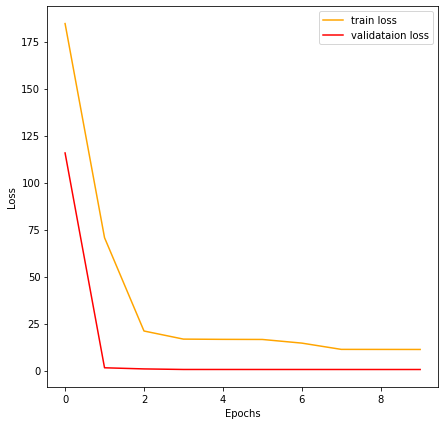

In [248]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=8, out_features=7)
        self.enc2 = nn.Linear(in_features=7, out_features=6)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=6, out_features=7)
        self.dec2 = nn.Linear(in_features=7, out_features=8)
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
 
        # decoding
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
       
        return x
    
model = SparseAutoencoder().to(device)

model_children = list(model.children()) # layers as a list

def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(torch.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(rho_hat)).to(device)
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))


def sparse_loss(rho, data):
    values = data
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += kl_divergence(rho, values)
    return loss

learning_rate = 0.05
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=0.0)

def train(model, dataloader, epoch):
    print('Training')
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(trainset)/dataloader.batch_size)):
        counter += 1
        dat = data.type(torch.FloatTensor)
        dat = dat.to(device)
        dat = dat.view(dat.size(0), -1)
        optimizer.zero_grad()
        outputs = model(dat)
        mse_loss = criterion(outputs, dat)
        if ADD_SPARSITY == 'yes':
            sparsity = sparse_loss(RHO, dat)
            # add the sparsity penalty
            loss = mse_loss + BETA * sparsity
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / counter
    print(f"Train Loss: {epoch_loss:.3f}")
    return epoch_loss

def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
            counter += 1
            dat = data.type(torch.FloatTensor)
            dat = dat.to(device)
            dat = dat.view(dat.size(0), -1)
            outputs = model(dat)
            loss = criterion(outputs, dat)
            running_loss += loss.item()
    epoch_loss = running_loss / counter
    print(f"Val Loss: {epoch_loss:.3f}")  
    return epoch_loss

EPOCHS = 10
BETA = 0.005
ADD_SPARSITY = 'yes'
RHO = 0.05
BATCH_SIZE = 500

train_loss = []
val_loss = []
start = time.time()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = train(model, trainloader, epoch)
    val_epoch_loss = validate(model, testloader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
end = time.time()
print(f"{(end-start)/60:.3} minutes")
# save the trained model
torch.save(model.state_dict(), f"../outputs/sparse_ae{EPOCHS}.pth")

# loss plots
plt.figure(figsize=(7, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
testset_unlab = unlab.iloc[:,1:]
testloader = DataLoader(
    testset_unlab, 
    batch_size=500,
    shuffle=False
)

print(testset_unlab.shape)

(29532, 8)


In [27]:
dat = torch.tensor(testset_unlab.values).type(torch.FloatTensor)
dat = dat.to(device)
dat = dat.view(dat.size(0), -1)
        
Autoencoder_output_test_unlab = model(dat)
print(Autoencoder_output_test_unlab.shape)

torch.Size([29532, 8])


In [28]:
#testloader
testloader = DataLoader(
    Autoencoder_output_test_unlab, 
    batch_size=Autoencoder_output_test_unlab.shape[0], 
    shuffle=False
)

for i, data in tqdm(enumerate(testloader), total=int(len(testset)/testloader.batch_size)):
        dat = data.type(torch.FloatTensor)
        dat = dat.to(device)
        dat = dat.view(dat.size(0), -1)

logit = D(dat)
print(logit.shape)
prediction1 = torch.sigmoid(logit.squeeze())
prediction2 = logit
pred = prediction2.detach().numpy()
prediction1 = prediction1.detach().numpy()
print(pred.shape[0])
pred = pd.DataFrame(pred)
prediction1 = pd.DataFrame(prediction1)
print(pred.shape[0])
pred.reset_index(drop=True, inplace=True)
y_unlab = unlab.iloc[:,0]
y_unlab.reset_index(drop=True, inplace=True)
prediction1.reset_index(drop=True, inplace=True)
pred = pd.concat([pred,prediction1, y_unlab], axis=1, join='inner', ignore_index=False)
print(pred.shape)
pred.to_csv('D:/Vtech/Data Analytics/project/discriminator_unlab-finalfinal.csv', index=False) #exporting dummy dataframe to csv 

1it [00:00,  3.95it/s]

torch.Size([29532, 1])
29532
29532
(29532, 3)


# References

https://debuggercafe.com/sparse-autoencoders-using-kl-divergence-with-pytorch/

https://debuggercafe.com/sparse-autoencoders-using-l1-regularization-with-pytorch/

https://github.com/Abhipanda4/Sparse-Autoencoders

https://github.com/mcanalesmayo/SparseAutoencoder

https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf